<a href="https://colab.research.google.com/github/0xpix/CERI-Project/blob/main/notebooks/Geemap_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine

In [1]:
# @title Connect to my private Repo
# Essentiel libraries
from google.colab import userdata
import subprocess
import os

repo_url = f"https://{userdata.get('GITHUB_KEY')}@github.com/0xpix/CERI-Project.git"
repo_dir = "/content/CERI"
main_dir = "/content"

def run_command(command):
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print(result.stdout)
    if result.stderr:
        print(result.stderr)

# Check if the .git directory exists within the repo directory
if os.path.isdir(os.path.join(repo_dir, '.git')):
    print("\033[92m" + f"The repository '{repo_dir}' already exists. Fetching the latest changes..." + "\033[0m")
    # Cd to the directory CERI
    os.chdir(main_dir)
    # Fetch the latest changes
    os.system('git pull origin main')
    # Go back to the main folder
    os.chdir(repo_dir)
else:
    print("\033[92m" + f"Cloning the repository '{repo_dir}'..." + "\033[0m")
    # Clone the repo inside the directory CERI
    os.system(f'git clone {repo_url} {repo_dir}')
    # Cd to the directory CERI
    os.chdir(repo_dir)

Cloning the repository '/content/CERI'...


In [2]:
# @title Install Packages
%%capture
!pip install -U geemap # Upgrade geemap to the latest version
!pip install -q earthpy rioxarray cftime h5pyd Bottleneck # install in colab
!pip install rasterio localtileserver # for read HDF files

In [76]:
# @title Import Libraries
import warnings
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import random
import time
import os
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Earth Engine API
import ee
import geemap
import folium

# GEE authentication
try:
    ee.Initialize(project='aims-ai2324-std-aness-9fl')
except:
    ee.Authenticate()
    ee.Initialize(project='aims-ai2324-std-aness-9fl')

warnings.simplefilter('ignore')

# My functions
from github_push import git_operations
from src.visualization.visualizing import *
from src.utils import *

# ================
#   Data Related
# ================
# Define the path to the shapefile asset
shapefile_PATH = 'data/shapefile/Africa_Shapefile/afr_g2014_2013_0.shp'
asset_PATH = 'projects/aims-ai2324-std-aness-9fl/assets/Africa_shapefile'

# Define the Disasters data path
Disasters_in_africa_2000_2018_processed_PATH = "data/processed/Disasters_in_africa_2000_2018_processed.csv"

# Specify a list of country names for which the data is to be filtered
country_names = [
    "Burundi", "Kenya", "Rwanda", "South Sudan",
    "United Republic of Tanzania", "Uganda", "Djibouti", "Eritrea",
    "Ethiopia", "Somalia"
]

# ================
# Configs related
# ================
africa_map_config = {
    "center": [0, 17],
    "width": "75%",
    "height": 900,
    "zoom": 3.5,
    "data_ctrl": False,
    "toolbar_ctrl": False,
    "draw_ctrl": False
}

In [4]:
geemap.__version__ # geemap version

'0.32.1'

In [5]:
# DON'T RUN EVERY TIME
# Commit the changes
# git_operations("Updated script")

# Climate Disasters Dataset. (EM-DAT + GDIS)

In [ ]:
# @title Parameters
'''
Disaster type
Flood (768), Storm (111), Drought (83), Earthquake (23), Volcanic activity (3)
'''

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
    "Mass movement (dry) ": "#FFFFFF"
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('Disaster type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [ ]:
df = pd.read_csv(Disasters_in_africa_2000_2018_processed_PATH)
df

disasterno   Country              Location Disaster type        Date  \
0      1999-9388  Djibouti                Dikhil       Drought  2001-01-06   
1      1999-9388  Djibouti   Tadjourah provinces       Drought  2001-01-06   
2      1999-9388  Djibouti              Djibouti       Drought  2001-01-06   
3      1999-9388  Djibouti                 Obock       Drought  2001-01-06   
4      1999-9388  Djibouti            Ali Sabieh       Drought  2001-01-06   
...          ...       ...                   ...           ...         ...   
43370  2018-0479   Burundi               Gatumba         Flood  2018-04-05   
43371  2018-0479   Burundi               Vugizo          Flood  2018-04-05   
43372  2018-0479   Burundi               Gatumba         Flood  2018-04-05   
43373  2018-0479   Burundi               Vugizo          Flood  2018-04-05   
43374  2018-0479   Burundi               Gatumba         Flood  2018-04-05   

       Year  Total deaths   Latitude  Longitude  
0      2001           0.0  11.371151  42.189715  
1      2001           0.0  12.009324  42.525971  
2      2001           0.0  11.508688  43.006549  
3      2001           0.0  12.278938  43.085955  
4      2001           0.0  11.245256  42.908944  
...     ...           ...        ...        ...  
43370  2018           0.0  -3.312979  29.242054  
43371  2018           0.0  -4.153846  29.678495  
43372  2018           0.0  -3.312979  29.242054  
43373  2018           0.0  -4.153846  29.678495  
43374  2018           0.0  -3.312979  29.242054  

[43375 rows x 9 columns]

In [ ]:
# Initialize the map
Map_africa = geemap.Map(**africa_map_config)

# Convert the csv file (After preprocessing) into an earth engine feature
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country = collections.aggregate_histogram('location')

# Print the aggregated results
len(disasters_by_country.getInfo())

2542

## Plot the total deaths for each country

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country = collections.aggregate_histogram('country')

# Print the aggregated results
disasters_by_country.getInfo()

{'Algeria': 5820,
 'Angola': 1600,
 'Benin': 593,
 'Botswana': 384,
 'Burkina Faso': 848,
 'Burundi': 625,
 'Cameroon': 157,
 'Central African Republic': 158,
 'Chad': 805,
 'Comoros': 46,
 'Djibouti': 112,
 'Egypt': 160,
 'Eritrea': 23,
 'Ethiopia': 696,
 'Gabon': 52,
 'Gambia': 101,
 'Ghana': 862,
 'Guinea': 195,
 'Guinea-Bissau': 146,
 'Kenya': 4062,
 'Lesotho': 282,
 'Liberia': 37,
 'Libya': 4,
 'Madagascar': 3897,
 'Malawi': 2301,
 'Mali': 801,
 'Mauritania': 499,
 'Mauritius': 51,
 'Morocco': 378,
 'Mozambique': 4628,
 'Namibia': 355,
 'Niger': 1218,
 'Nigeria': 1701,
 'Rwanda': 392,
 'Senegal': 667,
 'Seychelles': 895,
 'Sierra Leone': 42,
 'Somalia': 1116,
 'South Africa': 807,
 'South Sudan': 215,
 'Sudan': 1113,
 'Togo': 131,
 'Tunisia': 190,
 'Uganda': 1380,
 'Zambia': 564,
 'Zimbabwe': 2266}

In [ ]:
# Define visualization parameters
vis_params_disasters_count = {
    'min': 0,
    'max': 110,  # Adjust the max value based on your data
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000'] # ['#bfbfbf', '#838383', '#1a1a1a', '#4d1414', '#b40d0d']
}

# Join the disaster counts with the countries dataset
def add_disaster_count(feature):
    country_name = feature.get('ADM0_NAME')
    disaster_count = ee.Number(disasters_by_country.get(country_name, 0))
    return feature.set('disaster_count', disaster_count)

# Specify the Area of study and plot it in EE map
african_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
countries_with_counts = african_countries.map(add_disaster_count)

In [ ]:
# Create an image for visualization
disaster_count_image = countries_with_counts.reduceToImage(
    properties=['disaster_count'],
    reducer=ee.Reducer.first()
)

# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Add countries with disaster counts to the map
Map_africa_deaths.addLayer(disaster_count_image.visualize(**vis_params_disasters_count), {}, 'Disaster Counts')

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_disasters_count, label='Number of Disasters')

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Interpretation
Countries like Algeria (88), Kenya (68), and Mozambique (108) have experienced a high number of disasters.

Countries like Madagascar (57), Uganda (59), Nigeria (57), Niger (41), Malawi (52), Angola (53), Ethiopia (31), and Sudan (34) show a significant number of disasters.

The rest of the countries in West and Central Africa, as well as some parts of East Africa, show relatively lower numbers of disasters.

## Plot total Death for each country

In [ ]:
# Load the data
data = pd.read_csv(Disasters_in_africa_2000_2018_processed_PATH)

# Remove duplicate entries based on Country and Date
data = data.drop_duplicates(subset=['Country', 'Date'])

# Aggregate deaths by country
deaths_by_country = data.groupby('Country')['Total deaths'].sum().to_dict()
deaths_dict = ee.Dictionary(deaths_by_country)

In [ ]:
# Functions
def create_feature_collection():
    countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries

    def add_death_count(feature):
        country_name = feature.get('ADM0_NAME')
        deaths = ee.Number(deaths_dict.get(country_name, 0))
        return feature.set('deaths', deaths)

    return countries.map(add_death_count)

feature_collection = create_feature_collection()

In [ ]:
# Parameters
vis_params_deaths = {
    'min': 0,
    'max': max(deaths_by_country.values()),
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000']
}

deaths_image = feature_collection.reduceToImage(
    properties=['deaths'],
    reducer=ee.Reducer.first()
)

In [ ]:
# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Add countries with disaster counts to the map
Map_africa_deaths.addLayer(deaths_image.visualize(**vis_params_deaths), {}, 'Deaths by Country')

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_deaths, label='Number of Deaths')

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Interpretation
Somalia has the highest number of deaths on the continent, in the range of 15,000 to 20,000.

Algeria has a noticeable number of deaths.

The rest of the African countries have lower numbers of deaths, with many countries having very few or zero deaths.

# Landscan Global using Google earth engine

## Continent level

In [ ]:
# @title Legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 300px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color: rgba(255, 255, 255, 0.8);
            padding: 10px; color: #000000;">
    <h4 style="margin-top:0;color: #000000;">Population Count (Estimate)</h4>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #D3D3D3; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">No Data</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FFFFCC; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">0 - 5</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FFEDA0; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">6 - 25</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FEB24C; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">26 - 50</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FD8D3C; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">51 - 100</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #FC4E2A; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">101 - 500</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #E31A1C; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">501 - 2500</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #BD0026; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">2501 - 5000</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #800026; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">5001 - 185000</span>
    </div>
</div>
'''

In [ ]:
# @title Parameters
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL") # Global
africa_shapefile = ee.FeatureCollection(asset_PATH)
landscan_africa = landscan_global.map(lambda image: image.clip(africa_shapefile)) # Africa only

# Define the SLD style for population count intervals
popcount_intervals = '''
<RasterSymbolizer>
  <ColorMap type="intervals" extended="false">
    <ColorMapEntry color="#CCCCCC" quantity="0" label="No Data"/>
    <ColorMapEntry color="#FFFFBE" quantity="5" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FEFF73" quantity="25" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FEFF2C" quantity="50" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FFAA27" quantity="100" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FF6625" quantity="500" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FF0023" quantity="2500" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#CC001A" quantity="5000" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#730009" quantity="185000" label="Population Count (Estimate)"/>
  </ColorMap>
</RasterSymbolizer>
'''

# Define the legend dictionary
legend_dict = {
    'No Data': '#CCCCCC',
    '0 - 5': '#FFFFBE',
    '6 - 25': '#FEFF73',
    '26 - 50': '#FEFF2C',
    '51 - 100': '#FFAA27',
    '101 - 500': '#FF6625',
    '501 - 2500': '#FF0023',
    '2501 - 5000': '#CC001A',
    '5001 - 185000': '#730009'
}

In [ ]:
# Get the first image from the ImageCollection
landscan_2000 = landscan_africa.first()

# Create a map
Map = geemap.Map(**africa_map_config)

# Add layers to the map
Map.add_layer(
    landscan_2000.sldStyle(popcount_intervals), {}, 'Population Count Estimate 2000'
)

# Add the legend to the map
Map.add_html(legend_html, position='bottomleft')

# Display the map
Map_africa.addLayerControl()
Map

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
# Get the first image from the collection for the year 2000
image_2000 = ee.Image("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000")
image_2000 = image_2000.toFloat() # Convert the image to a float type to ensure proper calculations

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)
roi = africa_shapefile.geometry().dissolve() # Define the region of interest (ROI) for Africa using the shapefile

# Define the intervals
intervals = [
    (0, 5), (5, 25), (25, 50), (50, 100),
    (100, 500), (500, 2500), (2500, 5000), (5000, 185000)
]

In [ ]:
# Compute mean, min, max, stdDev, and percentiles
mean_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
min_max_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
std_dev_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
percentiles_dict = image_2000.reduceRegion(
    reducer=ee.Reducer.percentile([10, 25, 50, 75, 90]),
    geometry=roi,
    scale=1000,
    bestEffort=True
)

# Calculate sum, mean, min, max, and stdDev of the population
sum_population = image_2000.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
mean_population = image_2000.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
min_max_population = image_2000.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
std_dev_population = image_2000.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)

# Combine results into a summary dictionary
summary = {
    'Mean Population': mean_dict.getInfo(),
    'Min Population': min_max_dict.getInfo()['min'],
    'Max Population': min_max_dict.getInfo()['max'],
    'Standard Deviation of Population': std_dev_dict.getInfo(),
    'Population Percentiles': percentiles_dict.getInfo(),
    'Total Population': sum_population.getInfo()['sum'],
    'Mean Population': mean_population.getInfo()['mean'],
    'Min Population': min_max_population.getInfo()['min'],
    'Max Population': min_max_population.getInfo()['max'],
    'Standard Deviation of Population': std_dev_population.getInfo()
}

# Print the summary
print('Statistical Summary:', summary)

In [ ]:
# Function to create a grid of smaller regions
def create_grid(geometry, rows, cols):
    bounds = geometry.bounds().coordinates().get(0).getInfo()
    lon_min, lat_min = bounds[0]
    lon_max, lat_max = bounds[2]

    lon_step = (lon_max - lon_min) / cols
    lat_step = (lat_max - lat_min) / rows

    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = ee.Geometry.Rectangle([
                [lon_min + i * lon_step, lat_min + j * lat_step],
                [lon_min + (i + 1) * lon_step, lat_min + (j + 1) * lat_step]
            ])
            grid_cells.append(cell)

    return grid_cells

# Split the region into smaller grids
grid_cells = create_grid(roi, 10, 10)  # Adjust the grid size as needed

# Function to calculate the total population for a given year and grid cell
def calculate_population(image, region, scale):
    total_population = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Initialize a DataFrame to store the results
years = list(range(2000, 2019))
population_data = []

# Calculate the population for each year and each grid cell, then aggregate the results
for year in years:
    image = landscan_global.filter(ee.Filter.eq('system:index', f'landscan-global-{year}')).first()
    if image is None:
        continue

    year_total_population = 0
    for cell in grid_cells:
        population = calculate_population(image, cell, 1000) # scale = 1000 to get more accurate results
        year_total_population += population if population is not None else 0

    population_data.append({
        'Year': year,
        'Population': year_total_population
    })

In [ ]:
# Convert the data into a pandas DataFrame
df_population = pd.DataFrame(population_data)

# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the DataFrame
print(df_population)

In [ ]:
# Check point (saved dataframe for population count over the years)
AFRICA_POP_PATH = "/content/CERI/data/processed/Africa_level_population_2000_2018.csv"

# Save the file
# df_population_africa.to_csv(AFRICA_POP_PATH, index=False)

# Load the file
df_population_africa = pd.read_csv(AFRICA_POP_PATH)
pd.options.display.float_format = '{:,.2f}'.format
df_population_africa

Unnamed: 0  Year       Population
0            0  2000   859,820,075.30
1            1  2001   878,720,050.80
2            2  2002   896,187,284.80
3            3  2003   916,226,740.10
4            4  2004   930,725,786.30
5            5  2005   952,241,238.50
6            6  2006   973,253,782.00
7            7  2007   994,688,717.90
8            8  2008 1,031,934,403.00
9            9  2009 1,051,343,733.00
10          10  2010 1,082,025,676.00
11          11  2011 1,118,577,134.00
12          12  2012 1,137,994,035.00
13          13  2013 1,165,388,802.00
14          14  2014 1,206,209,040.00
15          15  2015 1,237,959,443.00
16          16  2016 1,264,643,040.00
17          17  2017 1,291,548,155.00
18          18  2018 1,341,748,432.00

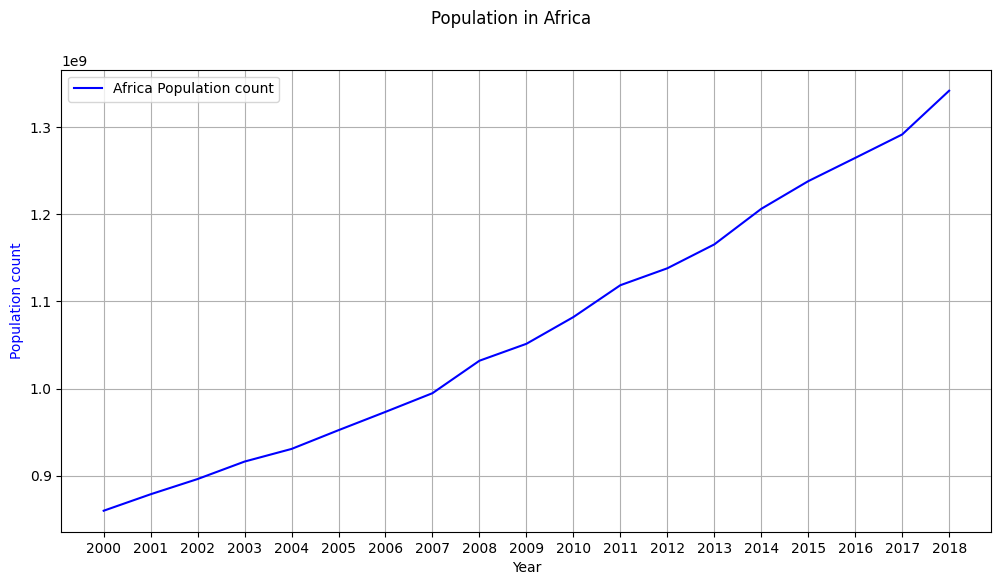

In [ ]:
# Plot the population changes and disaster counts for the specified country
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_population_africa['Year'].astype(str), df_population_africa['Population'], label=f"Africa Population count", color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population count', color='b')

# Title and legend
fig.suptitle(f'Population in Africa')
ax1.legend(loc='upper left')

# Grid and show
ax1.grid(True)
plt.show()

## Country level

In [ ]:
# @title Parameters
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Filter the Africa shapefile to include only the specified countries
filtered_countries = africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', countries))

# Define the intervals
intervals = [
    (0, 5), (5, 25), (25, 50), (50, 100),
    (100, 500), (500, 2500), (2500, 5000), (5000, 185000)
]

In [ ]:
country_name = "Zimbabwe"
filtered_country = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Create a map
Map = geemap.Map(height=800, width="70%")

pop_2000 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000")
pop_2010 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2010")
clipped_image_2000 = pop_2000.clip(filtered_country) # Clip the landscan_global image with the country's boundary
clipped_image_2010 = pop_2010.clip(filtered_country)

left_layer = geemap.ee_tile_layer(clipped_image_2000.sldStyle(popcount_intervals), {}, "Pop count 2000")
right_layer = geemap.ee_tile_layer(clipped_image_2010.sldStyle(popcount_intervals), {}, "Pop count 2010")

# Map.add_layer(clipped_image.sldStyle(popcount_intervals), {}, 'Population Count Estimate 2000')
Map.add_layer(filtered_country.style(**{'color': 'red'}), {}, country_name)

# Add the legend to the map
Map.add_legend(title='Population Count Estimate', legend_dict=legend_dict)

# Center the map on the selected country
country_geom = filtered_country.geometry()
Map.centerObject(country_geom, zoom=7)

# Display the map
Map.split_map(left_layer, right_layer)
Map

Map(center=[-18.99298187251295, 29.868341570404244], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
# Function to calculate the total population for a given year and region
def calculate_population(image, region, scale):
    total_population = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Initialize a DataFrame to store the results
years = list(range(2000, 2019))
population_data = []

# Calculate the population for each country and each year, then store the results
for country in countries:
    country_feature = filtered_countries.filter(ee.Filter.eq('ADM0_NAME', country)).first()
    if country_feature is None:
        continue

    for year in years:
        image = landscan_global.filter(ee.Filter.eq('system:index', f'landscan-global-{year}')).first()
        if image is None:
            continue

        population = calculate_population(image, country_feature, 1000)
        population_data.append({
            'Country': country,
            'Year': year,
            'Population': population if population is not None else 0
        })

In [ ]:
# Convert the data into a pandas DataFrame
df_population_country_lvl = pd.DataFrame(population_data)

# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the DataFrame
print(df_population_country_lvl)

In [ ]:
# Check point
Country_LVL_POP_PATH = "/content/CERI/data/processed/Country_level_population_2000_2018.csv"

# Save the file
# df_population_country_lvl.to_csv(Country_LVL_POP_PATH, index=False)

# Load the file
df_population_country_lvl = pd.read_csv(Country_LVL_POP_PATH)
pd.options.display.float_format = '{:,.2f}'.format
df_population_country_lvl.head(3)

Country  Year    Population
0  Zimbabwe  2000  9,751,919.54
1  Zimbabwe  2001  9,707,988.09
2  Zimbabwe  2002 10,646,151.27

## Change detection


In [ ]:
# @title Choose the year
year_1 = 2007 # @param {"type": "number"}
year_2 = 2009 # @param {"type": "number"}

In [ ]:
# @title Parameters
single_country_map_config = {
    'height':800,
    'width':"70%",
    'center': [0, 20],
    'zoom': 3
}

# Add population change layer to the map
vis_params = {
    'min': -3,
    'max': 3,
    'palette': ['#eb389f', '#cccccc', '#018f1d']
}

# Add a legend to the map
legend_dict = {
    'Decline': '#eb389f',
    'Uninhabited': '#cccccc',
    'Growth': '#018f1d'
}

# Define the legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 100px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color: rgba(255, 255, 255, 0.8);
            padding: 10px; color: #000000">
    <h4 style="margin-top:0; color: #000000">Population Change</h4>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #eb389f; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">Decline</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #cccccc; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">Uninhabited</span>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background-color: #018f1d; width: 20px; height: 20px;"></div>
        <span style="margin-left: 10px;">Growth</span>
    </div>
</div>
'''

In [ ]:
df_population_country_lvl['Country'].unique()

array(['Zimbabwe', 'Mozambique', 'Sudan', 'Malawi', 'Ethiopia',
       'Mauritania', 'Mali', 'Algeria', 'Uganda', 'Madagascar', 'Kenya',
       'Senegal', 'Angola', 'South Africa', 'Somalia', 'Comoros',
       'Burundi', 'Niger', 'Burkina Faso', 'Ghana', 'Rwanda',
       'South Sudan', 'Namibia', 'Chad', 'Zambia', 'Nigeria', 'Benin',
       'Egypt', 'Botswana'], dtype=object)

### Calculate the change detection

In [ ]:
africa_shapefile = ee.FeatureCollection(asset_PATH)

# Function to filter a country from the shapefile
def filter_country(country_name):
    return africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Function to calculate population change between two years for a given country
def calculate_population_change(country_name, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter the country based on input
    filtered_country = filter_country(country_name)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_country)

    # Calculate the total change in population
    scale = 1000  # Scale in meters
    total_change = pop_change_clipped.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=filtered_country.geometry(),
        scale=scale,
        maxPixels=1e9
    )

    # Get the change value
    change_dict = total_change.getInfo()

    # Extract only the numeric values
    change_value = change_dict.get('b1', 0)

    return change_value

# List of countries to process
countries = ['Zimbabwe', 'Mozambique', 'Sudan', 'Malawi', 'Ethiopia', 'Mauritania', 'Mali', 'Algeria', 'Uganda',
             'Madagascar', 'Kenya', 'Senegal', 'Angola', 'South Africa', 'Somalia', 'Comoros', 'Burundi', 'Niger',
             'Burkina Faso', 'Ghana', 'Rwanda', 'South Sudan', 'Namibia', 'Chad', 'Zambia', 'Nigeria', 'Benin',
             'Egypt', 'Botswana']
year_1 = 2007
year_2 = 2009

# Calculate population changes for all specified countries
pop_changes = {}
for country in countries:
    pop_change_value = calculate_population_change(country, year_1, year_2)
    pop_changes[country] = pop_change_value

# Print the results
for country, change in pop_changes.items():
    print(f"Population change in {country} from {year_1} to {year_2}: {change}")

Population change in Zimbabwe from 2007 to 2009: -786071.2549019628
Population change in Mozambique from 2007 to 2009: 707018.635294119
Population change in Sudan from 2007 to 2009: 1192704.3137254892
Population change in Malawi from 2007 to 2009: 1235505.2980392126
Population change in Ethiopia from 2007 to 2009: 7519627.8313725395
Population change in Mauritania from 2007 to 2009: -127205.64705882341
Population change in Mali from 2007 to 2009: 1235764.666666668
Population change in Algeria from 2007 to 2009: 711417.9803921569
Population change in Uganda from 2007 to 2009: 1870770.3019607838
Population change in Madagascar from 2007 to 2009: 1018827.3686274518
Population change in Kenya from 2007 to 2009: 1842491.3450980398
Population change in Senegal from 2007 to 2009: 1016368.5686274485
Population change in Angola from 2007 to 2009: 459830.50196078414
Population change in South Africa from 2007 to 2009: 4330337.517647049
Population change in Somalia from 2007 to 2009: 600046.21568

### Visualization

#### Visualization without disasters

In [ ]:
vis_changde_detection = {
    'zoom': 6,
    'width': '60%',
    'height': 800
}

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Example usage
single_country_name = ['Zimbabwe']
year1 = 2007
year2 = 2009
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(**vis_changde_detection)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {'opacity': 0.4}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Example usage
single_country_name = ['Ghana']
year1 = 2007
year2 = 2009
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(center=[0, 20], zoom=3)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {'opacity': 0.4}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Example usage
single_country_name = ['Burundi']
year1 = 2007
year2 = 2009
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(center=[0, 20], zoom=3)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {'opacity': 0.4}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

#### Visualization with disasters

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Create a geemap map
viz_dis_map_config = {
    'center': [0, 20],
    'zoom': 3
}

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}

In [ ]:
# Function to generate a list of dates
def generate_date_list(start_date, end_date):
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

# Generate a list of dates for the year 2008
date_list = generate_date_list(datetime(2008, 1, 1), datetime(2008, 12, 31))

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('disaster_type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [ ]:
# it has 32 climate disaster = Drought in 2008
single_country_name = ['Burundi']
year1 = 2008
year2 = 2013

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 1
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 36
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
single_country_name = ['Ghana']
year1 = 2007
year2 = 2009

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 4
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

Ghana - flood - 2018 - 14000 people displaced

In [ ]:
# Generate a list of dates for the year 2009
date_list = generate_date_list(datetime(2009, 1, 1), datetime(2009, 12, 31))

single_country_name = ['Ghana']
year1 = 2008
year2 = 2010

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 66
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

Ghana - flood - 2009 -

In [ ]:
# Generate a list of dates for the year 2009
date_list = generate_date_list(datetime(2012, 1, 1), datetime(2012, 12, 31))

single_country_name = ['Nigeria']
year1 = 2011
year2 = 2013

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 342
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

Nigeria - flood - 3871000 displaced people

In [ ]:
'''
       Country  Internal Displacements       Date Disaster type
0      Nigeria                 8531816 2009-01-01         Flood
1      Somalia                 4643944 2008-03-11         Flood
2     Ethiopia                 3675840 2008-05-30         Flood
3  South Sudan                 2503376 2012-01-01         Flood
4        Niger                 2114305 2008-07-01         Flood
5        Sudan                 1955348 2008-08-01         Flood
6        Kenya                 1742910 2008-03-17         Flood
7   Mozambique                 1498829 2008-01-09      Wildfire
8   Madagascar                 1430408 2008-01-27         Storm
9       Malawi                  987083 2009-01-01    Earthquake
'''

In [ ]:
# @title Ethiopia
# Ethiopia                 3675840 2008-05-30         Flood
# Generate a list of dates for the year 2008
year = 2008
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['Ethiopia']
year1 = year - 1
year2 = year + 1

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 0
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 36
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# @title Ethiopia
# Ethiopia                 3675840 2008-05-30         Flood
# Generate a list of dates for the year 2008
year = 2008
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['Ethiopia']
year1 = year
year2 = year + 5

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# @title South Sudan
# South Sudan                 2503376 2012-01-01         Flood
# Generate a list of dates for the year 2012
year = 2012
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['South Sudan']
year1 = year - 1
year2 = year + 1

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 26
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# @title South Niger
# Niger                 2114305 2008-07-01         Flood
# Generate a list of dates for the year 2008
year = 2008
date_list = generate_date_list(datetime(year, 1, 1), datetime(year, 12, 31))

single_country_name = ['Niger']
year1 = year - 1
year2 = year + 1

# Create the map
Map_africa = geemap.Map(**viz_dis_map_config)

# Calculate the popualation change
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map_africa.addLayer(filter_countries(single_country_name), {'opacity':0.4}, 'Country Boundary')

for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')
Map_africa.addLayerControl()

# Display the map
Map_africa

Disaster type: Flood, Count: 16
Disaster type: Storm, Count: 0
Disaster type: Drought, Count: 0
Disaster type: Earthquake, Count: 0
Disaster type: Volcanic activity, Count: 0


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

# Another LULC


Google earth LULC:
https://gee-community-catalog.org/projects/glc_fcs/

In [34]:
# @title parameters
# Define the class names, color palette and class values
class_names = [
    "Nothing",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland irrigated or post-flooding",
    "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)",
    "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland",
    "Shrubland",
    "Shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water",
    "Shrub or herbaceous cover flooded",
    "Urban areas",
    "Bare areas",
    "Bare areas",
    "Bare areas",
    "Water bodies",
    "Permanent snow and ice"
]

color_palette = [
    '#ffffff','#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000','#285000',
    '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400', '#966400', '#ffb432',
    '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf', '#00785a', '#009678', '#00dc82',
    '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7', '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

In [ ]:
# Define the color palette
palette = [
    "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
    "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
    "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
    "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
    "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
]

class_names = [
    "Rainfed cropland", "Herbaceous cover cropland", "Tree or shrub cover (Orchard) cropland",
    "Irrigated cropland", "Open evergreen broadleaved forest", "Closed evergreen broadleaved forest",
    "Open deciduous broadleaved forest (0.15<fc<0.4)", "Closed deciduous broadleaved forest (fc>0.4)",
    "Open evergreen needle-leaved forest (0.15< fc <0.4)", "Closed evergreen needle-leaved forest (fc >0.4)",
    "Open deciduous needle-leaved forest (0.15< fc <0.4)", "Closed deciduous needle-leaved forest (fc >0.4)",
    "Open mixed leaf forest (broadleaved and needle-leaved)", "Closed mixed leaf forest (broadleaved and needle-leaved)",
    "Shrubland", "Evergreen shrubland", "Deciduous shrubland", "Grassland", "Lichens and mosses",
    "Sparse vegetation (fc<0.15)", "Sparse shrubland (fc<0.15)", "Sparse herbaceous (fc<0.15)", "Swamp",
    "Marsh", "Flooded flat", "Saline", "Mangrove", "Salt marsh", "Tidal flat", "Impervious surfaces",
    "Bare areas", "Consolidated bare areas", "Unconsolidated bare areas", "Water body", "Permanent ice and snow",
    "Filled value"
]

In [71]:
# Function to recode class values into sequential values starting from 1 onwards
def recode_classes(image):
    # Define the class values
    classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122,
               130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200,
               201, 202, 210, 220, 0]
    reclassed = image.remap(classes, ee.List.sequence(1, len(classes)))
    return reclassed

# Path to the Africa shapefile asset
africa_shapefile = ee.FeatureCollection(asset_PATH)

# Create a geemap map
Map = geemap.Map(**africa_map_config)

annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")

# Load the GLC-FCS30D collection
image = annual.mosaic().clip(africa_shapefile)

# Iterate over each band (year) in the image
for i in range(1, 2):
    year = 2007 + i  # starts at year 2000 for annual maps
    layer_name = f"GLC FCS {year}"
    band = image.select(f"b{i}")

    # Apply the function to the band and add layer
    Map.addLayer(recode_classes(band), {'palette': palette}, layer_name)

# Add a layer control
Map.addLayerControl()

# Create a legend
legend_dict = dict(zip(class_names, palette))
Map.add_legend(title="Land Cover Classes", legend_dict=legend_dict)

# Display the map
Map

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Change detection

In [81]:
image_before = annual.select(f"band{year - 2001}")

In [87]:
# Function to perform change detection
def change_detection(year_of_disaster, country_name, class_names):
    # Load Africa's shapefile
    africa_shapefile = ee.FeatureCollection(asset_PATH)
    filtered_country = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

    # Load the GLC-FCS30D collection
    annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic().clip(filtered_country)

    # Get images for the specified years
    image_before = annual.select(f"b{year - 2001}")
    image_after = annual.select(f"b{year - 1999}")

    # Recode classes
    recoded_before = recode_classes(image_before)
    recoded_after = recode_classes(image_after)

    # Calculate change detection (difference)
    change = recoded_after.subtract(recoded_before).selfMask()

    # Create a geemap map
    Map = geemap.Map()

    # Add layers to the map
    Map.addLayer(recoded_before, {'palette': palette, 'min': 1, 'max': len(class_names)}, f"{year_of_disaster - 1} Land Cover")
    Map.addLayer(recoded_after, {'palette': palette, 'min': 1, 'max': len(class_names)}, f"{year_of_disaster + 1} Land Cover")
    Map.addLayer(change, {'palette': ['red', 'green'], 'min': -1, 'max': 1}, 'Change Detection')

    # Add a layer control
    Map.addLayerControl()

    # Create a legend
    legend_dict = dict(zip(class_names, palette))
    Map.add_legend(title="Land Cover Classes", legend_dict=legend_dict)

    return Map

# Example usage
year_of_disaster = 2008
country_name = 'Kenya'  # replace with your country of interest
classes_of_interest = ["Impervious surfaces"]

# Perform change detection
Map = change_detection(year_of_disaster, country_name, classes_of_interest)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [46]:
def change_detection(disaster_year, country_name, class_name):
    # Load Africa's shapefile
    africa_shapefile = ee.FeatureCollection(asset_PATH)

    # Filter the shapefile to get the specific country
    filtered_country = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

    # Define the years for change detection
    year_before = disaster_year - 1
    year_after = disaster_year + 6

    # Load land cover data for the specified years
    land_cover_before = ee.ImageCollection("MODIS/006/MCD12Q1").filter(ee.Filter.date(f'{year_before}-01-01', f'{year_before}-12-31')).first().select('LC_Type1')
    land_cover_after = ee.ImageCollection("MODIS/006/MCD12Q1").filter(ee.Filter.date(f'{year_after}-01-01', f'{year_after}-12-31')).first().select('LC_Type1')

    # Clip the images to the specified country
    land_cover_before_clip = land_cover_before.clip(filtered_country)
    land_cover_after_clip = land_cover_after.clip(filtered_country)

    # Get the class index
    if class_name not in class_names:
        raise ValueError(f"Class name '{class_name}' is not valid. Please choose from the predefined class names.")
    class_index = class_values[class_names.index(class_name)]

    # Calculate the change detection
    increase_mask = land_cover_after_clip.eq(class_index).And(land_cover_before_clip.neq(class_index))
    decrease_mask = land_cover_before_clip.eq(class_index).And(land_cover_after_clip.neq(class_index))

    change_result = increase_mask.multiply(1).add(decrease_mask.multiply(-1))

    # Mask out areas with no change
    change_result = change_result.updateMask(change_result.neq(0))

    # Define the visualization parameters
    vis_params = {
        'min': -1,
        'max': 1,
        'palette': ['#ff0000', '#00ff00'],  # Red for decrease, green for increase
    }

    # Display the results using geemap
    map = geemap.Map()
    map.centerObject(filtered_country, 6)
    map.addLayer(change_result, vis_params, 'Change Detection')
    map.addLayer(filtered_country, {'opacity':0.4}, 'Country Boundary')
    map.add_colorbar(vis_params, label="Land Cover Change", layer_name="Change Detection")
    map.add_legend(title="Change Detection", labels=["Decrease", "Increase"], colors=['#ff0000', '#00ff00'])
    display(map)

disaster_year = 2009
country_name = "Ghana"
class_name = "Urban areas"
change_detection(disaster_year, country_name, class_name)

Map(center=[7.960425753723395, -1.2061873716715812], controls=(WidgetControl(options=['position', 'transparent…

<IPython.core.display.Javascript object>

In [62]:
# Provided class names, color palette, and class values
class_names = [
    "Nothing", "Cropland rainfed", "Cropland rainfed", "Cropland rainfed",
    "Cropland irrigated or post-flooding", "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)", "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)", "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)", "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)", "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)", "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)", "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)", "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland", "Shrubland", "Shrubland", "Grassland", "Lichens and mosses", "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)", "Sparse vegetation (<15%)", "Sparse vegetation (<15%)",
    "Tree cover flooded fresh/brackish water", "Tree cover flooded saline water", "Shrub or herbaceous cover flooded",
    "Urban areas", "Bare areas", "Bare areas", "Bare areas", "Water bodies", "Permanent snow and ice"
]

color_palette = [
    '#ffffff', '#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000', '#285000',
    '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400', '#966400', '#ffb432',
    '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf', '#00785a', '#009678', '#00dc82',
    '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7', '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Function to recode class values into sequential values starting from 1 onwards
def recode_classes(image):
    # Define the class values
    classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122,
               130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200,
               201, 202, 210, 220, 0]
    reclassed = image.remap(classes, ee.List.sequence(1, len(classes)))
    return reclassed

def change_detection(disaster_year, country_name, class_name):
    # Load Africa's shapefile
    africa_shapefile = ee.FeatureCollection(asset_PATH)

    # Filter the shapefile to get the specific country
    filtered_country = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

    # Define the years for change detection
    year_before = disaster_year - 1
    year_after = disaster_year + 1

    # Load land cover data for the specified years and recode classes
    land_cover_before = recode_classes(ee.ImageCollection("MODIS/006/MCD12Q1").filter(ee.Filter.date(f'{year_before}-01-01', f'{year_before}-12-31')).first().select('LC_Type1'))
    land_cover_after = recode_classes(ee.ImageCollection("MODIS/006/MCD12Q1").filter(ee.Filter.date(f'{year_after}-01-01', f'{year_after}-12-31')).first().select('LC_Type1'))

    # Clip the images to the specified country
    land_cover_before_clip = land_cover_before.clip(filtered_country)
    land_cover_after_clip = land_cover_after.clip(filtered_country)

    # Visualize the land cover before and after
    map1 = geemap.Map()
    map1.centerObject(filtered_country, 6)
    map1.addLayer(land_cover_before_clip, {'min': 1, 'max': len(class_values), 'palette': color_palette}, f'Land Cover {year_before}')
    map1.addLayer(filtered_country, {}, 'Country Boundary')
    map1.add_legend(title="Land Cover Classes", labels=class_names, colors=color_palette)
    display(map1)

    map2 = geemap.Map()
    map2.centerObject(filtered_country, 6)
    map2.addLayer(land_cover_after_clip, {'min': 1, 'max': len(class_values), 'palette': color_palette}, f'Land Cover {year_after}')
    map2.addLayer(filtered_country, {}, 'Country Boundary')
    map2.add_legend(title="Land Cover Classes", labels=class_names, colors=color_palette)
    display(map2)

    # Get the class index
    if class_name not in class_names:
        raise ValueError(f"Class name '{class_name}' is not valid. Please choose from the predefined class names.")
    class_index = class_values[class_names.index(class_name)]

    # Calculate the change detection
    increase_mask = land_cover_after_clip.eq(class_index).And(land_cover_before_clip.neq(class_index))
    decrease_mask = land_cover_before_clip.eq(class_index).And(land_cover_after_clip.neq(class_index))

    change_result = increase_mask.multiply(1).add(decrease_mask.multiply(-1))

    # Visualize the change masks
    map3 = geemap.Map()
    map3.centerObject(filtered_country, 6)
    map3.addLayer(increase_mask, {'min': 0, 'max': 1, 'palette': ['#00ff00']}, 'Increase Mask')
    map3.addLayer(decrease_mask, {'min': 0, 'max': 1, 'palette': ['#ff0000']}, 'Decrease Mask')
    map3.addLayer(filtered_country, {}, 'Country Boundary')
    display(map3)

    # Mask out areas with no change
    change_result = change_result.updateMask(change_result.neq(0))

    # Define the visualization parameters
    vis_params = {
        'min': -1,
        'max': 1,
        'palette': ['#ff0000', '#00ff00'],  # Red for decrease, green for increase
    }

    # Display the results using geemap
    map4 = geemap.Map()
    map4.centerObject(filtered_country, 6)
    map4.addLayer(change_result, vis_params, 'Change Detection')
    map4.addLayer(filtered_country, {}, 'Country Boundary')
    map4.add_colorbar(vis_params, label="Land Cover Change", layer_name="Change Detection")
    map4.add_legend(title="Change Detection", labels=["Decrease", "Increase"], colors=['#ff0000', '#00ff00'])
    display(map4)

# Example usage
disaster_year = 2009
country_name = "Ghana"
class_name = "Urban areas"  # Ensure this matches the predefined class names
change_detection(disaster_year, country_name, class_name)

Map(center=[7.960425753723395, -1.2061873716715812], controls=(WidgetControl(options=['position', 'transparent…

Map(center=[7.960425753723395, -1.2061873716715812], controls=(WidgetControl(options=['position', 'transparent…

Map(center=[7.960425753723395, -1.2061873716715812], controls=(WidgetControl(options=['position', 'transparent…

Map(center=[7.960425753723395, -1.2061873716715812], controls=(WidgetControl(options=['position', 'transparent…

In [33]:
disaster_year = 2008
country_name = "Niger"
change_detection(disaster_year, country_name, class_names=["Urban areas"])

Map(center=[17.413199010685446, 9.346587132013463], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [36]:
disaster_year = 2009
country_name  = "Ghana"
change_detection(disaster_year, country_name, class_names=["Urban areas"])

Map(center=[7.960425753723395, -1.2061873716715812], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [44]:
class_names[32]

'Urban areas'

In [ ]:
class_names = [
    "Rainfed cropland",
    "Herbaceous cover cropland",
    "Tree or shrub cover (Orchard) cropland",
    "Irrigated cropland",
    "Open evergreen broadleaved forest",
    "Closed evergreen broadleaved forest",
    "Open deciduous broadleaved forest (0.15<fc<0.4)",
    "Closed deciduous broadleaved forest (fc>0.4)",
    "Open evergreen needle-leaved forest (0.15< fc <0.4)",
    "Closed evergreen needle-leaved forest (fc >0.4)",
    "Open deciduous needle-leaved forest (0.15< fc <0.4)",
    "Closed deciduous needle-leaved forest (fc >0.4)",
    "Open mixed leaf forest (broadleaved and needle-leaved)",
    "Closed mixed leaf forest (broadleaved and needle-leaved)",
    "Shrubland",
    "Evergreen shrubland",
    "Deciduous shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (fc<0.15)",
    "Sparse shrubland (fc<0.15)",
    "Sparse herbaceous (fc<0.15)",
    "Swamp",
    "Marsh",
    "Flooded flat",
    "Saline",
    "Mangrove",
    "Salt marsh",
    "Tidal flat",
    "Impervious surfaces",
    "Bare areas",
    "Consolidated bare areas",
    "Unconsolidated bare areas",
    "Water body",
    "Permanent ice and snow",
    "Filled value"
  ]

palette = [
    "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
    "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
    "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
    "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
    "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
]

# map_object = perform_change_detection(2007, 2009, [29])
# map_object

In [ ]:
# Load the annual mosaics for the years 2000 and 2001
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic()

# Select the bands for the years 2000 and 2001
curr_year_band = annual.select('b1')  # year 2000

df = geemap.image_area_by_group(curr_year_band, scale=1000, denominator=1e6, decimal_places=4, verbose=True)

Calculating area for group 0 ...
Calculating area for group 10 ...
Calculating area for group 11 ...
Calculating area for group 12 ...
Calculating area for group 20 ...
Calculating area for group 50 ...
Calculating area for group 51 ...
Calculating area for group 52 ...
Calculating area for group 61 ...
Calculating area for group 62 ...
Calculating area for group 71 ...
Calculating area for group 72 ...
Calculating area for group 77 ...
Calculating area for group 81 ...
Calculating area for group 82 ...
Calculating area for group 91 ...
Calculating area for group 92 ...
Calculating area for group 105 ...
Calculating area for group 120 ...
Calculating area for group 121 ...
Calculating area for group 122 ...
Calculating area for group 125 ...
Calculating area for group 130 ...
Calculating area for group 135 ...
Calculating area for group 140 ...
Calculating area for group 150 ...
Calculating area for group 152 ...
Calculating area for group 153 ...
Calculating area for group 166 ...
Cal

In [ ]:
df

area  percentage
group                          
0      3.081081e+05      0.0015
10     6.796946e+06      0.0321
11     8.455271e+06      0.0400
12     1.494955e+05      0.0007
20     2.361612e+06      0.0112
50     5.988146e+02      0.0000
51     2.257573e+04      0.0001
52     1.593639e+07      0.0753
61     2.992016e+05      0.0014
62     1.656207e+07      0.0783
71     3.658513e+05      0.0017
72     1.070071e+07      0.0506
77     9.241000e-01      0.0000
81     1.648948e+06      0.0078
82     4.367521e+06      0.0206
91     5.793182e+04      0.0003
92     1.449725e+04      0.0001
105    1.858500e+00      0.0000
120    1.082020e+07      0.0511
121    2.673508e+05      0.0013
122    2.589309e+06      0.0122
125    4.534000e-01      0.0000
130    1.473950e+07      0.0697
135    4.761000e-01      0.0000
140    1.413300e+06      0.0067
150    9.138218e+06      0.0432
152    5.371064e+04      0.0003
153    7.444440e+05      0.0035
166    4.252000e-01      0.0000
175    4.412000e-01      0.0000
181    8.630998e+05      0.0041
182    1.256699e+06      0.0059
183    4.513786e+05      0.0021
184    1.846424e+05      0.0009
185    1.809408e+05      0.0009
186    4.531005e+04      0.0002
187    1.504082e+05      0.0007
188    1.350900e+00      0.0000
190    9.995032e+05      0.0047
195    4.268000e-01      0.0000
200    1.728837e+07      0.0817
201    3.636521e+05      0.0017
202    4.283788e+05      0.0020
206    2.782500e+00      0.0000
210    7.931349e+07      0.3749
220    2.229339e+06      0.0105
250    5.243000e-01      0.0000

In [ ]:
annual

In [ ]:
# Load the annual mosaics for the years 2000 and 2001
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic()

# Select the bands for the years 2000 and 2001
curr_year_band = annual.select('b1')  # year 2000
next_year_band = annual.select('b2')  # year 2001

# Calculate the change detection (difference between years)
change_detection = next_year_band.subtract(curr_year_band)

# Define visualization parameters
vis_params = {
    'min': -1,
    'max': 255,
    'palette': ['red', 'white', 'green']
}

# Add the layers to the map
Map = geemap.Map()
Map.addLayer(change_detection.selfMask(), vis_params, 'Change Detection (2000-2001)')

# Display the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
Map_lulc = geemap.Map(**africa_map_config)

lulc_GLC= ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")
# Clip the image to the African countries FeatureCollection
africa = ee.FeatureCollection(asset_PATH)
lulc_GLC_africa = lulc_GLC.first().clip(africa)

In [ ]:
Map_lulc.add_layer(lulc_GLC_africa, )

In [ ]:
# @title Params
# From the crs metadata
# Define the color palette and class values
color_palette = [
    '#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Create a visualization dictionary
vis_params = {
    'min': 0,
    'max': 220,
    'palette': color_palette
}


In [ ]:
africa_map_lulc_200 = geemap.Map(**africa_map_config)

# Clip the image to the African countries FeatureCollection
african_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
image_africa = image.clip(african_countries)

africa_map_lulc_200.addLayer(image_africa, vis_params, 'LULC 2000')
africa_map_lulc_200

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Dynamic World
## **Refrence**
Gandhi, Ujaval, 2023. Hands-on Introduction to Dynamic World workshop. Spatial Thoughts. https://courses.spatialthoughts.com/gee-dynamic-world.html

In [ ]:
ee_geometry = ee.Geometry(geometry_example[0])

In [ ]:
ee_geometry = ee.Geometry(geometry_example[0])

START_DATE = '2015-07-01'
END_DATE = '2015-12-01'

# Filter the ImageCollection by date and bounds
dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
      .filterDate(START_DATE, END_DATE)
      .filterBounds(ee_geometry))

# Select the 'label' band
classification = dw.select('label')

# Create a composite using the mode reducer
dw_composite = classification.reduce(ee.Reducer.mode())

# Identify built area
built_area = dw_composite.eq(6)

# Define visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Create a map
DW_map = geemap.Map()

# Clip the composite and add it to the map
DW_map.addLayer(dw_composite.clip(ee_geometry), dw_vis_params, "Classified Composite")
DW_map.addLayer(built_area.clip(ee_geometry), {}, "Built Area")

# Display the map
DW_map.addLayerControl()
DW_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Count the pixels for `built area` within the Region

In [ ]:
# rename the bands to easly kep track of them
dw_composite = dw_composite.rename(['classification'])
built_area = built_area.rename(['built_area'])

In [ ]:
# Count all pixels
time_start = time.time()  # Start time
stats_total = built_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=ee_geometry,
    scale=10,
    maxPixels=1e10
)
time_end = time.time()  # End time

total_pixels = stats_total.get('built_area').getInfo()
print("Total pixels:", total_pixels)
print("Time taken for counting all pixels: {:.2f} seconds".format(time_end - time_start))

# Mask 0 pixel values and count remaining pixels
time_start = time.time()  # Start time
built_area_mask = built_area.selfMask()

stats_masked = built_area_mask.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=ee_geometry,
    scale=10,
    maxPixels=1e10
)
time_end = time.time()  # End time

built_area_pixels = stats_masked.get('built_area').getInfo()
print("Built area pixels:", built_area_pixels)
print("Time taken for counting masked pixels:  seconds".format(time_end - time_start))

Total pixels: 31368
Time taken for counting all pixels: 0.00 seconds
Built area pixels: 155
Time taken for counting masked pixels:  seconds


In [ ]:
# Calculate the fraction of built area
fraction = ee.Number(built_area_pixels).divide(total_pixels).multiply(100).getInfo()

# Format the fraction to two decimal places
formatted_fraction = "{:.2f}".format(fraction)
print('Percentage Built Area:', formatted_fraction)

Percentage Built Area: 0.49


### Summarizing Pixel Counts for `All Classes`

In [ ]:
pixel_count_stats = dw_composite.reduceRegion(
      reducer = ee.Reducer.frequencyHistogram().unweighted(),
      geometry = ee_geometry,
      scale = 10,
      maxPixels = 1e10
)

pixel_counts = ee.Dictionary(
      pixel_count_stats.get('classification')
)

In [ ]:
# Define class labels
class_labels = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
]

# Format the results by renaming keys with class names
keys = pixel_counts.keys().getInfo()
values = pixel_counts.values().getInfo()

# Create a dictionary with class labels as keys
pixel_counts_formatted = dict(zip(class_labels, values))
pixel_counts_formatted

{'water': 258,
 'trees': 2739,
 'grass': 124,
 'flooded_vegetation': 21,
 'crops': 18115,
 'shrub_and_scrub': 9956,
 'built': 155}

### Save csv file

In [ ]:
# Create a Feature Collection.
export_fc = ee.FeatureCollection([
    ee.Feature(None, pixel_counts_formatted)
])

# Export the results as a CSV file.
task = ee.batch.Export.table.toDrive(
    collection=export_fc,
    description='pixel_counts_export',
    folder='earthengine',
    fileNamePrefix='pixel_counts',
    fileFormat='CSV'
)
task.start()

In [ ]:
export_fc

### Charting Class Probabilities Over Time

In [ ]:
geometry = ee.Geometry.Point([-89.4235, 43.0469])
Map = geemap.Map()

Map.add_layer(ee_geometry, {'color': 'red'}, 'Selected Location')
Map.centerObject(ee_geometry, 16)
Map

Map(center=[7.507237636898975, 38.76544160870803], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
START = '2020-01-01'
END = '2021-01-01'

dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterDate(START, END)
      .filterBounds(ee_geometry))

probability_bands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]


dw_time_series = dw.select(probability_bands)

In [ ]:
dw_time_series

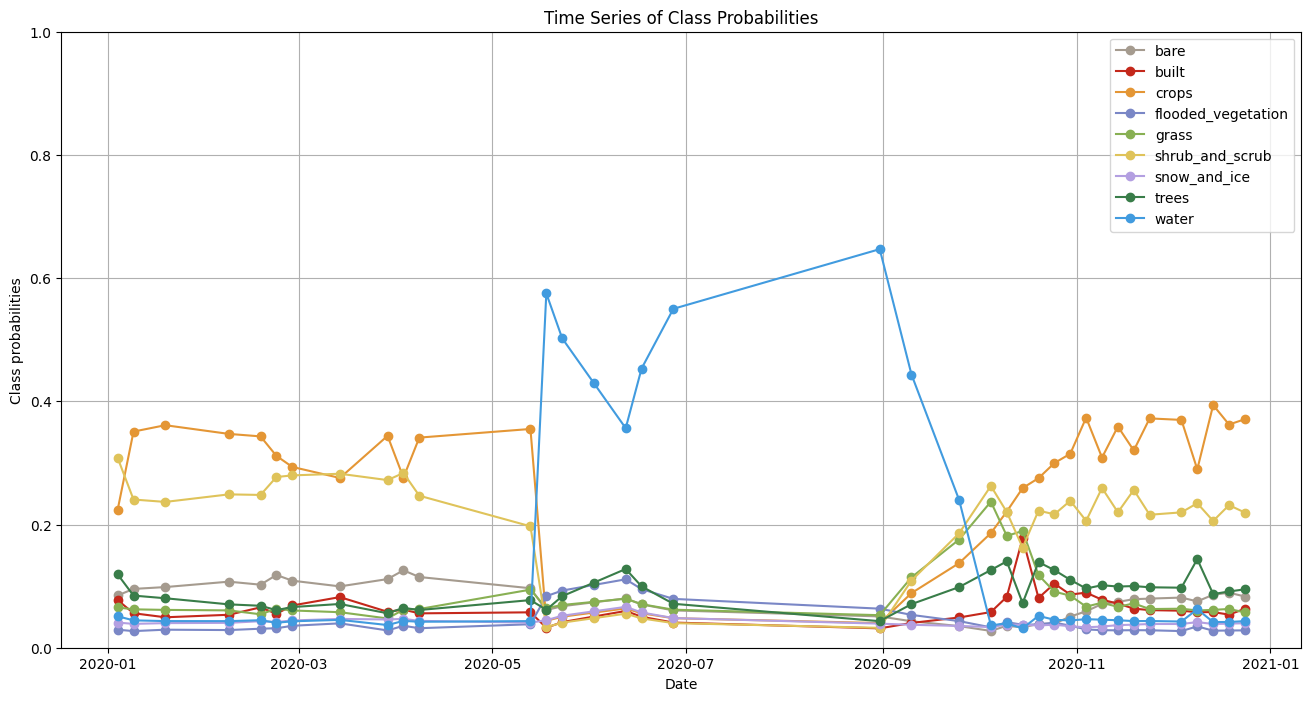

In [ ]:
# Define the band names and their colors.
bands = ['bare', 'built', 'crops', 'flooded_vegetation', 'grass', 'shrub_and_scrub', 'snow_and_ice', 'trees', 'water']
colors = ['#A59B8F', '#C4281B', '#E49635', '#7A87C6', '#88B053', '#DFC35A', '#B39FE1', '#397D49', '#419BDF']

# Extract the time series data.
def extract_time_series(image):
    mean_values = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_geometry,
        scale=10
    )
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        **{band: mean_values.get(band) for band in bands}
    })

time_series = dw_time_series.map(extract_time_series).getInfo()

# Convert the extracted data to a DataFrame.
data = []
for feature in time_series['features']:
    properties = feature['properties']
    row = {'date': properties.pop('date')}
    row.update({band: properties.get(band) for band in bands})
    data.append(row)

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Interpolate missing values to ensure continuous lines.
df_interpolated = df.interpolate(method='linear')

# Plot the time series.
plt.figure(figsize=(16, 8))
for i, band in enumerate(bands):
    plt.plot(df_interpolated['date'], df_interpolated[band], label=band, color=colors[i], marker='o', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Class probabilities')
plt.title('Time Series of Class Probabilities')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

### Change Detection using probability band

In [ ]:
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
selected = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Bangalore Urban'))
geometry = selected.geometry()

Map = geemap.Map()

Map.centerObject(ee_geometry, 12)

In [ ]:
BEFORE = 2015
AFTER = 2020

B_START = ee.Date.fromYMD(BEFORE, 1, 1)
B_END = B_START.advance(1, 'year')

A_START = ee.Date.fromYMD(AFTER, 1, 1)
A_END = A_START.advance(1, 'year')

In [ ]:
dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterBounds(ee_geometry)
      .select('built'))

BEFORE_dw = dw.filterDate(B_START, B_END).mean()
AFTER_dw = dw.filterDate(A_START, A_END).mean()

In [ ]:
# select all pixels that are
#       < 0.2 'built' probability before
#       > 0.5 'built probability after
new_urban = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

change_vis_params = {
    'min': 0,
    'max':1,
    'palette': ['white', 'red']
}

Map.add_layer(new_urban.clip(ee_geometry), change_vis_params, "New Urban")

In [ ]:
# Red pixels Indicating Detected Urban Sprawl between 2019 and 2020
Map

Map(bottom=4019226.0, center=[7.504855034726597, 38.76852034795315], controls=(WidgetControl(options=['positio…

In [ ]:
BEFORE = 2019
AFTER = 2022

B_START = ee.Date.fromYMD(BEFORE, 1, 1)
B_END = B_START.advance(1, 'year')

A_START = ee.Date.fromYMD(AFTER, 1, 1)
A_END = A_START.advance(1, 'year')

admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
selected = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Bangalore Urban'))
geometry = selected.geometry()

s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# FUnction
def change_detection_using_prob_band(class_name, color) -> geemap.Map:
    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometry)
          .select(class_name))

    BEFORE_dw = dw.filterDate(B_START, B_END).mean()
    AFTER_dw = dw.filterDate(A_START, A_END).mean()

    # select all pixels that are
    #       < 0.2 'built' probability before
    #       > 0.5 'built probability after
    new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

    # Calculate the pixels
    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    )

    total_area_result = total_area.getInfo()
    print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

    change_vis_params = {
        'min': 0,
        'max':1,
        'palette': ['white', color]
    }

    Map.centerObject(geometry, 12)
    Map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
    Map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')
    Map.add_layer(new_area.selfMask().clip(geometry), change_vis_params, "New Urban")

    return Map

Map = geemap.Map()
change_detection_using_prob_band('built', 'red')

Total area of new built regions: 21.210 square km


Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"
Map = geemap.Map()
change_detection_using_prob_band('trees', 'green')

Total area of new trees regions: 5.709 square km


Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"

Map = geemap.Map()
change_detection_using_prob_band('crops', 'yellow')

Total area of new crops regions: 0.401 square km


Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"

Map = geemap.Map()
change_detection_using_prob_band('water', 'blue')

Total area of new water regions: 5.963 square km


Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

## Change detection for every class and combine them in one map (to use later)

In [ ]:
BEFORE = 2019
AFTER = 2022

B_START = ee.Date.fromYMD(BEFORE, 1, 1)
B_END = B_START.advance(1, 'year')

A_START = ee.Date.fromYMD(AFTER, 1, 1)
A_END = A_START.advance(1, 'year')

admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
selected = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Bangalore Urban'))
geometry = selected.geometry()

s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# Function to detect change and add it to the map
def change_detection_using_prob_band(class_name, color):
    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometry)
          .select(class_name))

    BEFORE_dw = dw.filterDate(B_START, B_END).mean()
    AFTER_dw = dw.filterDate(A_START, A_END).mean()

    new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    )

    total_area_result = total_area.getInfo()
    print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

    change_vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['#ffffff', color]
    }

    Map.addLayer(new_area.selfMask().clip(geometry), change_vis_params, f"New {class_name.capitalize()}")

# Create a map
Map = geemap.Map()

# Add the Sentinel-2 imagery layers
Map.centerObject(geometry, 12)
Map.addLayer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
Map.addLayer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')

# Define the classes and their corresponding colors
# bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"
classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Apply change detection for each class
for class_name, color in classes_colors.items():
    change_detection_using_prob_band(class_name, color)

# Display the map
Map

Total area of new water regions: 21.210 square km
Total area of new trees regions: 21.210 square km
Total area of new grass regions: 21.210 square km
Total area of new flooded_vegetation regions: 21.210 square km
Total area of new crops regions: 21.210 square km
Total area of new shrub_and_scrub regions: 21.210 square km
Total area of new built regions: 21.210 square km
Total area of new bare regions: 21.210 square km
Total area of new snow_and_ice regions: 21.210 square km


Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

#### Decision tree

In [ ]:
# Define decision tree rules.
# Rule 1: Built probability < 0.2 before and > 0.5 after
rule1 = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

# Rule 2: Built probability < 0.1 before and > 0.4 after
rule2 = BEFORE_dw.lt(0.1).And(AFTER_dw.gt(0.4))

# Combine rules using logical OR.
new_urban_dt = rule1.Or(rule2)

Map = geemap.Map()

# Visualize the change.
change_vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}
Map.addLayer(new_urban_dt.selfMask().clip(geometry), change_vis_params, "New Urban Areas")

# Display the map.
Map.centerObject(geometry, 12)
Map

Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

#### Change detection for each class

In [ ]:
# Define the region of interest.
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
selected = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Bangalore Urban'))
geometry = selected.geometry()

# Define the time periods.
BEFORE = 2019
AFTER = 2020

B_START = ee.Date.fromYMD(BEFORE, 1, 1)
B_END = B_START.advance(1, 'year')
A_START = ee.Date.fromYMD(AFTER, 1, 1)
A_END = A_START.advance(1, 'year')

# Load the dataset.
image = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterBounds(geometry)


def change_detection(target_class) -> geemap.Map:
    # Ensure the target class is valid.
    class_names = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
    if target_class not in class_names:
        raise ValueError(f"Invalid class name. Choose from {class_names}")

    # Select the target class band for after periods.
    AFTER_target = image.filterDate(A_START, A_END).select(target_class).median()

    # Define decision tree rules for change detection.
    changes = {}
    for class_name in class_names:
        if class_name != target_class:
            BEFORE_class = image.filterDate(B_START, B_END).select(class_name).median()
            presence_check = BEFORE_class.gt(0.5).reduceRegion(reducer=ee.Reducer.sum(), geometry=geometry, scale=30).getInfo()
            if presence_check[class_name] > 0:  # Only include classes that are present in the before period
                rule = BEFORE_class.gt(0.5).And(AFTER_target.gt(0.7))
                changes[class_name] = rule

    # Calculate the change areas for each class.
    change_areas = {}
    for class_name, change in changes.items():
        change_area = change.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(), geometry=geometry, scale=30).getInfo()
        change_areas[f'{class_name}_to_{target_class}'] = list(change_area.values())[0]/ 1e6  # Convert to square kilometers

    # Output the change counts.
    for transition, area in change_areas.items():
        print(f'{transition}: {area:.4f} square kilometers')

    # Visualization
    class_colors = {
        'water': '#419bdf',
        'trees': '#397d49',
        'grass': '#88b053',
        'flooded_vegetation': '#7a87c6',
        'crops': '#e59635',
        'shrub_and_scrub': '#dfc35a',
        'built': '#c4281b',
        'bare': '#a59b8f',
        'snow_and_ice': '#b39fe1',
        'no_change': '#D3D3D3'
    }

    # Combine all changes into a single image with different colors for each change.
    change_combined = ee.Image(0)
    for i, (class_name, rule) in enumerate(changes.items()):
        change_combined = change_combined.add(rule.multiply(i + 1))

    # Define visualization parameters with a unique color for each class change including no change.
    change_vis_params = {
        'min': 0,
        'max': len(class_names) + 1,
        'palette': [class_colors['no_change']] + [class_colors[class_name] for class_name in class_names if class_name != target_class]
    }
    Map.addLayer(change_combined.selfMask().clip(geometry), change_vis_params, f"Changes to {target_class}")
    Map.add_legend(title=f"Changes to {target_class}", legend_dict={class_names[i]: class_colors[class_names[i]] for i in range(len(class_names)) if class_names[i] != target_class})

    return change_combined

In [ ]:
# Create a map.
Map = geemap.Map()
Map.centerObject(geometry, 12)

new_urban_area = change_detection('built')

In [ ]:
# Create a map.
Map = geemap.Map()
Map.centerObject(geometry, 12)

change_detection('crops')

water_to_crops: 0.0000 square kilometers
trees_to_crops: 0.1987 square kilometers
grass_to_crops: 0.0044 square kilometers
flooded_vegetation_to_crops: 0.0000 square kilometers
shrub_and_scrub_to_crops: 0.7101 square kilometers
built_to_crops: 0.0549 square kilometers
bare_to_crops: 0.0139 square kilometers


In [ ]:
# Create a map.
Map = geemap.Map()
Map.centerObject(geometry, 12)

change_detection('water')

trees_to_water: 0.0689 square kilometers
grass_to_water: 0.0514 square kilometers
flooded_vegetation_to_water: 0.1008 square kilometers
crops_to_water: 1.1604 square kilometers
shrub_and_scrub_to_water: 0.7065 square kilometers
built_to_water: 0.2092 square kilometers
bare_to_water: 0.6566 square kilometers


Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

### Validate the change

In [ ]:
s2 = (ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(geometry)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

BEFORE_S2 = s2.filterDate(B_START, B_END).median()
AFTER_S2 = s2.filterDate(A_START, A_END).median()

s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

# Visualize the change.
change_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['white', 'red']
}

S2_map = geemap.Map()
S2_map.add_layer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2')
S2_map.add_layer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2')
S2_map.add_layer(new_urban_area.selfMask().clip(geometry), change_vis_params, "new urban (masked)")

S2_map.centerObject(geometry, 12)
S2_map

Map(center=[12.942208526432214, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

# **EVERY** Area affected with the disaster

## Disaster dataset

In [ ]:
disasters_df = pd.read_csv(Disasters_in_africa_2000_2018_processed_PATH)
disasters_df.tail(10)

disasterno  Country  Location Disaster type        Date  Year  \
43365  2018-0479  Burundi   Vugizo          Flood  2018-04-05  2018   
43366  2018-0479  Burundi   Gatumba         Flood  2018-04-05  2018   
43367  2018-0479  Burundi   Vugizo          Flood  2018-04-05  2018   
43368  2018-0479  Burundi   Gatumba         Flood  2018-04-05  2018   
43369  2018-0479  Burundi   Vugizo          Flood  2018-04-05  2018   
43370  2018-0479  Burundi   Gatumba         Flood  2018-04-05  2018   
43371  2018-0479  Burundi   Vugizo          Flood  2018-04-05  2018   
43372  2018-0479  Burundi   Gatumba         Flood  2018-04-05  2018   
43373  2018-0479  Burundi   Vugizo          Flood  2018-04-05  2018   
43374  2018-0479  Burundi   Gatumba         Flood  2018-04-05  2018   

       Total deaths  Latitude  Longitude  
43365           0.0 -4.153846  29.678495  
43366           0.0 -3.312979  29.242054  
43367           0.0 -4.153846  29.678495  
43368           0.0 -3.312979  29.242054  
43369           0.0 -4.153846  29.678495  
43370           0.0 -3.312979  29.242054  
43371           0.0 -4.153846  29.678495  
43372           0.0 -3.312979  29.242054  
43373           0.0 -4.153846  29.678495  
43374           0.0 -3.312979  29.242054

In [ ]:
disasters_df = disasters_df.drop_duplicates(subset=['Latitude', 'Longitude', 'Location', 'Date'])
disasters_df.tail(10)

disasterno  Country        Location Disaster type        Date  Year  \
43118  2018-0441     Mali         Essouk          Flood  2018-07-08  2018   
43119  2018-0441     Mali       Toubakoro         Flood  2018-07-08  2018   
43120  2018-0441     Mali      Kita city          Flood  2018-07-08  2018   
43121  2018-0441     Mali            DirŽ         Flood  2018-07-08  2018   
43122  2018-0441     Mali   Kolokani town         Flood  2018-07-08  2018   
43123  2018-0441     Mali          Bourem         Flood  2018-07-08  2018   
43124  2018-0441     Mali        Ansongo          Flood  2018-07-08  2018   
43125  2018-0441     Mali        Koutiala         Flood  2018-07-08  2018   
43357  2018-0479  Burundi         Vugizo          Flood  2018-04-05  2018   
43358  2018-0479  Burundi         Gatumba         Flood  2018-04-05  2018   

       Total deaths   Latitude  Longitude  
43118           0.0  18.893157   1.218231  
43119           0.0  13.431880  -7.324007  
43120           0.0  13.230625  -9.434046  
43121           0.0  16.254182  -3.325092  
43122           0.0  13.781483  -8.160191  
43123           0.0  17.745920  -0.393154  
43124           0.0  15.665245   0.667665  
43125           0.0  12.388203  -5.559947  
43357           0.0  -4.153846  29.678495  
43358           0.0  -3.312979  29.242054

In [ ]:
start_date = pd.to_datetime('27/6/2015', dayfirst=True) # Define the start date

# Convert 'Date' column to datetime
disasters_df['Date'] = pd.to_datetime(disasters_df['Date'], dayfirst=True, errors='coerce', infer_datetime_format=True)
disasters_filtered_df = disasters_df[disasters_df['Date'] >= start_date]

# Drop rows where 'Date' is NaT (if any)
disasters_filtered_df = disasters_filtered_df.dropna(subset=['Date']).reset_index(drop=True)
disasters_filtered_df

disasterno       Country               Location Disaster type       Date  \
0    2015-0337          Mali       Menaka district          Flood 2015-08-08   
1    2015-0346  Burkina Faso   Bobo-Dioulasso city          Flood 2015-08-04   
2    2015-0346  Burkina Faso             Kenedougou         Flood 2015-08-04   
3    2015-0346  Burkina Faso         Tuy districts          Flood 2015-08-04   
4    2015-0346  Burkina Faso            Ouagadougou         Flood 2015-08-04   
..         ...           ...                    ...           ...        ...   
372  2018-0441          Mali                 Bourem         Flood 2018-08-07   
373  2018-0441          Mali               Ansongo          Flood 2018-08-07   
374  2018-0441          Mali               Koutiala         Flood 2018-08-07   
375  2018-0479       Burundi                Vugizo          Flood 2018-05-04   
376  2018-0479       Burundi                Gatumba         Flood 2018-05-04   

     Year  Total deaths   Latitude  Longitude  
0    2015           5.0  16.692050   2.778745  
1    2015           8.0  11.174258  -4.282161  
2    2015           8.0  11.424027  -4.978683  
3    2015           8.0  11.439538  -3.518757  
4    2015           8.0  12.373680  -1.536980  
..    ...           ...        ...        ...  
372  2018           0.0  17.745920  -0.393154  
373  2018           0.0  15.665245   0.667665  
374  2018           0.0  12.388203  -5.559947  
375  2018           0.0  -4.153846  29.678495  
376  2018           0.0  -3.312979  29.242054  

[377 rows x 9 columns]

In [ ]:
Disasters_in_africa_2015_2018_processed_PATH = "data/processed/Disasters_in_africa_2015_2018_processed.csv"
disasters_filtered_df.to_csv(Disasters_in_africa_2015_2018_processed_PATH)

In [ ]:
disasters_filtered_df['Disaster type'].unique()

array(['Flood', 'Storm', 'Drought', 'Earthquake'], dtype=object)

In [ ]:
import pandas as pd
from shapely.geometry import Point, mapping
import geopandas as gpd

# Define the approximate radii for each disaster type (in degrees)
radii = {
    'Flood': 10 ,
    'Storm': 50 ,
    'Drought': 200 ,
    'Earthquake': 30
}

# Add the radius to the DataFrame
disasters_filtered_df['Radius'] = disasters_filtered_df['Disaster type'].map(radii)

# Ensure all radius values are valid
if disasters_filtered_df['Radius'].isnull().any():
    raise ValueError("Some disaster types do not have assigned radii")

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(disasters_filtered_df.Longitude, disasters_filtered_df.Latitude)]
gdf = gpd.GeoDataFrame(disasters_filtered_df, geometry=geometry, crs="EPSG:4326")

# Create buffers around each point
gdf['geometry'] = gdf.apply(lambda row: row.geometry.buffer(row.Radius), axis=1)

In [ ]:
# Save the GeoDataFrame to a CSV file
Disasters_in_africa_2015_2018_processed_PATH = "data/processed/Disasters_in_africa_2015_2018_processed.csv"
gdf['geometry'] = gdf['geometry'].apply(lambda x: mapping(x))
gdf.to_csv(Disasters_in_africa_2015_2018_processed_PATH, index=False)

In [ ]:
gdf

disasterno       Country               Location Disaster type       Date  \
0    2015-0337          Mali       Menaka district          Flood 2015-08-08   
1    2015-0346  Burkina Faso   Bobo-Dioulasso city          Flood 2015-08-04   
2    2015-0346  Burkina Faso             Kenedougou         Flood 2015-08-04   
3    2015-0346  Burkina Faso         Tuy districts          Flood 2015-08-04   
4    2015-0346  Burkina Faso            Ouagadougou         Flood 2015-08-04   
..         ...           ...                    ...           ...        ...   
372  2018-0441          Mali                 Bourem         Flood 2018-08-07   
373  2018-0441          Mali               Ansongo          Flood 2018-08-07   
374  2018-0441          Mali               Koutiala         Flood 2018-08-07   
375  2018-0479       Burundi                Vugizo          Flood 2018-05-04   
376  2018-0479       Burundi                Gatumba         Flood 2018-05-04   

     Year  Total deaths   Latitude  Longitude   Radius  \
0    2015           5.0  16.692050   2.778745  0.09009   
1    2015           8.0  11.174258  -4.282161  0.09009   
2    2015           8.0  11.424027  -4.978683  0.09009   
3    2015           8.0  11.439538  -3.518757  0.09009   
4    2015           8.0  12.373680  -1.536980  0.09009   
..    ...           ...        ...        ...      ...   
372  2018           0.0  17.745920  -0.393154  0.09009   
373  2018           0.0  15.665245   0.667665  0.09009   
374  2018           0.0  12.388203  -5.559947  0.09009   
375  2018           0.0  -4.153846  29.678495  0.09009   
376  2018           0.0  -3.312979  29.242054  0.09009   

                                              geometry  
0    {'type': 'Polygon', 'coordinates': (((2.868835...  
1    {'type': 'Polygon', 'coordinates': (((-4.19207...  
2    {'type': 'Polygon', 'coordinates': (((-4.88859...  
3    {'type': 'Polygon', 'coordinates': (((-3.42866...  
4    {'type': 'Polygon', 'coordinates': (((-1.44688...  
..                                                 ...  
372  {'type': 'Polygon', 'coordinates': (((-0.30306...  
373  {'type': 'Polygon', 'coordinates': (((0.757754...  
374  {'type': 'Polygon', 'coordinates': (((-5.46985...  
375  {'type': 'Polygon', 'coordinates': (((29.76858...  
376  {'type': 'Polygon', 'coordinates': (((29.33214...  

[377 rows x 11 columns]

In [ ]:
# Function to extract coordinates by date.
def get_coordinates_by_date(feature_collection, date):
    # Filter the feature collection by the specified date.
    filtered = feature_collection.filter(ee.Filter.eq('date', date))
    # Get the first feature from the filtered collection.
    feature = filtered.first()
    # Get the coordinates of the feature.
    coordinates = feature.geometry().coordinates().getInfo()
    return coordinates

# Function to create a buffer around coordinates.
def create_buffer_around_coordinates(coordinates, buffer_type='circle', buffer_size=1.0):
    point = ee.Geometry.Point(coordinates)
    if buffer_type == 'circle':
        buffer = point.buffer(buffer_size * 1000)  # buffer size in meters
    elif buffer_type == 'square':
        buffer = point.bounds().buffer(buffer_size * 1000 / 2).bounds()  # buffer size in meters
    else:
        raise ValueError("buffer_type must be either 'circle' or 'square'")
    return buffer

# Function to clip the ImageCollection with the buffer.
def clip_image_collection_with_buffer(image_collection, buffer):
    return image_collection.map(lambda image: image.clip(buffer))

In [ ]:
collections

In [ ]:
# Load the FeatureCollection and ImageCollection.
image_collection = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

date = '2015-08-04'
coordinates = get_coordinates_by_date(collections, date)
if coordinates:
    buffer_type = 'square'
    buffer_size = 50.0 # Adjust buffer size as needed (in kilometers)
    buffer = create_buffer_around_coordinates(coordinates, buffer_type, buffer_size)
    clipped_image_collection = clip_image_collection_with_buffer(image_collection, buffer)

    # Create a map.
    map_ = geemap.Map(center=(coordinates[1], coordinates[0]), zoom=10)

    # Add the original image collection to the map.
    map_.addLayer(image_collection.median(), {}, 'Original Image Collection')

    # Add the clipped image collection to the map.
    map_.addLayer(clipped_image_collection.median(), {}, 'Clipped Image Collection')

    # Display the map.
    map_.addLayerControl()
    # Display the map.
    display(map_)
else:
    print(f"No coordinates found for date {date}")

Map(center=[11.17425821, -4.282160591], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

In [ ]:
# Function to filter the feature collection by date.
def filter_features_by_date(feature_collection, date):
    filtered = feature_collection.filter(ee.Filter.eq('date', date))
    return filtered

# Function to create buffers around the features.
def create_buffers_around_features(feature_collection, buffer_type='circle', buffer_size=1.0):
    def create_buffer(feature):
        geometry = feature.geometry()
        if buffer_type == 'circle':
            buffer = geometry.buffer(buffer_size * 1000)  # buffer size in meters
        elif buffer_type == 'square':
            buffer = geometry.bounds().buffer(buffer_size * 1000 / 2).bounds()  # buffer size in meters
        else:
            raise ValueError("buffer_type must be either 'circle' or 'square'")
        return ee.Feature(buffer)
    return feature_collection.map(create_buffer)

# Function to clip the ImageCollection with the buffers.
def clip_image_collection_with_buffers(image_collection, buffer_collection):
    buffer_union = buffer_collection.geometry().dissolve(ee.ErrorMargin(1))  # specify an error margin
    return image_collection.map(lambda image: image.clip(buffer_union))

# Load the FeatureCollection and ImageCollection.
image_collection = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Example usage.
date = '2015-08-04'
filtered_features = filter_features_by_date(collections, date)
if filtered_features.size().getInfo() > 0:
    buffer_type = 'square'  # or 'square'
    buffer_size = 30.0  # Adjust buffer size as needed (in kilometers)
    buffers = create_buffers_around_features(filtered_features, buffer_type, buffer_size)
    clipped_image_collection = clip_image_collection_with_buffers(image_collection, buffers)

    # Create a map.
    map_ = geemap.Map()

    # Add the original image collection to the map.
    map_.addLayer(image_collection.median(), {}, 'Original Image Collection')

    # Add the clipped image collection to the map.
    map_.addLayer(clipped_image_collection.median(), {}, 'Clipped Image Collection')

    # Add the filtered features to the map.
    map_.addLayer(filtered_features, {'color': 'red'}, 'Filtered Features')

    # Add layer control to the map.
    map_.addLayerControl()

    # Center the map on the filtered features.
    map_.centerObject(filtered_features, zoom=10)

    # Display the map.
    display(map_)
else:
    print(f"No features found for date {date}")

Map(center=[11.355134569319357, -3.7797149076401206], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# Function to filter the feature collection by date.
def filter_features_by_date(feature_collection, date):
    filtered = feature_collection.filter(ee.Filter.eq('date', date))
    return filtered

# Function to create buffers around the features.
def create_buffers_around_features(feature_collection, buffer_type='square', buffer_size=1.0):
    def create_buffer(feature):
        geometry = feature.geometry()
        if buffer_type == 'square':
            buffer = geometry.bounds().buffer(buffer_size * 1000 / 2, ee.ErrorMargin(1))  # buffer size in meters, with error margin
        else:
            raise ValueError("buffer_type must be either 'circle' or 'square'")
        return ee.Feature(buffer)
    return feature_collection.map(create_buffer)

# Function to clip the ImageCollection with the buffers.
def clip_image_collection_with_buffers(image_collection, buffer_collection):
    buffer_union = buffer_collection.geometry().dissolve(ee.ErrorMargin(1))  # specify an error margin
    return image_collection.map(lambda image: image.clip(buffer_union))

# Function to add EE image layers to the map.
def add_ee_layer(self, ee_image_object, vis_params, name) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Function to perform change detection and add it to the map.
def change_detection_using_prob_band(class_name, color, geometry, date):
    # Calculate date ranges.
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    before_start = date_obj - timedelta(days=60)
    before_end = date_obj - timedelta(days=1)
    after_start = date_obj + timedelta(days=1)
    after_end = date_obj + timedelta(days=61)

    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometry)
          .select(class_name))

    before_dw = dw.filterDate(before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')).mean()
    after_dw = dw.filterDate(after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')).mean()

    # Check if the images are not empty
    if before_dw.bandNames().size().getInfo() == 0 or after_dw.bandNames().size().getInfo() == 0:
        print(f"No data available for the specified date ranges.")
        return

    new_area = before_dw.lt(0.2).And(after_dw.gt(0.5))

    # Calculate the pixels.
    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )

    total_area_result = total_area.getInfo()
    print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

    change_vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['#ffffff', color]
    }

    map_.centerObject(geometry, 8)
    map_.addLayer(new_area.selfMask().clip(geometry), change_vis_params, f"New {class_name}")


# Load the FeatureCollection and ImageCollection.
image_collection = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Example usage.
date = '2018-08-07'
filtered_features = filter_features_by_date(collections, date)
if filtered_features.size().getInfo() > 0:
    buffer_type = 'square'  # or 'circle'
    buffer_size = 5.0  # Adjust buffer size as needed (in kilometers)
    buffers = create_buffers_around_features(filtered_features, buffer_type, buffer_size)
    clipped_image_collection = clip_image_collection_with_buffers(image_collection, buffers)

    # Create a map.
    map_ = geemap.Map()

    # Add the original image collection to the map.
    map_.addLayer(image_collection.median(), {}, 'Original Image Collection')

    # Add the clipped image collection to the map.
    map_.addLayer(clipped_image_collection.median(), {}, 'Clipped Image Collection')

    # Add the filtered features to the map.
    map_.addLayer(filtered_features, {'color': 'red'}, 'Filtered Features')

    # Add layer control to the map.
    map_.addLayerControl()

    # Center the map on the filtered features.
    map_.centerObject(filtered_features, zoom=10)

    # Perform change detection and add the results to the map.
    change_detection_using_prob_band('water', '#0000ff', buffers.geometry(), date)

    # Display the map.
    display(map_)
else:
    print(f"No features found for date {date}")

Total area of new water regions: 2.279 square km


Map(center=[15.34315368509877, -3.719962500077376], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Function to filter the feature collection by date.
def filter_features_by_date(feature_collection, date):
    filtered = feature_collection.filter(ee.Filter.eq('date', date))
    return filtered

# Function to create buffers around the features.
def create_buffers_around_features(feature_collection, buffer_type='circle', buffer_size=1.0):
    def create_buffer(feature):
        geometry = feature.geometry()
        if buffer_type == 'circle':
            buffer = geometry.buffer(buffer_size * 1000)  # buffer size in meters
        elif buffer_type == 'square':
            buffer = geometry.bounds().buffer(buffer_size * 1000 / 2, ee.ErrorMargin(1))  # buffer size in meters, with error margin
        else:
            raise ValueError("buffer_type must be either 'circle' or 'square'")
        return ee.Feature(buffer)
    return feature_collection.map(create_buffer)

# Function to clip the ImageCollection with the buffers.
def clip_image_collection_with_buffers(image_collection, buffer_collection):
    buffer_union = buffer_collection.geometry().dissolve(ee.ErrorMargin(1))  # specify an error margin
    return image_collection.map(lambda image: image.clip(buffer_union))

# Function to perform change detection and calculate change for each buffer.
def change_detection_for_each_class(classes_colors, buffer_collection, date):
    # Calculate date ranges.
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    before_start = date_obj - timedelta(days=60)
    before_end = date_obj - timedelta(days=1)
    after_start = date_obj + timedelta(days=1)
    after_end = date_obj + timedelta(days=60)  # Add 1 day to ensure non-empty date range

    total_areas = {class_name: 0 for class_name in classes_colors}
    change_detected_counts = {class_name: 0 for class_name in classes_colors}

    buffer_list = buffer_collection.toList(buffer_collection.size())
    buffer_count = buffer_collection.size().getInfo()

    def calculate_change(buffer, class_name, color):
        nonlocal total_areas, change_detected_counts
        buffer = ee.Feature(buffer)
        dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
              .filterBounds(buffer.geometry())
              .select(class_name))
        before_dw = dw.filterDate(before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')).mean()
        after_dw = dw.filterDate(after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')).mean()

        # Check if the images are not empty
        if before_dw.bandNames().size().getInfo() == 0 or after_dw.bandNames().size().getInfo() == 0:
            print(f"No data available for {class_name} in the specified date ranges.")
            return

        new_area = before_dw.lt(0.2).And(after_dw.gt(0.5))

        # Calculate the pixels.
        pixel_area = ee.Image.pixelArea()
        new_area_pixels = new_area.multiply(pixel_area)
        total_area = new_area_pixels.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=buffer.geometry(),
            scale=10,
            maxPixels=1e9,
            bestEffort=True
        )

        total_area_result = total_area.getInfo()
        new_area_km2 = list(total_area_result.values())[0] / 1e6 if total_area_result else 0
        if new_area_km2 > 0:
            change_detected_counts[class_name] += 1
            map_.addLayer(new_area.selfMask().clip(buffer.geometry()), {'min': 0, 'max': 1, 'palette': [color]}, f"New {class_name} in Buffer {change_detected_counts[class_name]}")
        total_areas[class_name] += new_area_km2
        print(f"New {class_name} area in buffer: {new_area_km2:.3f} square km")

    for i in range(buffer_count):
        buffer = buffer_list.get(i)
        for class_name, color in classes_colors.items():
            calculate_change(buffer, class_name, color)

    for class_name, total_area in total_areas.items():
        print(f"Total new {class_name} area across all buffers: {total_area:.3f} square km")
        print(f"Number of areas where change was detected for {class_name}: {change_detected_counts[class_name]}")

    return total_areas, change_detected_counts

# Load the FeatureCollection and ImageCollection.
image_collection = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Example usage.
date = '2018-08-07'
filtered_features = filter_features_by_date(collections, date)
if filtered_features.size().getInfo() > 0:
    buffer_type = 'square'  # or 'circle'
    buffer_size = 3.0  # Adjust buffer size as needed (in kilometers)
    buffers = create_buffers_around_features(filtered_features, buffer_type, buffer_size)
    clipped_image_collection = clip_image_collection_with_buffers(image_collection, buffers)

    # Create a map.
    map_ = geemap.Map()

    # Add the original image collection to the map.
    map_.addLayer(image_collection.median(), {}, 'Original Image Collection')

    # Add the clipped image collection to the map.
    map_.addLayer(clipped_image_collection.median(), {}, 'Clipped Image Collection')

    # Add the filtered features to the map.
    map_.addLayer(filtered_features, {'color': 'red'}, 'Filtered Features')

    # Add layer control to the map.
    map_.addLayerControl()

    # Center the map on the filtered features.
    map_.centerObject(filtered_features, zoom=10)

    # Perform change detection and calculate change for each class.
    classes_colors = {
        'water': '#419bdf',
        'trees': '#397d49',
        'grass': '#88b053',
        'flooded_vegetation': '#7a87c6',
        'crops': '#e59635',
        'shrub_and_scrub': '#dfc35a',
        'built': '#c4281b',
        'bare': '#a59b8f',
        'snow_and_ice': '#b39fe1'
    }
    total_areas, change_detected_counts = change_detection_for_each_class(classes_colors, buffers, date)

    # Display the map.
    display(map_)
else:
    print(f"No features found for date {date}")

New water area in buffer: 0.000 square km
New trees area in buffer: 0.000 square km
New grass area in buffer: 0.000 square km
New flooded_vegetation area in buffer: 0.000 square km
New crops area in buffer: 0.000 square km
New shrub_and_scrub area in buffer: 0.000 square km
New built area in buffer: 0.000 square km
New bare area in buffer: 0.000 square km
New snow_and_ice area in buffer: 0.000 square km
New water area in buffer: 0.982 square km
New trees area in buffer: 0.000 square km
New grass area in buffer: 0.000 square km
New flooded_vegetation area in buffer: 0.000 square km
New crops area in buffer: 0.000 square km
New shrub_and_scrub area in buffer: 0.000 square km
New built area in buffer: 0.000 square km
New bare area in buffer: 0.000 square km
New snow_and_ice area in buffer: 0.000 square km
New water area in buffer: 0.000 square km
New trees area in buffer: 0.106 square km
New grass area in buffer: 0.000 square km
New flooded_vegetation area in buffer: 0.000 square km
New c

KeyboardInterrupt: 

# Calculate change detection for real

In [ ]:
collections = feature2ee(Disasters_in_africa_2015_2018_processed_PATH)

CSV file converted successfully.


In [ ]:
collections

In [ ]:
# Function to filter the feature collection by date.
def filter_features_by_date(feature_collection, date):
    filtered = feature_collection.filter(ee.Filter.eq('date', date))
    return filtered

# Function to create square buffers around the features based on disaster type.
def create_square_buffers_around_features(feature_collection, buffer_sizes):
    def create_square_buffer(feature):
        disaster_type = ee.String(feature.get('disaster_type'))
        buffer_size = ee.Number(buffer_sizes.get(disaster_type, 1.0)).multiply(1000)  # buffer size in meters
        half_size = buffer_size.divide(2)
        centroid = feature.geometry().centroid()
        buffer = ee.Geometry.Rectangle([
            centroid.translate(-half_size, -half_size),
            centroid.translate(half_size, half_size)
        ])
        return feature.setGeometry(buffer)
    return feature_collection.map(create_square_buffer)

# Function to clip the ImageCollection with the buffers.
def clip_image_collection_with_buffers(image_collection, buffer_collection):
    buffer_union = buffer_collection.geometry().dissolve(ee.ErrorMargin(1))  # specify an error margin
    return image_collection.map(lambda image: image.clip(buffer_union))

# Function to perform change detection and calculate change for each buffer.
def change_detection_for_each_class(classes_colors, buffer_collection, date):
    # Calculate date ranges.
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    before_start = date_obj - timedelta(days=60)
    before_end = date_obj - timedelta(days=1)
    after_start = date_obj + timedelta(days=1)
    after_end = date_obj + timedelta(days=60)  # Add 1 day to ensure non-empty date range

    total_areas = {class_name: 0 for class_name in classes_colors}
    change_detected_counts = {class_name: 0 for class_name in classes_colors}

    buffer_list = buffer_collection.toList(buffer_collection.size())
    buffer_count = buffer_collection.size().getInfo()

    def calculate_change(buffer, class_name, color):
        nonlocal total_areas, change_detected_counts
        buffer = ee.Feature(buffer)
        dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
              .filterBounds(buffer.geometry())
              .select(class_name))
        before_dw = dw.filterDate(before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')).mean()
        after_dw = dw.filterDate(after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')).mean()

        # Check if the images are not empty
        if before_dw.bandNames().size().getInfo() == 0 or after_dw.bandNames().size().getInfo() == 0:
            return

        new_area = before_dw.lt(0.2).And(after_dw.gt(0.5))

        # Calculate the pixels.
        pixel_area = ee.Image.pixelArea()
        new_area_pixels = new_area.multiply(pixel_area)
        total_area = new_area_pixels.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=buffer.geometry(),
            scale=10,
            maxPixels=1e9,
            bestEffort=True
        )

        total_area_result = total_area.getInfo()
        new_area_km2 = list(total_area_result.values())[0] / 1e6 if total_area_result else 0
        if new_area_km2 > 0:
            change_detected_counts[class_name] += 1
        total_areas[class_name] += new_area_km2

    for i in range(buffer_count):
        buffer = buffer_list.get(i)
        for class_name, color in classes_colors.items():
            calculate_change(buffer, class_name, color)

    return total_areas, change_detected_counts

# Function to generate a list of dates within the specified range.
def generate_dates(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    dates = []
    while start <= end:
        dates.append(start.strftime('%Y-%m-%d'))
        start += timedelta(days=1)
    return dates

In [ ]:
# Load the FeatureCollection and ImageCollection.
image_collection = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Generate dates from 2015-08-28 until 2018-12-31.
start_date = '2015-08-28'
end_date = '2019-01-01'
dates = generate_dates(start_date, end_date)

# Define classes and colors.
classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Define buffer sizes based on disaster type.
buffer_sizes = ee.Dictionary({
    'Flood': 30,
    'Storm': 50,
    'Drought': 1,
    'Earthquake': 40
})

# Initialize a list to store results.
results = []

# Loop through each date and perform change detection.
for date in tqdm(dates, desc="Processing dates"):
    filtered_features = filter_features_by_date(collections, date)
    if filtered_features.size().getInfo() > 0:
        buffers = create_square_buffers_around_features(filtered_features, buffer_sizes)
        clipped_image_collection = clip_image_collection_with_buffers(image_collection, buffers)

        # Perform change detection and calculate change for each class.
        total_areas, change_detected_counts = change_detection_for_each_class(classes_colors, buffers, date)

        # Store results.
        for i in range(buffers.size().getInfo()):
            buffer = buffers.toList(buffers.size()).get(i)
            buffer_feature = ee.Feature(buffer)
            country = buffer_feature.get('country').getInfo()
            geometry = buffer_feature.geometry().getInfo()
            coordinates = geometry['coordinates']

            result = {
                'date': date,
                'country': country,
                'buffer_geometry': geometry,
                'disaster_lat_long': coordinates,
            }

            for class_name in classes_colors.keys():
                result[f'{class_name}_area_km2'] = total_areas.get(class_name, 0)
            results.append(result)

# Convert results to DataFrame and save to CSV.
df = pd.DataFrame(results)

Processing dates: 100%|██████████| 1223/1223 [4:12:11<00:00, 12.37s/it]


In [ ]:
df.to_csv("final_results.csv")

In [ ]:
df

date       country  \
0    2015-09-01      Ethiopia   
1    2015-09-01      Ethiopia   
2    2015-09-01      Ethiopia   
3    2015-09-01      Ethiopia   
4    2015-09-05  Sierra Leone   
..          ...           ...   
354  2018-08-07          Mali   
355  2018-08-07          Mali   
356  2018-08-07          Mali   
357  2018-08-07          Mali   
358  2018-08-07          Mali   

                                       buffer_geometry  \
0    {'type': 'Polygon', 'coordinates': [[[38.76095...   
1    {'type': 'Polygon', 'coordinates': [[[43.33133...   
2    {'type': 'Polygon', 'coordinates': [[[40.76393...   
3    {'type': 'Polygon', 'coordinates': [[[38.04282...   
4    {'type': 'Polygon', 'coordinates': [[[-11.8490...   
..                                                 ...   
354  {'type': 'Polygon', 'coordinates': [[[-3.45983...   
355  {'type': 'Polygon', 'coordinates': [[[-8.29493...   
356  {'type': 'Polygon', 'coordinates': [[[-0.52790...   
357  {'type': 'Polygon', 'coordinates': [[[0.532917...   
358  {'type': 'Polygon', 'coordinates': [[[-5.69469...   

                                     disaster_lat_long  water_area_km2  \
0    [[[38.760950024125044, 7.502713361497558], [38...        0.000000   
1    [[[43.33133283412504, 6.914459596497556], [43....        0.000000   
2    [[[40.763934744125045, 12.032957110497561], [4...        0.000000   
3    [[[38.04282013412504, 11.55794066049756], [38....        0.000000   
4    [[[-11.849040056248654, 7.817596173926724], [-...        0.000000   
..                                                 ...             ...   
354  [[[-3.459838784248652, 16.118484724926724], [-...       26.338846   
355  [[[-8.294937337248653, 13.645785074926726], [-...       26.338846   
356  [[[-0.5279002002486525, 17.61022216492672], [-...       26.338846   
357  [[[0.5329178647513474, 15.529547454926725], [0...       26.338846   
358  [[[-5.694693469248652, 12.252505284926723], [-...       26.338846   

     trees_area_km2  grass_area_km2  flooded_vegetation_area_km2  \
0          0.000000         0.00000                     0.000000   
1          0.000000         0.00000                     0.000000   
2          0.000000         0.00000                     0.000000   
3          0.000000         0.00000                     0.000000   
4          0.000000         0.00000                     0.000000   
..              ...             ...                          ...   
354      314.477077         4.70776                     0.000742   
355      314.477077         4.70776                     0.000742   
356      314.477077         4.70776                     0.000742   
357      314.477077         4.70776                     0.000742   
358      314.477077         4.70776                     0.000742   

     crops_area_km2  shrub_and_scrub_area_km2  built_area_km2  bare_area_km2  \
0          0.000000                  0.000000        0.000000       0.000000   
1          0.000000                  0.000000        0.000000       0.000000   
2          0.000000                  0.000000        0.000000       0.000000   
3          0.000000                  0.000000        0.000000       0.000000   
4          0.000000                  0.000000        0.000000       0.000000   
..              ...                       ...             ...            ...   
354        5.206546                  0.014038        9.144567       0.018635   
355        5.206546                  0.014038        9.144567       0.018635   
356        5.206546                  0.014038        9.144567       0.018635   
357        5.206546                  0.014038        9.144567       0.018635   
358        5.206546                  0.014038        9.144567       0.018635   

     snow_and_ice_area_km2  
0                 0.000000  
1                 0.000000  
2                 0.000000  
3                 0.000000  
4                 0.000000  
..                     ...  
354               0.221062  
355               

In [ ]:
df['buffer_geometry'][4]

{'type': 'Polygon',
 'coordinates': [[[-11.849040056248654, 7.817596173926724],
   [-11.579546703751348, 7.817596173926724],
   [-11.579546703751348, 8.088991144073278],
   [-11.849040056248654, 8.088991144073278],
   [-11.849040056248654, 7.817596173926724]]]}

In [ ]:
df['country'][356]

'Mali'

In [ ]:
ee_geometry = ee.Geometry(df['buffer_geometry'][356])

START_DATE = '2015-07-01'
END_DATE = '2015-12-01'

# Filter the ImageCollection by date and bounds
dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
      .filterDate(START_DATE, END_DATE)
      .filterBounds(ee_geometry))

# Select the 'label' band
classification = dw.select('label')

# Create a composite using the mode reducer
dw_composite = classification.reduce(ee.Reducer.mode())

# Identify built area
built_area = dw_composite.eq(6)

# Define visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Create a map
DW_map = geemap.Map()

# Clip the composite and add it to the map
DW_map.addLayer(dw_composite.clip(ee_geometry), dw_vis_params, "Classified Composite")
DW_map.addLayer(built_area.clip(ee_geometry), {}, "Built Area")

# Display the map
DW_map.addLayerControl()
DW_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# something else

# Last update to get results

In [ ]:
# @title Parameters
'''
Disaster type
Flood, Storm, Drought, Earthquake
'''

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7"
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('Disaster type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [ ]:
# Initialize the map
Map_africa = geemap.Map(**africa_map_config)

# Convert the csv file (After preprocessing) into an earth engine feature
collections = feature2ee(Disasters_in_africa_2015_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

CSV file converted successfully.


Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Flood maps

In [ ]:
# Define the ImageCollection.
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Define the date range.
start_date = '2015-06-27'
end_date = '2018-12-31'

# Filter the ImageCollection by date.
gfd_filtered_date = gfd.filterDate(start_date, end_date)

# Filter the ImageCollection by country.
gfd_filtered_country = ee.ImageCollection([])

for country in african_countries:
    country_filtered = gfd_filtered_date.filter(ee.Filter.stringContains('dfo_country', country))
    gfd_filtered_country = gfd_filtered_country.merge(country_filtered)

# Create a map object.
Map = geemap.Map()

# Display the filtered results on the map (example of adding the first image).
first_image = gfd_filtered_country.first()

# Add flood extent layer.
Map.addLayer(
    first_image.select('flooded').selfMask(),
    {'min': 0, 'max': 1, 'palette': ['#ADD8E6']},  # Light blue
    'Flood Extent'
)

# Add flood duration layer.
Map.addLayer(
    first_image.select('duration').selfMask(),
    {'min': 0, 'max': 11, 'palette': ['#FFFFE0', '#FFD700', '#FF4500', '#8B0000']},  # Gradient from yellow to red
    'Flood Duration'
)

# Overlay permanent water layer.
jrc = gfd_filtered_country.select('jrc_perm_water').sum().gte(1)
Map.addLayer(
    jrc.selfMask(),
    {'min': 0, 'max': 1, 'palette': ['#0000FF']},  # Blue
    'Permanent Water'
)

# Set map options and center.
Map.setOptions('HYBRID')
Map.centerObject(first_image, 6)

# Display the map.
Map

Map(center=[-10.364149840196216, 19.009489730182775], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
gfd_filtered_country

In [ ]:
# @title Parameters
# Define the ImageCollection.
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Define the date range.
start_date = '2015-06-27'
end_date = '2018-12-31'

# Filter the ImageCollection by date.
gfd_filtered_date = gfd.filterDate(start_date, end_date)

# List of African countries.
african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cote d\'Ivoire', 'Djibouti', 'Egypt',
    'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea',
    'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
    'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan',
    'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

In [ ]:
# Filter the ImageCollection by country.
gfd_filtered_country = ee.ImageCollection([])

for country in african_countries:
    country_filtered = gfd_filtered_date.filter(ee.Filter.stringContains('dfo_country', country))
    gfd_filtered_country = gfd_filtered_country.merge(country_filtered)

# Create a folium map object with OpenStreetMap tiles.
map_center = [-1.9403, 29.8739]  # Center of Africa for better visualization
m = folium.Map(location=map_center, zoom_start=3, tiles='OpenStreetMap')

# Function to add EE image layers to the map
def add_ee_layer(self, ee_image_object, vis_params, name) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Add each flood event as a layer.
def add_flood_layers(image, map_object) -> None:
    flood_extent = image.select('flooded').selfMask()
    flood_duration = image.select('duration').selfMask()
    permanent_water = image.select('jrc_perm_water').selfMask()

    vis_params_extent = {'min': 0, 'max': 1, 'palette': '566c73'}
    vis_params_duration = {'min': 0, 'max': 11, 'palette': ['FFFFE0', 'FFD700', 'FF4500', '8B0000']}
    vis_params_water = {'min': 0, 'max': 1, 'palette': '0000FF'}

    map_object.add_ee_layer(flood_extent, vis_params_extent, 'Flood Extent')
    map_object.add_ee_layer(flood_duration, vis_params_duration, 'Flood Duration')
    map_object.add_ee_layer(permanent_water, vis_params_water, 'Permanent Water')

# Display one event (Madagascar)
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())
image = ee.Image(image_list.get(0)) # 6 for Madagascar
add_flood_layers(image, m)

# Add layer control.
folium.LayerControl().add_to(m)

# Save and display the map.
m.save('flood_map.html')
m

### Extracting disastes informations

In [ ]:
# get a specific event -> Madagascar 16 march 2018
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())
specific_event = ee.Image(image_list.get(6))
specific_event

In [ ]:
# Get the list of images in the filtered collection.
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())

# Extract properties of interest.
disaster_info = []
for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))
    properties = image.propertyNames().getInfo()
    disaster_id = image.get('system:index').getInfo()
    start_date = image.date().format('YYYY-MM-dd').getInfo()
    end_date = image.get('system:time_end').getInfo()
    countries = image.get('dfo_country').getInfo()

    # Select the 'flooded' band and mask non-flooded areas
    flooded_area = image.select('flooded').selfMask()

    # Calculate the area of the flood extent
    area_flooded = flooded_area.multiply(ee.Image.pixelArea())

    # Summarize the total flooded area using bestEffort
    area_stats = area_flooded.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=flooded_area.geometry(),
        scale=30,
        maxPixels=1e9,
        bestEffort=True
    )

    # Get the flooded area in square meters
    total_flooded_area = area_stats.get('flooded').getInfo()
    area_affected_sq_km = total_flooded_area / 1e6  # Convert to square kilometers

    # Get the coordinates of the affected area
    footprint = image.geometry().getInfo()
    disaster_info.append({
        'Disaster ID': disaster_id,
        'Start Date': start_date,
        'End Date': end_date,
        'Countries': countries,
        'Area Affected (sq km)': area_affected_sq_km,
        'Coordinates': footprint['coordinates']
    })

# Convert to pandas DataFrame for better readability and manipulation.
disaster_df = pd.DataFrame(disaster_info)

In [ ]:
# Function to clean the Disaster ID
def clean_disaster_id(disaster_id):
    # Find the position of 'DFO' and slice from there
    index = disaster_id.find('DFO')
    return disaster_id[index:]

# Apply the cleaning function to the Disaster ID column
disaster_df['Disaster ID'] = disaster_df['Disaster ID'].apply(clean_disaster_id)
disaster_df

Disaster ID  Start Date       End Date  \
0   DFO_4586_From_20180301_to_20180314  2018-03-01  1520985600000   
1   DFO_4602_From_20180428_to_20180501  2018-04-28  1525132800000   
2   DFO_4305_From_20151024_to_20151028  2015-10-24  1445990400000   
3   DFO_4683_From_20180901_to_20181002  2018-09-01  1538438400000   
4   DFO_4317_From_20151201_to_20160106  2015-12-01  1452038400000   
5   DFO_4472_From_20170508_to_20170515  2017-05-08  1494806400000   
6   DFO_4590_From_20180316_to_20180323  2018-03-16  1521763200000   
7   DFO_4391_From_20160914_to_20160922  2016-09-14  1474502400000   
8   DFO_4439_From_20170101_to_20170207  2017-01-01  1486425600000   
9   DFO_4455_From_20170309_to_20170322  2017-03-09  1490140800000   
10  DFO_4294_From_20150830_to_20150911  2015-08-30  1441929600000   
11  DFO_4667_From_20180820_to_20181002  2018-08-20  1538438400000   
12  DFO_4294_From_20150830_to_20150911  2015-08-30  1441929600000   
13  DFO_4667_From_20180820_to_20181002  2018-08-20  1538438400000   
14  DFO_4603_From_20180423_to_20180425  2018-04-23  1524614400000   
15  DFO_4381_From_20160725_to_20160803  2016-07-25  1470182400000   
16  DFO_4369_From_20160630_to_20160706  2016-06-30  1467763200000   
17  DFO_4324_From_20160114_to_20160129  2016-01-14  1454025600000   
18  DFO_4357_From_20160422_to_20160530  2016-04-22  1464566400000   

       Countries  Area Affected (sq km)  \
0         Angola           17741.375402   
1        Burundi           92969.213064   
2          Egypt            7126.414359   
3          Ghana            3695.575859   
4          Kenya            1681.914935   
5          Kenya            1305.797908   
6     Madagascar            3463.085077   
7           Mali              84.969753   
8     Mozambique            1839.635556   
9        Namibia            1213.642769   
10       Nigeria            2242.403774   
11       Nigeria            9528.014186   
12       Nigeria            2242.403774   
13       Nigeria            9528.014186   
14        Rwanda           93767.023378   
15  South Africa            1973.771730   
16         Sudan            2998.301736   
17      Tanzania           81313.821915   
18      Tanzania            4500.043550   

                                          Coordinates  
0   [[[12.581747682802984, -20.159321759552647], [...  
1   [[[31.393873424813016, 9.521023057430977], [30...  
2   [[[35.83590214973211, 31.61059589441604], [34....  
3   [[[2.2693670995501005, 7.11128445902536], [2.2...  
4   [[[35.61379550565461, 0.49204008171393426], [3...  
5   [[[34.77162497219118, 0.49204012313742185], [3...  
6   [[[49.65381588542391, -25.466119337486177], [5...  
7   [[[5.004879373360255, 23.954703916320003], [4....  
8   [[[35.87365946209417, -25.214591061197506], [3...  
9   [[[25.084120844522047, -28.64390967272421], [2...  
10  [[[13.583650024999303, 16.211226149019186], [1...  
11  [[[9.341426278179652, 5.779036539620671], [10....  
12  [[[13.583650024999303, 16.211226149019186], [1...  
13  [[[9.341426278179652, 5.779036539620671], [10....  
14  [[[31.393873424813016, 9.521023057430977], [30...  
15  [[[33.00099121619738, -25.95793465780494], [32...  
16  [[[36.55988812120137, 16.015842545951784], [35...  
17  [[[29.72932320684067, 9.523268821870849], [29....  
18  [[[32.59770239555074, -0.8374661792139978], [3...

In [ ]:
AOI = disaster_df[['Disaster ID', 'Countries', 'Start Date']]
AOI

Disaster ID     Countries  Start Date
0   DFO_4586_From_20180301_to_20180314        Angola  2018-03-01
1   DFO_4602_From_20180428_to_20180501       Burundi  2018-04-28
2   DFO_4305_From_20151024_to_20151028         Egypt  2015-10-24
3   DFO_4683_From_20180901_to_20181002         Ghana  2018-09-01
4   DFO_4317_From_20151201_to_20160106         Kenya  2015-12-01
5   DFO_4472_From_20170508_to_20170515         Kenya  2017-05-08
6   DFO_4590_From_20180316_to_20180323    Madagascar  2018-03-16
7   DFO_4391_From_20160914_to_20160922          Mali  2016-09-14
8   DFO_4439_From_20170101_to_20170207    Mozambique  2017-01-01
9   DFO_4455_From_20170309_to_20170322       Namibia  2017-03-09
10  DFO_4294_From_20150830_to_20150911       Nigeria  2015-08-30
11  DFO_4667_From_20180820_to_20181002       Nigeria  2018-08-20
12  DFO_4294_From_20150830_to_20150911       Nigeria  2015-08-30
13  DFO_4667_From_20180820_to_20181002       Nigeria  2018-08-20
14  DFO_4603_From_20180423_to_20180425        Rwanda  2018-04-23
15  DFO_4381_From_20160725_to_20160803  South Africa  2016-07-25
16  DFO_4369_From_20160630_to_20160706         Sudan  2016-06-30
17  DFO_4324_From_20160114_to_20160129      Tanzania  2016-01-14
18  DFO_4357_From_20160422_to_20160530      Tanzania  2016-04-22

## EXAMPLE

In [ ]:
# So we have 19 events we can extract the coordinates of the AIO and use dynamic world to check
# the change in land cover (specificaly urban areas) before and after the disaster
import ee
import geemap
import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
import contextily as ctx

disaster_info = [
    # Add more disaster events as needed
    {
        'Disaster ID': 'DFO_4590',
        'Start Date': '2017-12-01',
        'End Date': '2018-02-01',
        'Countries': ['CountryA'],
        'Footprint Coordinates': [
            [49.65381588542391, -25.466119337486177],
            [50.493425282708586, -25.466115818476784],
            [50.49323291356623, -11.939725686869856],
            [49.65381588542391, -11.939729067889784],
            [48.81669828966188, -11.939729075987678],
            [47.97958080885896, -11.93972907830484],
            [47.142463210137166, -11.939729055646367],
            [46.30534566064153, -11.939729061004732],
            [45.46822810013809, -11.939729074178777],
            [44.63111055893458, -11.93972907287794],
            [43.79169350651262, -11.939725653075957],
            [43.791501177432586, -25.46611581329054],
            [45.04966929862346, -25.466119320346557],
            [46.30534566064153, -25.46611934011451],
            [47.142463210137166, -25.466119345956876],
            [48.81669828966188, -25.466119307926345],
            [49.65381588542391, -25.466119337486177]
        ]
    }
]

# Function to process each disaster event
def process_disaster(event):
    START_DATE = event['Start Date']
    END_DATE = event['End Date']
    coordinates = event['Footprint Coordinates']

    # Create a polygon for the footprint
    polygon = Polygon(coordinates)

    # Convert to ee.Geometry
    geometry = ee.Geometry.Polygon(coordinates)

    # Get Dynamic World Image Collection
    dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
              .filterDate(START_DATE, END_DATE)
              .filterBounds(geometry))

    classification = dw.select('label')
    dw_composite = classification.reduce(ee.Reducer.mode())
    built_area = dw_composite.eq(6)

    dw_vis_params = {
        'min': 0,
        'max': 8,
        'palette': [
            '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
            '#C4281B', '#A59B8F', '#B39FE1'
        ]
    }

    # Create a map and add the layers
    DW_map = geemap.Map()
    DW_map.addLayer(dw_composite.clip(geometry), dw_vis_params, "Classified Composite")
    DW_map.addLayer(built_area.clip(geometry), {}, "Built Area")

    # Display the map
    return DW_map

# Process and display each disaster event
for event in disaster_info:
    map_obj = process_disaster(event)
    display(map_obj)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Define the date range for flood events
START_DATE = '2015-06-27'
END_DATE = '2018-12-31'

# Define the ImageCollection.
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Filter the ImageCollection by date.
gfd_filtered_date = gfd.filterDate(start_date, end_date)

# Extract one event for Madagascar (for example, the 6th event)
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())
image = ee.Image(image_list.get(6))

# Get the footprint coordinates for this event
footprint_coordinates = image.geometry().coordinates().getInfo()[0]

# Define the Dynamic World date range
START_DATE = "2018-03-16"  # 16 March 2018, 7 days
END_DATE = "2018-04-23"

# Get Dynamic World Image Collection
dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
          .filterDate(START_DATE, END_DATE)
          .filterBounds(image.geometry()))

classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.mode())
built_area = dw_composite.eq(6)

dw_vis_params = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Create a folium map object with OpenStreetMap tiles.
map_center = [-18.8792, 47.5079]  # Center of Madagascar for better visualization
m = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Function to add EE image layers to the map
def add_ee_layer(self, ee_image_object, vis_params, name, opacity=1.0) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    tile_layer = folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    )
    tile_layer.add_to(self)
    tile_layer.opacity = opacity

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Add flood layers to the map
def add_flood_layers(image, map_object) -> None:
    flood_extent = image.select('flooded').selfMask().clip(image.geometry())
    # flood_duration = image.select('duration').selfMask().clip(image.geometry())
    # permanent_water = image.select('jrc_perm_water').selfMask().clip(image.geometry())

    vis_params_extent = {'min': 0, 'max': 1, 'palette': '566c73'}
    # vis_params_duration = {'min': 0, 'max': 11, 'palette': ['FFFFE0', 'FFD700', 'FF4500', '8B0000']}
    # vis_params_water = {'min': 0, 'max': 1, 'palette': '0000FF'}

    map_object.add_ee_layer(flood_extent, vis_params_extent, 'Flood Extent')
    # map_object.add_ee_layer(flood_duration, vis_params_duration, 'Flood Duration')
    # map_object.add_ee_layer(permanent_water, vis_params_water, 'Permanent Water')

# Add the flood layers and Dynamic World layers to the map
add_flood_layers(image, m)
m.add_ee_layer(dw_composite.clip(image.geometry()), dw_vis_params, "Classified Composite")
m.add_ee_layer(built_area.clip(image.geometry()), {'opacity': 0.7}, "Built Area")

# Add layer control.
folium.LayerControl().add_to(m)

# Save and display the map.
m.save('flood_and_land_cover_map.html')
m

In [ ]:
# Define the date range for flood events
START_DATE = '2015-06-27'
END_DATE = '2018-12-31'

# Define the ImageCollection.
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Filter the ImageCollection by date.
gfd_filtered_date = gfd.filterDate(start_date, end_date)

# Extract one event for Madagascar (for example, the 6th event)
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())
image = ee.Image(image_list.get(6))

# Get the footprint coordinates for this event
footprint_coordinates = image.geometry().coordinates().getInfo()[0]

# Define the Dynamic World date range
START_DATE = "2018-04-23"
END_DATE = "2018-06-23"

# Get Dynamic World Image Collection
dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
          .filterDate(START_DATE, END_DATE)
          .filterBounds(image.geometry()))

classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.mode())
built_area = dw_composite.eq(6)

dw_vis_params = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Create a folium map object with OpenStreetMap tiles.
map_center = [-18.8792, 47.5079]  # Center of Madagascar for better visualization
m = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Function to add EE image layers to the map
def add_ee_layer(self, ee_image_object, vis_params, name, opacity=1.0) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    tile_layer = folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    )
    tile_layer.add_to(self)
    tile_layer.opacity = opacity

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Add flood layers to the map
def add_flood_layers(image, map_object) -> None:
    flood_extent = image.select('flooded').selfMask().clip(image.geometry())
    # flood_duration = image.select('duration').selfMask().clip(image.geometry())
    # permanent_water = image.select('jrc_perm_water').selfMask().clip(image.geometry())

    vis_params_extent = {'min': 0, 'max': 1, 'palette': '566c73'}
    # vis_params_duration = {'min': 0, 'max': 11, 'palette': ['FFFFE0', 'FFD700', 'FF4500', '8B0000']}
    # vis_params_water = {'min': 0, 'max': 1, 'palette': '0000FF'}

    map_object.add_ee_layer(flood_extent, vis_params_extent, 'Flood Extent')
    # map_object.add_ee_layer(flood_duration, vis_params_duration, 'Flood Duration')
    # map_object.add_ee_layer(permanent_water, vis_params_water, 'Permanent Water')

# Add the flood layers and Dynamic World layers to the map
add_flood_layers(image, m)
m.add_ee_layer(dw_composite.clip(image.geometry()), dw_vis_params, "Classified Composite")
m.add_ee_layer(built_area.clip(image.geometry()), {'opacity': 0.7}, "Built Area")

# Add layer control.
folium.LayerControl().add_to(m)

# Save and display the map.
m.save('flood_and_land_cover_map.html')
m

In [ ]:
# Define the date ranges for change detection
START_DATE_before = "2018-03-16"
END_DATE_before = "2018-04-23"
START_DATE_after = "2018-04-23"
END_DATE_after = "2018-06-23"

# Define the ImageCollection for the flood events.
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Filter the ImageCollection by date.
gfd_filtered_date = gfd.filterDate('2015-06-27', '2018-12-31')

# Filter the ImageCollection by country.
gfd_filtered_country = ee.ImageCollection([])

# Extract one event for Madagascar (for example, the 6th event)
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())
image = ee.Image(image_list.get(6))

# Get Dynamic World Image Collection for before and after date ranges
dw_before = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
             .filterDate(START_DATE_before, END_DATE_before)
             .filterBounds(image.geometry()))

dw_after = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
            .filterDate(START_DATE_after, END_DATE_after)
            .filterBounds(image.geometry()))

classification_before = dw_before.select('label').reduce(ee.Reducer.mode())
classification_after = dw_after.select('label').reduce(ee.Reducer.mode())

# Perform change detection by comparing the before and after classifications
change_detection = classification_before.neq(classification_after)

dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Create a folium map object with OpenStreetMap tiles.
map_center = [-18.8792, 47.5079]  # Center of Madagascar for better visualization
m = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Function to add EE image layers to the map
def add_ee_layer(self, ee_image_object, vis_params, name, opacity=1.0) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    tile_layer = folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True,
        opacity=opacity
    )
    tile_layer.add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Add flood layers to the map
def add_flood_layers(image, map_object) -> None:
    flood_extent = image.select('flooded').selfMask().clip(image.geometry())
    flood_duration = image.select('duration').selfMask().clip(image.geometry())
    permanent_water = image.select('jrc_perm_water').selfMask().clip(image.geometry())

    vis_params_extent = {'min': 0, 'max': 1, 'palette': '566c73'}
    vis_params_duration = {'min': 0, 'max': 11, 'palette': ['FFFFE0', 'FFD700', 'FF4500', '8B0000']}
    vis_params_water = {'min': 0, 'max': 1, 'palette': '0000FF'}

    map_object.add_ee_layer(flood_extent, vis_params_extent, 'Flood Extent')
    map_object.add_ee_layer(flood_duration, vis_params_duration, 'Flood Duration')
    map_object.add_ee_layer(permanent_water, vis_params_water, 'Permanent Water')

# Add the flood layers and Dynamic World layers to the map
add_flood_layers(image, m)
m.add_ee_layer(classification_before.clip(image.geometry()), dw_vis_params, "Classification Before", opacity=0.7)
m.add_ee_layer(classification_after.clip(image.geometry()), dw_vis_params, "Classification After", opacity=0.7)
m.add_ee_layer(change_detection.clip(image.geometry()), {'min': 0, 'max': 1, 'palette': ['red']}, "Change Detection", opacity=0.5)

# Add layer control.
folium.LayerControl().add_to(m)

# Save and display the map.
m.save('flood_and_land_cover_change_detection_map.html')
m

## Study Cases

### Case 1:

Let's try first Madagascar `16 march 2018`\
Before disaster (flood): 2017/10/23 - 2018/03/15 \
After disaster (flood): 2018/03/24 - 2018/04/24 \
Affected are ($km^2$): `994` \
People displaced: `6000` \

In [ ]:
# @title Helper Functions

# Get the shapefile
def get_geometry(country, start_date) -> dict:
    """
    Retrieve the Earth Engine geometry for a given country and start date.

    Parameters:
    country (str): The country to search for.
    start_date (str): The start date to search for.

    Returns:
    ee.Geometry.Polygon: The Earth Engine geometry of the disaster area.
    """
    # Vectorized search for the disaster ID
    result = AOI.loc[(AOI['Countries'] == country) & (AOI['Start Date'] == start_date), 'Disaster ID']

    if not result.empty:
        disaster_id = result.values[0]

        # Create the shapefile path using the retrieved Disaster_ID
        shapefile_path = f"/content/CERI/data/shapefile/DFO_shapefiles/{disaster_id}.shp"

        # Load the shapefile and convert to Earth Engine geometry
        gdf = gpd.read_file(shapefile_path)
        geometry = gdf.geometry.unary_union
        geo_json = mapping(geometry)
        ee_geometry = ee.Geometry(geo_json)

        return geometry, ee_geometry
    else:
        print("No matching disaster found for the given country and start date.")
        return None

# Function to add EE image layers to the map
def add_ee_layer(self, ee_image_object, vis_params, name) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add each flood event as a layer.
def add_flood_layers(image, map_object) -> None:
    flood_extent = image.select('flooded').selfMask()
    flood_duration = image.select('duration').selfMask()
    permanent_water = image.select('jrc_perm_water').selfMask()

    vis_params_extent = {'min': 0, 'max': 1, 'palette': '566c73'}
    vis_params_duration = {'min': 0, 'max': 11, 'palette': ['FFFFE0', 'FFD700', 'FF4500', '8B0000']}
    vis_params_water = {'min': 0, 'max': 1, 'palette': '0000FF'}

    map_object.add_ee_layer(flood_extent, vis_params_extent, 'Flood Extent')
    map_object.add_ee_layer(flood_duration, vis_params_duration, 'Flood Duration')
    map_object.add_ee_layer(permanent_water, vis_params_water, 'Permanent Water')

# Function to detect change and add it to the map
def change_detection_using_prob_band(class_name, color, geometry) -> geemap.Map:
    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometry)
          .select(class_name))

    BEFORE_dw = dw.filterDate(BEFORE_START, BEFORE_END).mean()
    AFTER_dw = dw.filterDate(AFTER_START, AFTER_END).mean()

    new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

    # Calculate the pixels
    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )

    total_area_result = total_area.getInfo()
    print(f"Total area of new {class_name} regions: {list(total_area_result.items())[0][1] / 1e6:.3f} square km")

    change_vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['#ffffff', color]
    }

    Map.centerObject(geometry, 8)
    Map.addLayer(new_area.selfMask().clip(geometry), change_vis_params, f"New {class_name}")

In [ ]:
# @title Params
import json
import ee
import geemap
import geopandas as gpd
from shapely.geometry import mapping

# geometry_image, ee_geometry = get_geometry(country='Madagascar', start_date='2018-03-16')

# Dynamic world
BEFORE_START = "2017-10-23"
BEFORE_END = "2018-03-15"
AFTER_START = "2018-03-24"
AFTER_END = "2018-04-24"

dw_vis_params = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Sentinel-2
# s2 = (ee.ImageCollection('COPERNICUS/S2')
#     .filterBounds(geometry)
#     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

# BEFORE_S2 = s2.filterDate(BEFORE_START, BEFORE_END).median()
# AFTER_S2 = s2.filterDate(AFTER_START, AFTER_END).median()

s2_vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Global flood DB
START_FLOODS = '2015-06-27'
END_FLOODS = '2018-12-31'
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# List of African countries (a sample, you can add more).
african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cote d\'Ivoire', 'Djibouti', 'Egypt',
    'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea',
    'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
    'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan',
    'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

# Filter the ImageCollection by country.
gfd_filtered_date = gfd.filterDate(START_FLOODS, END_FLOODS) # Filter ImageCollection by Date
gfd_filtered_country = ee.ImageCollection([])
image_list = gfd_filtered_country.toList(gfd_filtered_country.size())
image = ee.Image(image_list.get(6)) # Madagascar

# Disasters from 2015 to 2018
# Disasters_in_africa_2015_2018_processed_PATH = "data/processed/Disasters_in_africa_2015_2018_processed.csv"
# disasters_filtered_df = pd.read_csv(Disasters_in_africa_2015_2018_processed_PATH)

In [ ]:
# Change Detection
# Bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"
classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Apply change detection for each class
Map = geemap.Map()

# add Sentinel-2 map before and after
# Map.addLayer(BEFORE_S2.clip(ee_geometry), s2_vis_params, 'Before S2') # Sentinel before
# Map.addLayer(AFTER_S2.clip(ee_geometry), s2_vis_params, 'After S2') # Sentinel After

# Add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer
add_flood_layers(image, Map) # flood map

# change detection for each class
for class_name, color in classes_colors.items():
    change_detection_using_prob_band(class_name, color, ee_geometry)

# Add a legend to the map
legend_dict = {class_name: color for class_name, color in classes_colors.items()}
Map.add_legend(title="Class Change Detection", legend_dict=legend_dict)

# Display the map
Map

In [ ]:
# Change Detection
# Bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"
classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Apply change detection for each class
Map = geemap.Map()

# add Sentinel-2 map before and after
Map.addLayer(BEFORE_S2.clip(geometry), s2_vis_params, 'Before S2') # Sentinel before
Map.addLayer(AFTER_S2.clip(geometry), s2_vis_params, 'After S2') # Sentinel After
add_flood_layers(image, Map) # flood map

# change detection for each class
for class_name, color in classes_colors.items():
    change_detection_using_prob_band(class_name, color, geometry)

# Add a legend to the map
legend_dict = {class_name: color for class_name, color in classes_colors.items()}
Map.add_legend(title="Class Change Detection", legend_dict=legend_dict)

# Display the map
Map

In [ ]:
# After disaster
# Create a folium map object
map_center = [-18.8792, 47.5079]  # Center of Madagascar for better visualization
m = folium.Map(location=map_center, zoom_start=7, tiles='Cartodb Positron')

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Add the flood layers and Dynamic World layers to the map
add_flood_layers(image, m)
m.add_ee_layer(dw_composite_AFTER.clip(image.geometry()), dw_vis_params, "Classified Composite")
m.add_ee_layer(built_area_AFTER.clip(image.geometry()), {'opacity': 0.7}, "Built Area")

# Add layer control.
folium.LayerControl().add_to(m)

# Save and display the map.
m.save('flood_and_land_cover_map.html')
m

In [ ]:
change_detection_using_prob_band(class_name, color, dynamic_world)

### Case 2:

In [ ]:
# Function to filter the feature collection by date.
def filter_features_by_date(feature_collection, date):
    filtered = feature_collection.filter(ee.Filter.eq('date', date))
    return filtered

# Function to create buffers around the features.
def create_buffers_around_features(feature_collection, buffer_type='circle', buffer_size=1.0):
    def create_buffer(feature):
        geometry = feature.geometry()
        if buffer_type == 'circle':
            buffer = geometry.buffer(buffer_size * 1000)  # buffer size in meters
        elif buffer_type == 'square':
            buffer = geometry.bounds().buffer(buffer_size * 1000 / 2, ee.ErrorMargin(1))  # buffer size in meters, with error margin
        else:
            raise ValueError("buffer_type must be either 'circle' or 'square'")
        return ee.Feature(buffer)
    return feature_collection.map(create_buffer)

# Function to clip the ImageCollection with the buffers.
def clip_image_collection_with_buffers(image_collection, buffer_collection):
    buffer_union = buffer_collection.geometry().dissolve(ee.ErrorMargin(1))  # specify an error margin
    return image_collection.map(lambda image: image.clip(buffer_union))

# Function to add EE image layers to the map.
def add_ee_layer(self, ee_image_object, vis_params, name) -> None:
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Function to perform change detection and calculate change for each buffer.
def change_detection_for_each_class(classes_colors, buffer_collection, date):
    # Calculate date ranges.
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    before_start = date_obj - timedelta(days=60)
    before_end = date_obj - timedelta(days=1)
    after_start = date_obj + timedelta(days=1)
    after_end = date_obj + timedelta(days=60)  # Add 1 day to ensure non-empty date range

    total_areas = {class_name: 0 for class_name in classes_colors}
    change_detected_counts = {class_name: 0 for class_name in classes_colors}

    buffer_list = buffer_collection.toList(buffer_collection.size())
    buffer_count = buffer_collection.size().getInfo()

    def calculate_change(buffer, class_name, color):
        nonlocal total_areas, change_detected_counts
        buffer = ee.Feature(buffer)
        dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
              .filterBounds(buffer.geometry())
              .select(class_name))
        before_dw = dw.filterDate(before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')).mean()
        after_dw = dw.filterDate(after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')).mean()

        # Check if the images are not empty
        if before_dw.bandNames().size().getInfo() == 0 or after_dw.bandNames().size().getInfo() == 0:
            print(f"No data available for {class_name} in the specified date ranges.")
            return

        new_area = before_dw.lt(0.2).And(after_dw.gt(0.5))

        # Calculate the pixels.
        pixel_area = ee.Image.pixelArea()
        new_area_pixels = new_area.multiply(pixel_area)
        total_area = new_area_pixels.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=buffer.geometry(),
            scale=10,
            maxPixels=1e9,
            bestEffort=True
        )

        total_area_result = total_area.getInfo()
        new_area_km2 = list(total_area_result.values())[0] / 1e6 if total_area_result else 0
        if new_area_km2 > 0:
            change_detected_counts[class_name] += 1
        total_areas[class_name] += new_area_km2
        print(f"New {class_name} area in buffer: {new_area_km2:.3f} square km")

        change_vis_params = {
            'min': 0,
            'max': 1,
            'palette': ['#ffffff', color]
        }

        map_.addLayer(new_area.clip(buffer.geometry()), change_vis_params, f"New {class_name}")

    for i in range(buffer_count):
        buffer = buffer_list.get(i)
        for class_name, color in classes_colors.items():
            calculate_change(buffer, class_name, color)

    for class_name, total_area in total_areas.items():
        print(f"Total new {class_name} area across all buffers: {total_area:.3f} square km")
        print(f"Number of areas where change was detected for {class_name}: {change_detected_counts[class_name]}")

    return total_areas, change_detected_counts

# Load the FeatureCollection and ImageCollection.
image_collection = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')

# Example usage.
date = '2018-08-07'
filtered_features = filter_features_by_date(collections, date)
if filtered_features.size().getInfo() > 0:
    buffer_type = 'square'  # or 'circle'
    buffer_size = 35.0  # Adjust buffer size as needed (in kilometers)
    buffers = create_buffers_around_features(filtered_features, buffer_type, buffer_size)
    clipped_image_collection = clip_image_collection_with_buffers(image_collection, buffers)

    # Create a map.
    map_ = geemap.Map()

    # Add the original image collection to the map.
    # map_.addLayer(image_collection.median(), {}, 'Original Image Collection')

    # Add the clipped image collection to the map.
    map_.addLayer(clipped_image_collection.median(), {}, 'Clipped Image Collection')

    # Add the filtered features to the map.
    map_.addLayer(filtered_features, {'color': 'red'}, 'Filtered Features')

    # Add layer control to the map.
    map_.addLayerControl()

    # Center the map on the filtered features.
    map_.centerObject(filtered_features, zoom=10)

    # Perform change detection and calculate change for each class.
    classes_colors = {
        'water': '#419bdf',
        'trees': '#397d49',
        'grass': '#88b053',
        'flooded_vegetation': '#7a87c6',
        'crops': '#e59635',
        'shrub_and_scrub': '#dfc35a',
        'built': '#c4281b',
        'bare': '#a59b8f',
        'snow_and_ice': '#b39fe1'
    }
    total_areas, change_detected_counts = change_detection_for_each_class(classes_colors, buffers, date)

    # Display the map.
    display(map_)
else:
    print(f"No features found for date {date}")

EEException: Invalid JSON payload received. Unexpected token.
: {"constantValue": NaN}, "deaths": {"co
                    ^

### Case 3:

### Case 4:

### Case 5:

### Case 6:

#### TEst the overlapping shit

In [ ]:
# @title Country codes
country_code_to_name = {
    'AFG': 'Afghanistan',
    'ALA': 'Åland Islands',
    'ALB': 'Albania',
    'DZA': 'Algeria',
    'ASM': 'American Samoa',
    'AND': 'Andorra',
    'AGO': 'Angola',
    'AIA': 'Anguilla',
    'ATA': 'Antarctica',
    'ATG': 'Antigua and Barbuda',
    'ARG': 'Argentina',
    'ARM': 'Armenia',
    'ABW': 'Aruba',
    'AUS': 'Australia',
    'AUT': 'Austria',
    'AZE': 'Azerbaijan',
    'BHS': 'Bahamas',
    'BHR': 'Bahrain',
    'BGD': 'Bangladesh',
    'BRB': 'Barbados',
    'BLR': 'Belarus',
    'BEL': 'Belgium',
    'BLZ': 'Belize',
    'BEN': 'Benin',
    'BMU': 'Bermuda',
    'BTN': 'Bhutan',
    'BOL': 'Bolivia (Plurinational State of)',
    'BES': 'Bonaire, Sint Eustatius and Saba',
    'BIH': 'Bosnia and Herzegovina',
    'BWA': 'Botswana',
    'BVT': 'Bouvet Island',
    'BRA': 'Brazil',
    'IOT': 'British Indian Ocean Territory',
    'BRN': 'Brunei Darussalam',
    'BGR': 'Bulgaria',
    'BFA': 'Burkina Faso',
    'BDI': 'Burundi',
    'CPV': 'Cabo Verde',
    'KHM': 'Cambodia',
    'CMR': 'Cameroon',
    'CAN': 'Canada',
    'CYM': 'Cayman Islands',
    'CAF': 'Central African Republic',
    'TCD': 'Chad',
    'CHL': 'Chile',
    'CHN': 'China',
    'CXR': 'Christmas Island',
    'CCK': 'Cocos (Keeling) Islands',
    'COL': 'Colombia',
    'COM': 'Comoros',
    'COG': 'Congo',
    'COD': 'Congo, Democratic Republic of the',
    'COK': 'Cook Islands',
    'CRI': 'Costa Rica',
    'CIV': 'Côte d\'Ivoire',
    'HRV': 'Croatia',
    'CUB': 'Cuba',
    'CUW': 'Curaçao',
    'CYP': 'Cyprus',
    'CZE': 'Czech Republic',
    'DNK': 'Denmark',
    'DJI': 'Djibouti',
    'DMA': 'Dominica',
    'DOM': 'Dominican Republic',
    'ECU': 'Ecuador',
    'EGY': 'Egypt',
    'SLV': 'El Salvador',
    'GNQ': 'Equatorial Guinea',
    'ERI': 'Eritrea',
    'EST': 'Estonia',
    'SWZ': 'Eswatini',
    'ETH': 'Ethiopia',
    'FLK': 'Falkland Islands (Malvinas)',
    'FRO': 'Faroe Islands',
    'FJI': 'Fiji',
    'FIN': 'Finland',
    'FRA': 'France',
    'GUF': 'French Guiana',
    'PYF': 'French Polynesia',
    'ATF': 'French Southern Territories',
    'GAB': 'Gabon',
    'GMB': 'Gambia',
    'GEO': 'Georgia',
    'DEU': 'Germany',
    'GHA': 'Ghana',
    'GIB': 'Gibraltar',
    'GRC': 'Greece',
    'GRL': 'Greenland',
    'GRD': 'Grenada',
    'GLP': 'Guadeloupe',
    'GUM': 'Guam',
    'GTM': 'Guatemala',
    'GGY': 'Guernsey',
    'GIN': 'Guinea',
    'GNB': 'Guinea-Bissau',
    'GUY': 'Guyana',
    'HTI': 'Haiti',
    'HMD': 'Heard Island and McDonald Islands',
    'VAT': 'Holy See',
    'HND': 'Honduras',
    'HKG': 'Hong Kong',
    'HUN': 'Hungary',
    'ISL': 'Iceland',
    'IND': 'India',
    'IDN': 'Indonesia',
    'IRN': 'Iran (Islamic Republic of)',
    'IRQ': 'Iraq',
    'IRL': 'Ireland',
    'IMN': 'Isle of Man',
    'ISR': 'Israel',
    'ITA': 'Italy',
    'JAM': 'Jamaica',
    'JPN': 'Japan',
    'JEY': 'Jersey',
    'JOR': 'Jordan',
    'KAZ': 'Kazakhstan',
    'KEN': 'Kenya',
    'KIR': 'Kiribati',
    'PRK': 'Korea (Democratic People\'s Republic of)',
    'KOR': 'Korea, Republic of',
    'KWT': 'Kuwait',
    'KGZ': 'Kyrgyzstan',
    'LAO': 'Lao People\'s Democratic Republic',
    'LVA': 'Latvia',
    'LBN': 'Lebanon',
    'LSO': 'Lesotho',
    'LBR': 'Liberia',
    'LBY': 'Libya',
    'LIE': 'Liechtenstein',
    'LTU': 'Lithuania',
    'LUX': 'Luxembourg',
    'MAC': 'Macao',
    'MDG': 'Madagascar',
    'MWI': 'Malawi',
    'MYS': 'Malaysia',
    'MDV': 'Maldives',
    'MLI': 'Mali',
    'MLT': 'Malta',
    'MHL': 'Marshall Islands',
    'MTQ': 'Martinique',
    'MRT': 'Mauritania',
    'MUS': 'Mauritius',
    'MYT': 'Mayotte',
    'MEX': 'Mexico',
    'FSM': 'Micronesia (Federated States of)',
    'MDA': 'Moldova (Republic of)',
    'MCO': 'Monaco',
    'MNG': 'Mongolia',
    'MNE': 'Montenegro',
    'MSR': 'Montserrat',
    'MAR': 'Morocco',
    'MOZ': 'Mozambique',
    'MMR': 'Myanmar',
    'NAM': 'Namibia',
    'NRU': 'Nauru',
    'NPL': 'Nepal',
    'NLD': 'Netherlands',
    'NCL': 'New Caledonia',
    'NZL': 'New Zealand',
    'NIC': 'Nicaragua',
    'NER': 'Niger',
    'NGA': 'Nigeria',
    'NIU': 'Niue',
    'NFK': 'Norfolk Island',
    'MKD': 'North Macedonia',
    'MNP': 'Northern Mariana Islands',
    'NOR': 'Norway',
    'OMN': 'Oman',
    'PAK': 'Pakistan',
    'PLW': 'Palau',
    'PSE': 'Palestine, State of',
    'PAN': 'Panama',
    'PNG': 'Papua New Guinea',
    'PRY': 'Paraguay',
    'PER': 'Peru',
    'PHL': 'Philippines',
    'PCN': 'Pitcairn',
    'POL': 'Poland',
    'PRT': 'Portugal',
    'PRI': 'Puerto Rico',
    'QAT': 'Qatar',
    'REU': 'Réunion',
    'ROU': 'Romania',
    'RUS': 'Russian Federation',
    'RWA': 'Rwanda',
    'BLM': 'Saint Barthélemy',
    'SHN': 'Saint Helena, Ascension and Tristan da Cunha',
    'KNA': 'Saint Kitts and Nevis',
    'LCA': 'Saint Lucia',
    'MAF': 'Saint Martin (French part)',
    'SPM': 'Saint Pierre and Miquelon',
    'VCT': 'Saint Vincent and the Grenadines',
    'WSM': 'Samoa',
    'SMR': 'San Marino',
    'STP': 'Sao Tome and Principe',
    'SAU': 'Saudi Arabia',
    'SEN': 'Senegal',
    'SRB': 'Serbia',
    'SYC': 'Seychelles',
    'SLE': 'Sierra Leone',
    'SGP': 'Singapore',
    'SXM': 'Sint Maarten (Dutch part)',
    'SVK': 'Slovakia',
    'SVN': 'Slovenia',
    'SLB': 'Solomon Islands',
    'SOM': 'Somalia',
    'ZAF': 'South Africa',
    'SGS': 'South Georgia and the South Sandwich Islands',
    'SSD': 'South Sudan',
    'ESP': 'Spain',
    'LKA': 'Sri Lanka',
    'SDN': 'Sudan',
    'SUR': 'Suriname',
    'SJM': 'Svalbard and Jan Mayen',
    'SWE': 'Sweden',
    'CHE': 'Switzerland',
    'SYR': 'Syrian Arab Republic',
    'TWN': 'Taiwan, Province of China',
    'TJK': 'Tajikistan',
    'TZA': 'Tanzania, United Republic of',
    'THA': 'Thailand',
    'TLS': 'Timor-Leste',
    'TGO': 'Togo',
    'TKL': 'Tokelau',
    'TON': 'Tonga',
    'TTO': 'Trinidad and Tobago',
    'TUN': 'Tunisia',
    'TUR': 'Turkey',
    'TKM': 'Turkmenistan',
    'TCA': 'Turks and Caicos Islands',
    'TUV': 'Tuvalu',
    'UGA': 'Uganda',
    'UKR': 'Ukraine',
    'ARE': 'United Arab Emirates',
    'GBR': 'United Kingdom of Great Britain and Northern Ireland',
    'USA': 'United States of America',
    'URY': 'Uruguay',
    'UZB': 'Uzbekistan',
    'VUT': 'Vanuatu',
    'VEN': 'Venezuela (Bolivarian Republic of)',
    'VNM': 'Viet Nam',
    'WLF': 'Wallis and Futuna',
    'ESH': 'Western Sahara',
    'YEM': 'Yemen',
    'ZMB': 'Zambia',
    'ZWE': 'Zimbabwe'
}

In [ ]:
import geemap
import ee

# Initialize the Earth Engine library
ee.Initialize()

# Define the disaster ID
disaster_id = 'GLOBAL_FLOOD_DB/MODIS_EVENTS/V1/DFO_4586_From_20180301_to_20180314'

# Load the disaster data as an ee.Image
disaster_image = ee.Image(disaster_id)

# Get country names from the disaster image properties
gfd_country_names_str = disaster_image.get('gfd_country_name').getInfo()
# Parse the string into a list of country names
gfd_country_names = gfd_country_names_str.strip('[]').replace("'", "").split(', ')
# Ensure the extracted country names match the format in country_name_to_code
gfd_country_names = [name.title() for name in gfd_country_names]

print("Country Names:", gfd_country_names)

# Reverse the dictionary to map country names to country codes
country_name_to_code = {v: k for k, v in country_code_to_name.items()}

# Initialize an empty FeatureCollection to store overlapping areas
overlapping_areas = ee.FeatureCollection([])

# Loop through each country name, get the country code, load the admin2 boundary, filter for overlaps, and merge the results
for name in gfd_country_names:
    code = country_name_to_code.get(name)
    if code:
        asset_path = f"projects/aims-ai2324-std-aness-9fl/assets/gadm41_{code}_2"
        admin2_boundaries = ee.FeatureCollection(asset_path)
        overlaps = admin2_boundaries.filterBounds(shapefile.geometry())
        overlapping_areas = overlapping_areas.merge(overlaps)
    else:
        print(f"Country code for {name} not found in the dictionary.")

# Create a map centered around the area of interest
map_center = shapefile.geometry().centroid().coordinates().getInfo()
m = geemap.Map(center=[map_center[1], map_center[0]], zoom=10)

# Add the shapefile to the map
m.addLayer(shapefile, {}, 'Shapefile')

# Add the overlapping admin2 areas to the map
m.addLayer(overlapping_areas, {'color': 'red'}, 'Overlapping Admin 2 Areas')

# Add layer control to the map
m.addLayerControl()

# Display the map
m

Country Names: ['Congo (Brazzaville)', 'Congo (Kinshasa)', 'Zambia', 'Zimbabwe', 'Botswana', 'Namibia', 'Angola']
Country code for Congo (Brazzaville) not found in the dictionary.
Country code for Congo (Kinshasa) not found in the dictionary.


Map(center=[-10.985797548281116, 18.95231375311107], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Define the date range for change detection
BEFORE_START = '2017-01-01'
BEFORE_END = '2017-12-31'
AFTER_START = '2018-01-01'
AFTER_END = '2018-12-31'

# Function to add EE image layers to the map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add each flood event as a layer
def add_flood_layers(image, map_object):
    flood_extent = image.select('flooded').selfMask()
    flood_duration = image.select('duration').selfMask()
    permanent_water = image.select('jrc_perm_water').selfMask()

    vis_params_extent = {'min': 0, 'max': 1, 'palette': '566c73'}
    vis_params_duration = {'min': 0, 'max': 11, 'palette': ['FFFFE0', 'FFD700', 'FF4500', '8B0000']}
    vis_params_water = {'min': 0, 'max': 1, 'palette': '0000FF'}

    map_object.add_ee_layer(flood_extent, vis_params_extent, 'Flood Extent')
    map_object.add_ee_layer(flood_duration, vis_params_duration, 'Flood Duration')
    map_object.add_ee_layer(permanent_water, vis_params_water, 'Permanent Water')

# Function to detect change and add it to the map
def change_detection_using_prob_band(class_name, color, geometries):
    dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
          .filterBounds(geometries)
          .select(class_name))

    BEFORE_dw = dw.filterDate(BEFORE_START, BEFORE_END).mean()
    AFTER_dw = dw.filterDate(AFTER_START, AFTER_END).mean()

    new_area = BEFORE_dw.lt(0.2).And(AFTER_dw.gt(0.5))

    # Calculate the pixels
    pixel_area = ee.Image.pixelArea()
    new_area_pixels = new_area.multiply(pixel_area)
    total_area = new_area_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometries,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )

    return total_area

# Change Detection
# Bands: 0: "water", 1: "trees", 2: "grass", 3: "flooded_vegetation", 4: "crops", 5: "shrub_and_scrub", 6: "built", 7: "bare", 8: "snow_and_ice"
classes_colors = {
    'water': '#419bdf',
    'trees': '#397d49',
    'grass': '#88b053',
    'flooded_vegetation': '#7a87c6',
    'crops': '#e59635',
    'shrub_and_scrub': '#dfc35a',
    'built': '#c4281b',
    'bare': '#a59b8f',
    'snow_and_ice': '#b39fe1'
}

# Add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

Map = geemap.Map()
Map.addLayerControl()

# Add flood layers
add_flood_layers(disaster_image, Map)

# Apply change detection for each class and sum the changes for all admin2 areas
total_changes = {class_name: 0 for class_name in classes_colors.keys()}

# Iterate through each feature in overlapping_areas
overlapping_areas_list = overlapping_areas.toList(overlapping_areas.size())
batch_size = 64
num_batches = overlapping_areas.size().getInfo() // batch_size + 1

with tqdm(total=overlapping_areas.size().getInfo(), desc="Processing features") as pbar:
    for i in range(0, overlapping_areas.size().getInfo(), batch_size):
        batch_geometries = overlapping_areas_list.slice(i, i + batch_size)
        batch_collection = ee.FeatureCollection(batch_geometries)
        for class_name, color in classes_colors.items():
            area = change_detection_using_prob_band(class_name, color, batch_collection.geometry())
            total_area_result = area.getInfo()
            if total_area_result:
                total_changes[class_name] += list(total_area_result.values())[0] / 1e6  # convert to square km
        pbar.update(batch_size)

# Print total changes for each class
for class_name, total_area in total_changes.items():
    print(f"Total area of new {class_name} regions: {total_area:.3f} square km")

# Add a legend to the map
legend_dict = {class_name: color for class_name, color in classes_colors.items()}
Map.add_legend(title="Class Change Detection", legend_dict=legend_dict)

# Display the map
folium.LayerControl().add_to(Map)
Map

Processing features:   0%|          | 0/261 [00:00<?, ?it/s]

# END

In [ ]:
start_date = '2020-01-01'
end_date = '2021-01-01'

dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
  .filter(ee.Filter.date(start_date, end_date)))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

dw_vis_params = {
  'min': 0,
  'max': 8,
  'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
    '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

dw_map = geemap.Map()
dw_map.add_layer(dw_composite, dw_vis_params, 'Classified composite')

#  Create a Top-1 Probability Hillshade Visualization
protbability_band = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
probability_col = dw.select(protbability_band) # Select probability bands

#  Create a multi-band image with the average pixel-wise probability
#  for each band across the time-period
mean_probability = probability_col.reduce(ee.Reducer.mean())

#  Composites have a default projection that is not suitable
#  for hillshade computation.
#  Set a EPSG:3857 projection with 10m scale
projection = ee.Projection('EPSG:3857').atScale(10)
mean_probability = mean_probability.setDefaultProjection(projection)

#  Create the Top1 Probability Hillshade
top1_probability = mean_probability.reduce(ee.Reducer.max())
top1_confidence = top1_probability.multiply(100).int()
hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)
rgb_image = dw_composite.visualize(dw_vis_params).divide(255);
probability_hillshade = rgb_image.multiply(hillshade)

hillshade_vis_params = {
      'min': 0,
      'max': 0.8
}

dw_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# @title Parameters
african_countries = ee.FeatureCollection(asset_PATH)  # create a feature collection that contains multiple countries
geometry = african_countries.geometry()

# Filter the disasters and the areas


# Visualization parameters.
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Format the results to make it more readable.
class_labels = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
                'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']



In [ ]:
# Load the data
data = pd.read_excel('data/processed/Disasters_in_africa_2000_2018_processed.xlsx')
data.head()

disasterno     Country         Location Disaster type  Year       Date  \
0  1999-9388       Sudan  Northern Darfur       Drought  2000 2000-01-01   
1  1999-9388     Somalia       Ceel Barde       Drought  2000 2000-01-01   
2  2000-0012  Mozambique        Matutuine         Flood  2000 2000-01-26   
3  2000-0012  Mozambique          Manhica         Flood  2000 2000-01-26   
4  2000-0012  Mozambique           Magude         Flood  2000 2000-01-26   

   Total deaths   Latitude  Longitude  
0             0  12.345280  23.438724  
1            21   4.663144  43.991431  
2           800 -26.524360  32.561550  
3           800 -25.308950  32.825503  
4           800 -24.701850  32.439407

In [ ]:
# Function to filter data based on year and month
def get_feature_collections(data, year=None, month=None, disaster_type=None):
    # Convert 'date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Extract year and month from 'date' column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # Apply filters based on year and month
    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Return the filtered feature collection as separate lists
    return (
        data['Date'].to_list(),
        data['Location'].to_list(),
        data['Country'].to_list(),
        data['Latitude'].to_list(),
        data['Longitude'].to_list()
    )

# Example usage
target_date, target_loc, target_country, target_lat, target_long = get_feature_collections(data, year=2016, month=9, disaster_type='Flood')
target_loc

['Gwaram']

In [ ]:
target_country

['Nigeria']

In [ ]:
target_date

[Timestamp('2016-09-01 00:00:00')]

In [ ]:
target_lat

[11.17834227]

In [ ]:
target_long

[9.991843635]

In [ ]:
import geemap
import numpy as np

def get_centroid(latitudes, longitudes):
    # Ensure the lists are not empty and have the same length
    if len(latitudes) == 0 or len(longitudes) == 0 or len(latitudes) != len(longitudes):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length")

    # Convert lists to numpy arrays
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    # Calculate the centroid
    centroid_lat = np.mean(latitudes)
    centroid_long = np.mean(longitudes)

    return centroid_lat, centroid_long

centroid_lat, centroid_long = get_centroid(target_lat, target_long)
print(f"Centroid: ({centroid_lat}, {centroid_long})")  # Output: Centroid: (20.0, 50.0)

Centroid: (-22.896637456666667, 33.30381484444445)


In [ ]:
# Define the region of interest.
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
for loc in target_loc:
    # Filter the FeatureCollection for the current location
    selected = admin1.filter(ee.Filter.eq('ADM2_NAME', loc))
    geometry = selected.geometry()

In [ ]:
geometry

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.loadTable",
                "arguments": {
                  "tableId": {
                    "constantValue": "FAO/GAUL_SIMPLIFIED_500m/2015/level2"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "ADM2_NAME"
                  },
                  "rightValue": {
                    "constantValue": "Chimanimani"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

### a month before the disaster

In [ ]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define the date range
start_date = '2016-08-25'
end_date = '2016-08-31'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

# Visualization parameters for Dynamic World
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Define the target locations and centroids
target_loc = ['Accra', 'Kumasi']  # Example locations
target_lat, target_long = 5.55, -0.2  # Example centroid for initial map view

def get_centroid(lat, long):
    return lat, long

centroid_lat, centroid_long = get_centroid(target_lat, target_long)

# Load the Sentinel-2 ImageCollection and filter by date and cloud cover
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Create a median composite for Sentinel-2
s2_composite = s2.median()

# Visualization parameters for Sentinel-2
s2_vis_params = {
    'min': 0.0,
    'max': 3000.0,
    'bands': ['B4', 'B3', 'B2']
}

# Create a map
dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_dw_composite = dw_composite.clip(geometry)
    clipped_s2_composite = s2_composite.clip(geometry)

    # Add the classified composite layer to the map
    dw_map.add_layer(clipped_dw_composite, dw_vis_params, f'{loc} Classified Composite')
    dw_map.add_layer(clipped_s2_composite, s2_vis_params, f'{loc} Sentinel-2 Composite')

# Display the map
dw_map

Location 'Accra' not found in either admin1 or admin2. Skipping.
Location 'Kumasi' not found in either admin1 or admin2. Skipping.


Map(center=[5.55, -0.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
import ee
import folium
from branca.element import Figure

# Initialize Earth Engine
ee.Initialize()

# Define the date range
start_date = '2016-08-25'
end_date = '2016-08-31'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.mode())

# Visualization parameters for Dynamic World
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Define the target locations and centroids
target_loc = ['Accra', 'Kumasi']  # Example locations
target_lat, target_long = 5.55, -0.2  # Example centroid for initial map view

def get_centroid(lat, long):
    return lat, long

centroid_lat, centroid_long = get_centroid(target_lat, target_long)

# Load the Sentinel-2 ImageCollection and filter by date and cloud cover
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Create a median composite for Sentinel-2
s2_composite = s2.median()

# Visualization parameters for Sentinel-2
s2_vis_params = {
    'min': 0.0,
    'max': 3000.0,
    'bands': ['B4', 'B3', 'B2']
}

# Create a folium map
folium_map = folium.Map(location=[centroid_lat, centroid_long], zoom_start=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_dw_composite = dw_composite.clip(geometry)
    clipped_s2_composite = s2_composite.clip(geometry)

    # Get MapIDs
    dw_map_id = clipped_dw_composite.getMapId(dw_vis_params)
    s2_map_id = clipped_s2_composite.getMapId(s2_vis_params)

    # Add layers to the folium map
    folium.TileLayer(
        tiles=dw_map_id['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'{loc} Classified Composite',
        overlay=True,
        control=True
    ).add_to(folium_map)

    folium.TileLayer(
        tiles=s2_map_id['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'{loc} Sentinel-2 Composite',
        overlay=True,
        control=True
    ).add_to(folium_map)

# Add layer control to the map
folium.LayerControl().add_to(folium_map)

# Display the map
figure = Figure(width=800, height=600)
figure.add_child(folium_map)
figure

Location 'Accra' not found in either admin1 or admin2. Skipping.
Location 'Kumasi' not found in either admin1 or admin2. Skipping.


### the month of the disaster

In [ ]:
# Define the date range
start_date = '2016-09-01'
end_date = '2016-09-30'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_composite = dw_composite.clip(geometry)

    # Add the classified composite layer to the map
    dw_map.add_layer(clipped_composite, dw_vis_params, f'{loc} Classified Composite')

    # Probability bands
    probability_band = [
        'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
        'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
    probability_col = dw.select(probability_band)

    # Average pixel-wise probability
    mean_probability = probability_col.reduce(ee.Reducer.mean()).clip(geometry)

    # Set projection
    projection = ee.Projection('EPSG:3857').atScale(10)
    mean_probability = mean_probability.setDefaultProjection(projection)

    # Top-1 probability hillshade
    top1_probability = mean_probability.reduce(ee.Reducer.max())
    top1_confidence = top1_probability.multiply(100).int()
    hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)
    rgb_image = clipped_composite.visualize(dw_vis_params).divide(255)
    probability_hillshade = rgb_image.multiply(hillshade)

    hillshade_vis_params = {
        'min': 0,
        'max': 0.8
    }

# Display the map
dw_map

Map(center=[11.17834227, 9.991843635], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

### The month after the disaster

In [ ]:
# Define the date range
start_date = '2016-09-10'
end_date = '2016-10-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_composite = dw_composite.clip(geometry)

    # Add the classified composite layer to the map
    dw_map.add_layer(clipped_composite, dw_vis_params, f'{loc} Classified Composite')
    dw_map.add_basemap('HYBRID')

    # Probability bands
    probability_band = [
        'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
        'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
    probability_col = dw.select(probability_band)

    # Average pixel-wise probability
    mean_probability = probability_col.reduce(ee.Reducer.mean()).clip(geometry)

    # Set projection
    projection = ee.Projection('EPSG:3857').atScale(10)
    mean_probability = mean_probability.setDefaultProjection(projection)

    # Top-1 probability hillshade
    top1_probability = mean_probability.reduce(ee.Reducer.max())
    top1_confidence = top1_probability.multiply(100).int()
    hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)
    rgb_image = clipped_composite.visualize(dw_vis_params).divide(255)
    probability_hillshade = rgb_image.multiply(hillshade)

    hillshade_vis_params = {
        'min': 0,
        'max': 0.8
    }

# Display the map
dw_map

Map(center=[11.17834227, 9.991843635], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [ ]:
# Function to filter data based on year and month
def get_feature_collections(data, year=None, month=None, disaster_type=None):
    # Convert 'date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Extract year and month from 'date' column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # Apply filters based on year and month
    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Return the filtered feature collection as separate lists
    return (
        data['Date'].to_list(),
        data['Location'].to_list(),
        data['Country'].to_list(),
        data['Latitude'].to_list(),
        data['Longitude'].to_list()
    )

# Example usage
target_date, target_loc, target_country, target_lat, target_long = get_feature_collections(data, year=2015, month=1, disaster_type='Flood')
target_loc

['Nampula',
 'Nsanje',
 'Chikwawa',
 'Phalombe',
 'Blantyre',
 'Zomba',
 'Thyolo',
 'Mulanje',
 'Chiradzulu',
 'Machinga',
 'Mangochi',
 'Ntcheu',
 'Salima',
 'Karonga']

In [ ]:
target_country

['Mozambique',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi']

In [ ]:
target_date

[Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00')]

In [ ]:
# Function to filter data and create the map
def create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=None, month=None, disaster_type=None):
    # Filter data based on the given criteria
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Extract target latitudes and longitudes
    target_lat = data['Latitude'].to_list()
    target_long = data['Longitude'].to_list()
    target_loc = data['Location'].to_list()

    # Calculate centroid
    centroid_lat, centroid_long = get_centroid(target_lat, target_long)

    # Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
    admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
    admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

    # Create the Dynamic World ImageCollections for before and after the disaster
    dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
    dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

    # Create Mode Composites for both periods
    classification_before = dw_before.select('label')
    classification_after = dw_after.select('label')
    dw_composite_before = classification_before.reduce(ee.Reducer.mode())
    dw_composite_after = classification_after.reduce(ee.Reducer.mode())

    # Visualization parameters
    dw_vis_params = {
        'min': 0,
        'max': 8,
        'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                    '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
    }

    # Create a map centered at the centroid
    dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=6)

    for loc in target_loc:
        # Check if the location exists in admin1
        selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

        if selected_admin1.size().getInfo() > 0:
            # Use admin level 1
            geometry = selected_admin1.geometry()
        else:
            # Check if the location exists in admin2
            selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
            if selected_admin2.size().getInfo() > 0:
                # Use admin level 2
                geometry = selected_admin2.geometry()
            else:
                print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
                continue  # Skip this location if not found in both levels

        # Clip the composite images to the region of interest
        clipped_composite_before = dw_composite_before.clip(geometry)
        clipped_composite_after = dw_composite_after.clip(geometry)

        # Add the classified composite layers to the map
        dw_map.add_layer(clipped_composite_before, dw_vis_params, f'{loc} Classified Composite Before')
        dw_map.add_layer(clipped_composite_after, dw_vis_params, f'{loc} Classified Composite After')

    return dw_map

def get_centroid(latitudes, longitudes):
    # Ensure the lists are not empty and have the same length
    if len(latitudes) == 0 or len(longitudes) == 0 or len(latitudes) != len(longitudes):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length")

    # Convert lists to numpy arrays
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    # Calculate the centroid
    centroid_lat = np.mean(latitudes)
    centroid_long = np.mean(longitudes)

    return centroid_lat, centroid_long

# Define the date ranges
start_date_before = '2014-12-30'
end_date_before = '2015-01-01'
start_date_after = '2015-01-05'
end_date_after = '2015-01-10'

# Create the map
dw_map = create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=2015, month=1, disaster_type='Flood')
dw_map

Map(center=[-15.014556334285716, 35.354729757857136], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
def get_centroid(latitudes, longitudes):
    # Ensure the lists are not empty and have the same length
    if len(latitudes) == 0 or len(longitudes) == 0 or len(latitudes) != len(longitudes):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length")

    # Convert lists to numpy arrays
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    # Calculate the centroid
    centroid_lat = np.mean(latitudes)
    centroid_long = np.mean(longitudes)

    return centroid_lat, centroid_long

def create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=None, month=None, disaster_type=None):
    # Filter data based on the given criteria
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Check if there are any disasters matching the criteria
    if data.empty:
        print(f"No disasters of type '{disaster_type}' found for the specified time period.")
        return None

    # Extract target latitudes and longitudes
    target_lat = data['Latitude'].to_list()
    target_long = data['Longitude'].to_list()
    target_loc = data['Location'].to_list()

    # Calculate centroid
    centroid_lat, centroid_long = get_centroid(target_lat, target_long)

    # Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
    admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
    admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

    # Create the Dynamic World ImageCollections for before and after the disaster
    dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
    dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

    # Create Mode Composites for both periods
    classification_before = dw_before.select('label')
    classification_after = dw_after.select('label')
    dw_composite_before = classification_before.reduce(ee.Reducer.mode())
    dw_composite_after = classification_after.reduce(ee.Reducer.mode())

    # Visualization parameters
    dw_vis_params = {
        'min': 0,
        'max': 8,
        'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                    '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
    }

    # Create a map centered at the centroid
    dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=6)
    # dw_map.add_basemap('HYBRID')

    for loc in target_loc:
        # Check if the location exists in admin1
        selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

        if selected_admin1.size().getInfo() > 0:
            # Use admin level 1
            geometry = selected_admin1.geometry()
        else:
            # Check if the location exists in admin2
            selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
            if selected_admin2.size().getInfo() > 0:
                # Use admin level 2
                geometry = selected_admin2.geometry()
            else:
                print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
                continue  # Skip this location if not found in both levels

        # Clip the composite images to the region of interest
        clipped_composite_before = dw_composite_before.clip(geometry)
        clipped_composite_after = dw_composite_after.clip(geometry)

        # Add the classified composite layers to the map
        dw_map.add_layer(clipped_composite_before, dw_vis_params, f'{loc} Classified Composite Before')
        dw_map.add_layer(clipped_composite_after, dw_vis_params, f'{loc} Classified Composite After')

    return dw_map

# Define the date ranges
start_date_before = '2020-01-01'
end_date_before = '2020-01-26'
start_date_after = '2020-02-01'
end_date_after = '2020-03-01'

# Create the map
dw_map = create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=2018, month=1, disaster_type='Flood')
dw_map

Map(center=[-8.893377580000001, 34.171250439999994], controls=(WidgetControl(options=['position', 'transparent…

### Comparing

In [ ]:
# Define the date ranges
start_date_before = '2020-01-01'
end_date_before = '2020-01-26'
start_date_after = '2020-02-01'
end_date_after = '2020-03-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollections for before and after the disaster
dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

# Create Mode Composites for both periods
classification_before = dw_before.select('label')
classification_after = dw_after.select('label')
dw_composite_before = classification_before.reduce(ee.Reducer.mode())
dw_composite_after = classification_after.reduce(ee.Reducer.mode())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map(center=(int(target_long[0]), int(target_long[0])))

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite images to the region of interest
    clipped_composite_before = dw_composite_before.clip(geometry)
    clipped_composite_after = dw_composite_after.clip(geometry)

    # Add the classified composite layers to the map
    dw_map.add_layer(clipped_composite_before, dw_vis_params, f'{loc} Classified Composite Before')
    dw_map.add_layer(clipped_composite_after, dw_vis_params, f'{loc} Classified Composite After')

    # Probability bands
    probability_band = [
        'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
        'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
    probability_col_before = dw_before.select(probability_band)
    probability_col_after = dw_after.select(probability_band)

    # Average pixel-wise probability
    mean_probability_before = probability_col_before.reduce(ee.Reducer.mean()).clip(geometry)
    mean_probability_after = probability_col_after.reduce(ee.Reducer.mean()).clip(geometry)

    # Set projection
    projection = ee.Projection('EPSG:3857').atScale(10)
    mean_probability_before = mean_probability_before.setDefaultProjection(projection)
    mean_probability_after = mean_probability_after.setDefaultProjection(projection)

    # Top-1 probability hillshade
    top1_probability_before = mean_probability_before.reduce(ee.Reducer.max())
    top1_confidence_before = top1_probability_before.multiply(100).int()
    hillshade_before = ee.Terrain.hillshade(top1_confidence_before).divide(255)

    top1_probability_after = mean_probability_after.reduce(ee.Reducer.max())
    top1_confidence_after = top1_probability_after.multiply(100).int()
    hillshade_after = ee.Terrain.hillshade(top1_confidence_after).divide(255)

    rgb_image_before = clipped_composite_before.visualize(dw_vis_params).divide(255)
    rgb_image_after = clipped_composite_after.visualize(dw_vis_params).divide(255)

    probability_hillshade_before = rgb_image_before.multiply(hillshade_before)
    probability_hillshade_after = rgb_image_after.multiply(hillshade_after)

    hillshade_vis_params = {
        'min': 0,
        'max': 0.8
    }

# Display the map
dw_map

Map(center=[32, 32], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [ ]:
# Define the date ranges
start_date_before = '2018-01-01'
end_date_before = '2018-01-26'
start_date_after = '2018-02-01'
end_date_after = '2018-03-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollections for before and after the disaster
dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

# Create Mode Composites for both periods
classification_before = dw_before.select('label')
classification_after = dw_after.select('label')
dw_composite_before = classification_before.reduce(ee.Reducer.mode())
dw_composite_after = classification_after.reduce(ee.Reducer.mode())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map()

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite images to the region of interest
    clipped_composite_before = dw_composite_before.clip(geometry)
    clipped_composite_after = dw_composite_after.clip(geometry)

    # Create split maps for before and after
    left_layer = geemap.ee_tile_layer(clipped_composite_before, dw_vis_params, f'{loc} Before')
    right_layer = geemap.ee_tile_layer(clipped_composite_after, dw_vis_params, f'{loc} After')

    # Add the split map to the map
    dw_map.split_map(left_layer, right_layer)

# Display the map
dw_map

NameError: name 'target_loc' is not defined

In [ ]:
# Define the date ranges
start_date_before = '2015-01-01'
end_date_before = '2015-01-26'
start_date_after = '2015-02-01'
end_date_after = '2015-03-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollections for before and after the disaster
dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

# Create Mode Composites for both periods
classification_before = dw_before.select('label')
classification_after = dw_after.select('label')
dw_composite_before = classification_before.reduce(ee.Reducer.mode())
dw_composite_after = classification_after.reduce(ee.Reducer.mode())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Load the disaster points
# Initialize the map with Africa map configuration
Map_africa = geemap.Map(**africa_map_config)

# Convert the csv file (after preprocessing) into an Earth Engine feature collection
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite images to the region of interest
    clipped_composite_before = dw_composite_before.clip(geometry)
    clipped_composite_after = dw_composite_after.clip(geometry)

    # Create split maps for before and after
    left_layer = geemap.ee_tile_layer(clipped_composite_before, dw_vis_params, f'{loc} Before')
    right_layer = geemap.ee_tile_layer(clipped_composite_after, dw_vis_params, f'{loc} After')

    # Add the split map to the map
    Map_africa.split_map(left_layer, right_layer)

# Display the map with disaster points and LULC changes
Map_africa

CSV file converted successfully.


Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### calculating the areas

In [ ]:
# Define the date range
start_date = '2020-06-01'
end_date = '2020-07-01'


# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Function to get the geometry for a given location
def get_geometry(loc):
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))
    if selected_admin1.size().getInfo() > 0:
        return selected_admin1.geometry()
    selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
    if selected_admin2.size().getInfo() > 0:
        return selected_admin2.geometry()
    return None

# Loop through each location
for loc in target_loc.to_list():
    geometry = get_geometry(loc)
    if geometry is None:
        print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
        continue

    # Filter the Dynamic World ImageCollection for the given time period and region
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    # Create a Mode Composite
    classification = dw.select('label')
    dw_composite = classification.reduce(ee.Reducer.mode())

    # Extract the Built Area class
    built_area = dw_composite.eq(6)

    # Create a map and add layers
    Map = geemap.Map(center=[43.07, -89.4], zoom=10)
    Map.addLayer(dw_composite.clip(geometry), dw_vis_params, f'{loc} Classified Composite')
    Map.addLayer(built_area.clip(geometry), {}, f'{loc} Built Areas')

    # Rename the band names
    dw_composite = dw_composite.rename(['classification'])
    built_area = built_area.rename(['built_area'])

    # Calculate Pixel Counts
    # Count all pixels
    stats_total = built_area.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
    )
    total_pixels = stats_total.get('built_area').getInfo()

    # Mask 0 pixel values and count remaining pixels
    built_area_masked = built_area.selfMask()

    stats_masked = built_area_masked.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
    )
    built_area_pixels = stats_masked.get('built_area').getInfo()

    fraction = (built_area_pixels / total_pixels) * 100
    print(f'{loc} - Built area pixel count:', built_area_pixels)
    print(f'{loc} - Percentage built area:', f'{fraction:.2f}')

    # Calculate Pixel Counts for all classes
    pixel_count_stats = dw_composite.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram().unweighted(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
    )

    pixel_counts = ee.Dictionary(pixel_count_stats.get('classification')).getInfo()
    class_labels = [
        'Water', 'Trees', 'Grass', 'Flooded Vegetation', 'Crops',
        'Shrub and Scrub', 'Built Area', 'Bare', 'Snow and Ice'
    ]
    pixel_counts_formatted = {class_labels[int(k)]: v for k, v in pixel_counts.items()}
    print(f'{loc} - Pixel counts per class (formatted):', pixel_counts_formatted)

Ambovombe-Androy - Built area pixel count: 198646
Ambovombe-Androy - Percentage built area: 0.28
Ambovombe-Androy - Pixel counts per class (formatted): {'Water': 11620, 'Trees': 28134725, 'Grass': 32585, 'Flooded Vegetation': 5039, 'Crops': 11843853, 'Shrub and Scrub': 31039076, 'Built Area': 198646, 'Bare': 763107, 'Snow and Ice': 5483}


In [ ]:
# Define the region of interest.
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
selected = admin2.filter(ee.Filter.eq('ADM1_NAME', 'Oran'))
geometry = selected.geometry()

# Create a map and center it on the geometry.
Map = geemap.Map(center=[12.9716, 77.5946], zoom=12)

# Define the time periods for before and after.
before_year = 2019
after_year = 2020

before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, 'year')

after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(1, 'year')

# Filter the Dynamic World collection and select the 'built' band.
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
    .filterBounds(geometry).select('built')

# Create mean composites indicating the average probability through the year.
before_dw = dw.filterDate(before_start, before_end).mean()
after_dw = dw.filterDate(after_start, after_end).mean()

# Select all pixels that are
# < 0.2 'built' probability before
# > 0.5 'built' probability after
new_urban = before_dw.lt(0.2).And(after_dw.gt(0.5))

change_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'red']}
Map.addLayer(new_urban.clip(geometry), change_vis_params, 'New Urban')

# Add Sentinel-2 composites to verify the results.
s2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))

# Create median composites from Sentinel-2 images.
before_s2 = s2.filterDate(before_start, before_end).median()
after_s2 = s2.filterDate(after_start, after_end).median()

s2_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(before_s2.clip(geometry), s2_vis_params, 'Before S2')
Map.addLayer(after_s2.clip(geometry), s2_vis_params, 'After S2')

# Mask non-change pixels from the binary new_urban image using the selfMask function and add it to the map.
Map.addLayer(new_urban.selfMask().clip(geometry), change_vis_params, 'New Urban (Masked)')

# Display the map.
Map

Map(center=[12.9716, 77.5946], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

#### Idea:
- check the disaster date and location, plug these details into dynamic world and calculate the pixels in that area

# Change Detection

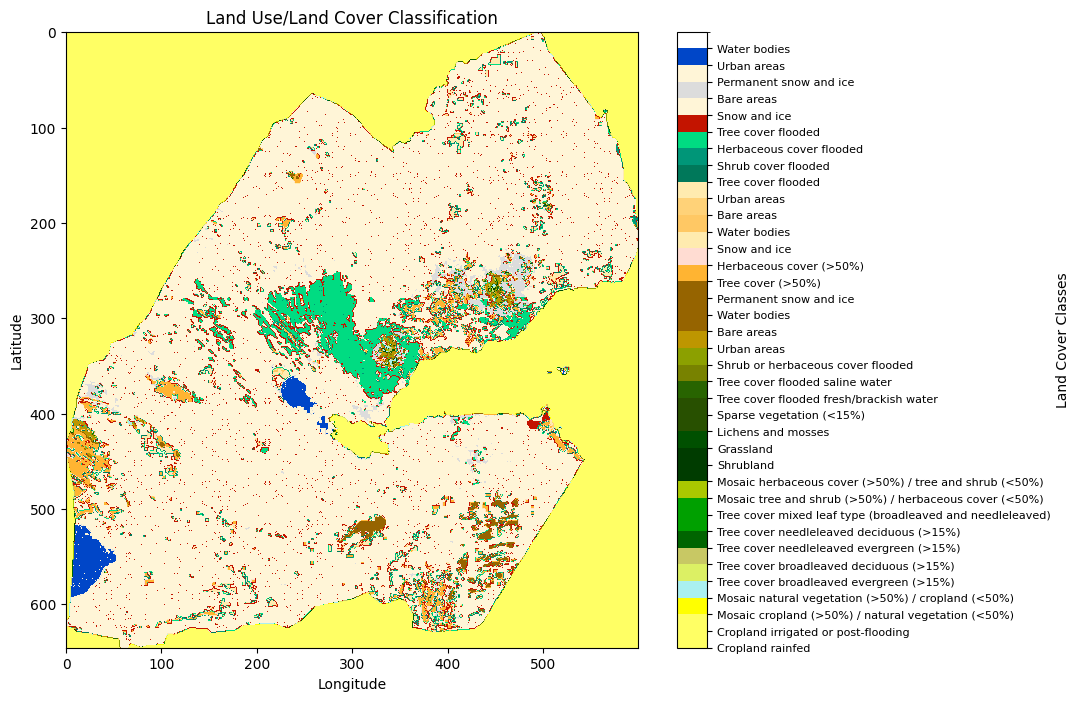

In [ ]:
# Define the color palette and class values
color_palette = [
    '#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

class_names = [
    "Cropland rainfed", "Cropland irrigated or post-flooding", "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)", "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)", "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)", "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)", "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland", "Grassland", "Lichens and mosses", "Sparse vegetation (<15%)", "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water", "Shrub or herbaceous cover flooded", "Urban areas", "Bare areas",
    "Water bodies", "Permanent snow and ice", "Tree cover (>50%)", "Herbaceous cover (>50%)", "Snow and ice",
    "Water bodies", "Bare areas", "Urban areas", "Tree cover flooded", "Shrub cover flooded",
    "Herbaceous cover flooded", "Tree cover flooded", "Snow and ice", "Bare areas", "Permanent snow and ice",
    "Urban areas", "Water bodies"
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

# Path to your TIFF file
tiff_file_path = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Djibouti_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path

# Open the TIFF file using rasterio
with rasterio.open(tiff_file_path) as src:
    # Read the entire dataset
    data = src.read(1)  # Reading only the first band, adjust if needed

    # Get the metadata
    profile = src.profile

    # Get the coordinates
    transform = src.transform
    x_coords = np.arange(profile['width']) * transform[0] + transform[2]
    y_coords = np.arange(profile['height']) * transform[4] + transform[5]

# Create a DataArray from the raster data
da = xr.DataArray(
    data,
    dims=("y", "x"),
    coords={
        "y": y_coords,
        "x": x_coords,
    },
    attrs=profile,
)

# Convert the DataArray to a Dataset
ds = xr.Dataset({"raster": da})

# Create a custom colormap
cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

# Plotting the raster data with the custom colormap
plt.figure(figsize=(10, 8))
im = plt.imshow(ds.raster, cmap=cmap, norm=norm)

# Create a colorbar with custom tick labels
cbar = plt.colorbar(im, boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
cbar.ax.set_yticklabels(class_names, fontsize=8)
cbar.ax.set_ylabel('Land Cover Classes')

plt.title('Land Use/Land Cover Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Copernicus Climate Change Service, Climate Data Store, (2019): Land cover classification gridded maps from 1992 to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.006f2c9a (Accessed on DD-MMM-YYYY)

In [ ]:
# Define the class names, color palette and class values
class_names = [
    "Nothing",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland irrigated or post-flooding",
    "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)",
    "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland",
    "Shrubland",
    "Shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water",
    "Shrub or herbaceous cover flooded",
    "Urban areas",
    "Bare areas",
    "Bare areas",
    "Bare areas",
    "Water bodies",
    "Permanent snow and ice"
]

color_palette = [
    '#ffffff','#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

# Paths to your TIFF files
tiff_file_path_before = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Nigeria_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path
tiff_file_path_after = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Nigeria_LULC_2002_lccs_class_the_year_after_disaster.tif'  # Replace with your actual path

In [ ]:
# Open the before disaster TIFF file using rasterio
with rasterio.open(tiff_file_path_before) as src_before:
    data_before = src_before.read(1)
    profile_before = src_before.profile
    transform_before = src_before.transform
    x_coords_before = np.arange(profile_before['width']) * transform_before[0] + transform_before[2]
    y_coords_before = np.arange(profile_before['height']) * transform_before[4] + transform_before[5]

# Open the after disaster TIFF file using rasterio
with rasterio.open(tiff_file_path_after) as src_after:
    data_after = src_after.read(1)
    profile_after = src_after.profile
    transform_after = src_after.transform
    x_coords_after = np.arange(profile_after['width']) * transform_after[0] + transform_after[2]
    y_coords_after = np.arange(profile_after['height']) * transform_after[4] + transform_after[5]

# Ensure that the datasets are aligned
assert data_before.shape == data_after.shape, "The dimensions of the two rasters do not match."

# Calculate change detection
change_detection = data_after - data_before

# Calculate change detection statistics for each class
change_stats = {}
for value in class_values:
    change_stats[value] = {
        "name": class_names[class_values.index(value)],
        "count_before": np.sum(data_before == value),
        "count_after": np.sum(data_after == value),
        "change": np.sum(change_detection == value)
    }

# Print change detection statistics
for value, stats in change_stats.items():
    print(f"Class {value} ({stats['name']}):")
    print(f"  Count Before: {stats['count_before']}")
    print(f"  Count After: {stats['count_after']}")
    print(f"  Change: {stats['change']}")
    print()

# Visualize change detection
plt.figure(figsize=(10, 8))

# custom colors
cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

# plot the image (the change)
im = plt.imshow(change_detection, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
cbar.ax.set_yticklabels(class_names, fontsize=8)
cbar.ax.set_ylabel('Land Cover Classes')
plt.title('Change Detection: Land Use/Land Cover')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
def calculate_change_stats(data_before, data_after):
    """Calculate change detection statistics between two datasets."""
    change_stats = {}
    for value in class_values:
        count_before = np.sum(data_before == value)
        count_after = np.sum(data_after == value)
        change = count_after - count_before
        change_type = "increase" if change > 0 else "decrease" if change < 0 else "no change"
        change_stats[value] = {
            "name": class_names[class_values.index(value)],
            "count_before": count_before,
            "count_after": count_after,
            "change": change,
            "change_type": change_type
        }
    return change_stats

def process_raster_files(before_path, after_path):
    """Process raster files and return change statistics."""
    with rasterio.open(before_path) as src_before:
        data_before = src_before.read(1)

    with rasterio.open(after_path) as src_after:
        data_after = src_after.read(1)

    assert data_before.shape == data_after.shape, "The dimensions of the two rasters do not match."

    return calculate_change_stats(data_before, data_after)

# Directory containing subfolders named after years
root_directory = '/content/drive/MyDrive/Project files/clipped_rasters/'  # Replace with your actual path

# Initialize an empty DataFrame
df_columns = ["country", "year", "class_value", "class_name", "count_before", "count_after", "change", "change_type"]
df_list = []

# Loop over the directory structure from 2000 to 2018
for year in range(2000, 2019):
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        print(f"Processing year: {year}")
        for filename in os.listdir(year_path):
            if filename.endswith('_lccs_class_the_year_before_disaster.tif'):
                country = filename.split('_')[0]
                before_path = os.path.join(year_path, filename)

                # Extract the year from the filename and calculate the after year
                parts = filename.split('_')
                before_year = int(parts[2])
                after_year = before_year + 2
                parts[2] = str(after_year)
                after_filename = '_'.join(parts).replace('the_year_before', 'the_year_after')
                after_path = os.path.join(year_path, after_filename)

                print(f"Processing country: {country}")
                print(f"Before disaster file: {before_path}")
                print(f"After disaster file: {after_path}")

                if os.path.exists(before_path) and os.path.exists(after_path):
                    change_stats = process_raster_files(before_path, after_path)

                    for value, stats in change_stats.items():
                        df_list.append({
                            "country": country,
                            "year": year,
                            "class_value": value,
                            "class_name": stats["name"],
                            "count_before": stats["count_before"],
                            "count_after": stats["count_after"],
                            "change": stats["change"],
                            "change_type": stats["change_type"]
                        })
                    print(f"Processing for country: {country} in year: {year} is done.")
                else:
                    print(f"Missing file for country: {country} in year: {year}")

# Create a DataFrame from the list
df = pd.DataFrame(df_list)

# Display the DataFrame
print(df)

In [ ]:
df_urban = df[df["class_name"]== "Urban areas"]
df_urban

country  year  class_value   class_name  count_before  count_after  \
31       Botswana  2000          190  Urban areas          2463         2606   
68     Madagascar  2000          190  Urban areas          3686         3942   
105       Morocco  2000          190  Urban areas         15306        16615   
142    Mozambique  2000          190  Urban areas          4268         4733   
179         Niger  2000          190  Urban areas          1087         1113   
...           ...   ...          ...          ...           ...          ...   
11168       Sudan  2018          190  Urban areas         17688        21457   
11205     Nigeria  2018          190  Urban areas         76190        80907   
11242      Rwanda  2018          190  Urban areas          1511         1530   
11279      Malawi  2018          190  Urban areas          4248         4509   
11316     Burundi  2018          190  Urban areas          1241         1243   

       change change_type  
31        143    increase  
68        256    increase  
105      1309    increase  
142       465    increase  
179        26    increase  
...       ...         ...  
11168    3769    increase  
11205    4717    increase  
11242      19    increase  
11279     261    increase  
11316       2    increase  

[306 rows x 8 columns]

In [ ]:
def calculate_change_stats(data_before, data_after):
    """Calculate change detection statistics between two datasets."""
    change_stats = {}
    for value in class_values:
        count_before = np.sum(data_before == value)
        count_after = np.sum(data_after == value)
        change = count_after - count_before
        change_type = "increase" if change > 0 else "decrease" if change < 0 else "no change"
        change_stats[value] = {
            "name": class_names[class_values.index(value)],
            "count_before": count_before,
            "count_after": count_after,
            "change": change,
            "change_type": change_type
        }
    return change_stats

def process_raster_files(before_path, after_path):
    """Process raster files and return change statistics and difference raster."""
    with rasterio.open(before_path) as src_before:
        data_before = src_before.read(1)

    with rasterio.open(after_path) as src_after:
        data_after = src_after.read(1)

    assert data_before.shape == data_after.shape, "The dimensions of the two rasters do not match."

    change_stats = calculate_change_stats(data_before, data_after)
    difference_raster = data_after - data_before

    return change_stats, difference_raster

def plot_difference_raster(difference_raster, country, year, class_name=None):
    """Plot the difference raster to visualize changes."""
    plt.figure(figsize=(10, 8))

    if class_name:
        class_index = class_names.index(class_name)
        mask = (difference_raster == class_values[class_index])
        masked_diff = np.where(mask, difference_raster, np.nan)
        cmap = ListedColormap([color_palette[class_index]])
        norm = BoundaryNorm([class_values[class_index], class_values[class_index] + 1], cmap.N)
        plt.imshow(masked_diff, cmap=cmap, norm=norm)
    else:
        cmap = ListedColormap(color_palette)
        norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)
        plt.imshow(difference_raster, cmap=cmap, norm=norm)

    plt.colorbar(boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
    title = f'Change Detection for {country} in {year}'
    if class_name:
        title += f' for {class_name}'
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Directory containing subfolders named after years
root_directory = '/content/drive/MyDrive/Project files/clipped_rasters/'  # Replace with your actual path

# Initialize an empty DataFrame
df_columns = ["country", "year", "class_value", "class_name", "count_before", "count_after", "change", "change_type"]
df_list = []

# Loop over the directory structure from 2000 to 2018
for year in range(2000, 2019):
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        print(f"Processing year: {year}")
        for filename in os.listdir(year_path):
            if filename.endswith('_lccs_class_the_year_before_disaster.tif'):
                country = filename.split('_')[0]
                before_path = os.path.join(year_path, filename)

                # Extract the year from the filename and calculate the after year
                parts = filename.split('_')
                before_year = int(parts[2])
                after_year = before_year + 2
                parts[2] = str(after_year)
                after_filename = '_'.join(parts).replace('the_year_before', 'the_year_after')
                after_path = os.path.join(year_path, after_filename)

                print(f"Processing country: {country}")
                print(f"Before disaster file: {before_path}")
                print(f"After disaster file: {after_path}")

                if os.path.exists(before_path) and os.path.exists(after_path):
                    change_stats, difference_raster = process_raster_files(before_path, after_path)

                    for value, stats in change_stats.items():
                        df_list.append({
                            "country": country,
                            "year": year,
                            "class_value": value,
                            "class_name": stats["name"],
                            "count_before": stats["count_before"],
                            "count_after": stats["count_after"],
                            "change": stats["change"],
                            "change_type": stats["change_type"]
                        })
                    print(f"Processing for country: {country} in year: {year} is done.")

                    # Plot the difference raster for visualizing changes
                    plot_difference_raster(difference_raster, country, year)
                else:
                    print(f"Missing file for country: {country} in year: {year}")

# Create a DataFrame from the list
df = pd.DataFrame(df_list)

# Display the DataFrame
print(df)

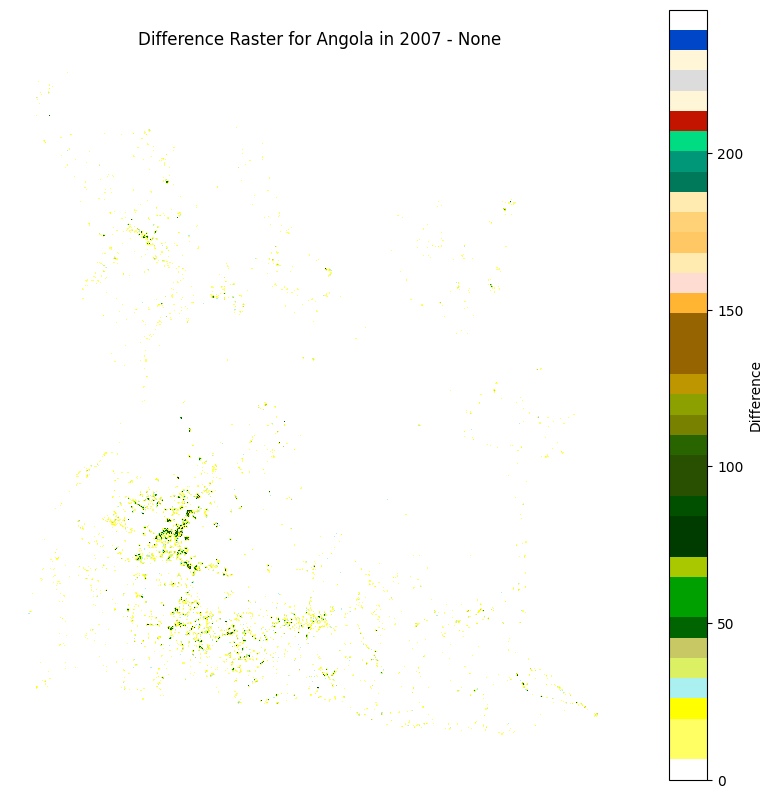

In [ ]:
def plot_class_difference(root_directory, country, year, class_name=None):
    """Plot the difference for a specified country, year, and class name."""
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        before_filename = f'{country}_LULC_{year -1}_lccs_class_the_year_before_disaster.tif'
        after_filename = f'{country}_LULC_{year + 1}_lccs_class_the_year_after_disaster.tif'
        before_path = os.path.join(year_path, before_filename)
        after_path = os.path.join(year_path, after_filename)

        if os.path.exists(before_path) and os.path.exists(after_path):
            _, difference_raster = process_raster_files(before_path, after_path)
            plot_difference_raster(difference_raster, country, year, class_name)
        else:
            print(f"Missing file for country: {country} in year: {year}")
    else:
        print(f"Year folder {year} does not exist.")

plot_class_difference('/content/drive/MyDrive/Project files/clipped_rasters/', 'Angola', 2007)

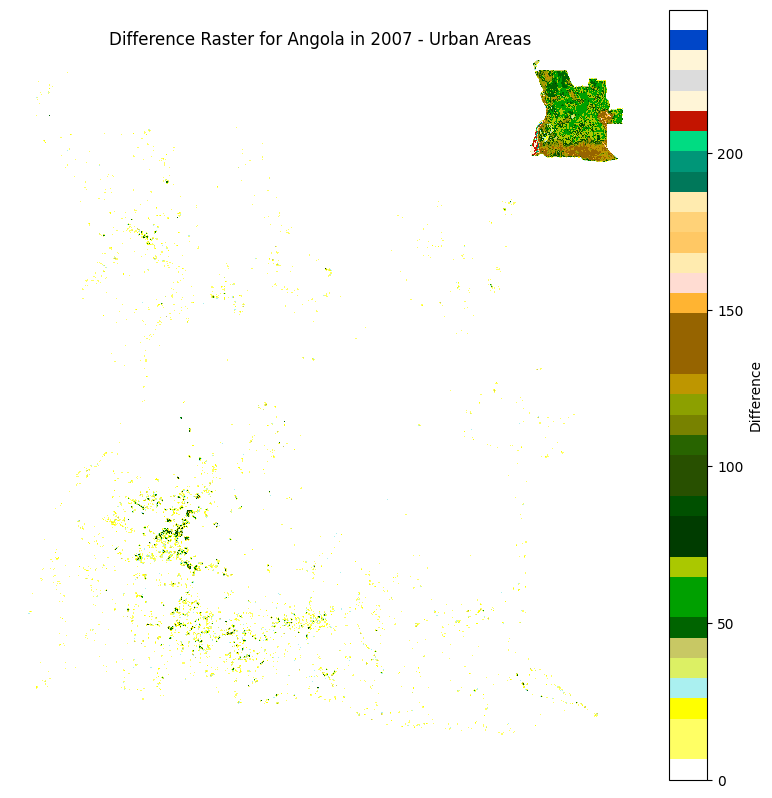

In [ ]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rasterio

cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

def process_raster_files(before_path, after_path):
    """Process the raster files and compute the difference."""
    with rasterio.open(before_path) as src_before, rasterio.open(after_path) as src_after:
        before_data = src_before.read(1)
        after_data = src_after.read(1)
        difference_data = after_data - before_data
    return before_data, difference_data

def plot_difference_raster(difference_raster, country, year, class_name=None):
    """Plot the difference raster."""
    cmap = ListedColormap(color_palette)
    norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)
    plt.figure(figsize=(10, 10))
    plt.imshow(difference_raster, cmap=cmap)
    plt.title(f'Difference Raster for {country} in {year} - {class_name}')
    plt.colorbar(label='Difference')
    plt.axis('off')

def plot_class_difference(root_directory, country, year, class_name=None, cmap=cmap, norm=norm):
    """Plot the difference for a specified country, year, and class name."""
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        before_filename = f'{country}_LULC_{year - 1}_lccs_class_the_year_before_disaster.tif'
        after_filename = f'{country}_LULC_{year + 1}_lccs_class_the_year_after_disaster.tif'
        before_path = os.path.join(year_path, before_filename)
        after_path = os.path.join(year_path, after_filename)

        if os.path.exists(before_path) and os.path.exists(after_path):
            before_raster, difference_raster = process_raster_files(before_path, after_path)
            plot_difference_raster(difference_raster, country, year, class_name)

            # Add inset showing the area without change
            ax_inset = inset_axes(plt.gca(), width="15%", height="15%", loc="upper right")
            ax_inset.imshow(before_raster, cmap=cmap, norm=norm)
            ax_inset.axis('off')
            plt.show()
        else:
            print(f"Missing file for country: {country} in year: {year}")
    else:
        print(f"Year folder {year} does not exist.")

# Usage example
plot_class_difference('/content/drive/MyDrive/Project files/clipped_rasters/', 'Angola', 2007, 'Urban Areas')

In [ ]:
# Define the path to your TIFF file on Google Drive
tiff_drive_path = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Djibouti_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path

image = ee.Image("projects/aims-ai2324-std-aness-9fl/assets/Djibouti_LULC_2000_lccs_class_the_year_before_disaster")

## Personal Code

In [ ]:
filename = 'data/external/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc'
# Create Xarray Dataset
ds = xr.open_dataset(filename)

In [ ]:
ds.dims

Frozen({'time': 1, 'lat': 64800, 'lon': 129600, 'bounds': 2})

In [ ]:
ds.data_vars

Data variables:
    lccs_class           (time, lat, lon) uint8 ...
    processed_flag       (time, lat, lon) float32 ...
    current_pixel_state  (time, lat, lon) float32 ...
    observation_count    (time, lat, lon) uint16 ...
    change_count         (time, lat, lon) uint8 ...
    crs                  int32 ...
    lat_bounds           (lat, bounds) float64 ...
    lon_bounds           (lon, bounds) float64 ...
    time_bounds          (time, bounds) datetime64[ns] ...

In [ ]:
da

<xarray.DataArray 'lccs_class' (time: 1, lat: 64800, lon: 129600)>
[8398080000 values with dtype=uint8]
Coordinates:
  * lat      (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -89.99 -90.0 -90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2000-01-01
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0  10  11  12  20  30  40  50  60  61  62  70  7...

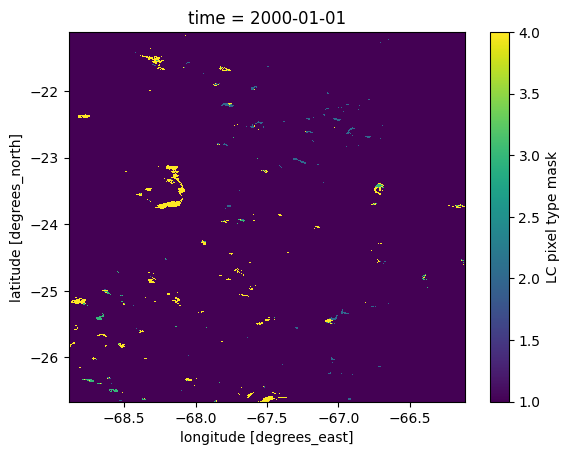

In [ ]:
ds['current_pixel_state'][0,40000:42000,40000:41000].plot()

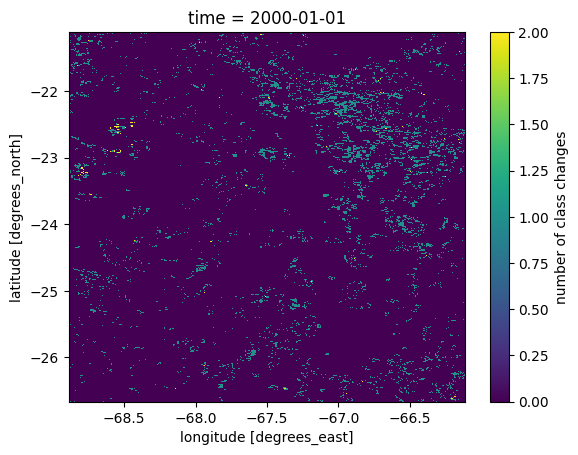

In [ ]:
ds['change_count'][0,40000:42000,40000:41000].plot()

**lccs_class (time, lat, lon) uint8:**

Description: Land Cover Classification System (LCCS) class codes. This variable contains the land cover classification for each pixel in the dataset.\
Use for Plotting: Yes, this is essential for plotting the land cover map.

**processed_flag (time, lat, lon) float32:**

Description: Flags indicating the processing status of each pixel. This could be used to mark pixels that have been processed in certain ways.\
Use for Plotting: Not typically used for basic land cover plotting but may be useful for quality control.

**current_pixel_state (time, lat, lon) float32:**

Description: Indicates the current state of each pixel, possibly related to vegetation, water, or other states.\
Use for Plotting: This might be useful depending on the specific analysis but is not necessary for a basic land cover map.

**observation_count (time, lat, lon) uint16:**

Description: The number of observations for each pixel. This could indicate the number of times the pixel has been observed or measured.\
Use for Plotting: Generally not needed for basic land cover plotting but could be useful for data quality analysis.

**change_count (time, lat, lon) uint8:**

Description: The number of changes detected for each pixel. This could indicate how often the land cover type has changed.\
Use for Plotting: Not needed for a static land cover map but could be useful for change detection analysis.

**crs () int32:**

Description: Coordinate Reference System information. This specifies the spatial reference system used in the dataset.\
Use for Plotting: Yes, this is necessary to correctly plot the map, as it defines how the coordinates should be interpreted.

**lat_bounds (lat, bounds) float64:**

Description: Latitude bounds for each latitude value. This provides the edges of each latitude cell.\
Use for Plotting: Not directly needed for plotting the map but could be useful for understanding the spatial resolution.

**lon_bounds (lon, bounds) float64:**

Description: Longitude bounds for each longitude value. This provides the edges of each longitude cell.\
Use for Plotting: Not directly needed for plotting the map but could be useful for understanding the spatial resolution.

**time_bounds (time, bounds) datetime64[ns]:**

Description: Time bounds for each time value. This provides the start and end times for the time periods covered.\
Use for Plotting: Not needed for a single time point map but useful for time series analysis.

**Variables Needed for Plotting the Map
To plot a basic land cover map, you will primarily need the following variables:**

**lccs_class (time, lat, lon) uint8:**

This variable provides the land cover classification for each pixel and is the main data you want to visualize on the map.

Coordinates:

**lat (lat) float64:** Latitude values.

**lon (lon) float64:** Longitude values.

**time (time) datetime64[ns]:** Time values (if you are dealing with a time series, though for a single map you might just pick one time point).

**crs () int32:** This variable is necessary to understand the spatial reference system and ensure that the map is plotted in the correct location and projection.

## Convert and assign crs to the file

In [ ]:
%%capture
!pip install dask cupy xarray rasterio tqdm Cartopy localtileserver

In [ ]:
%%capture
!apt-get install -y gdal-bin

In [ ]:
import os
import gc
import logging
import numpy as np
import subprocess
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import xarray as xr
import dask.array as da
from tqdm.auto import tqdm
from dask.distributed import Client, progress

# Try to import CuPy for GPU processing, default to NumPy for CPU
try:
    import cupy as cp
    gpu_available = cp.cuda.runtime.getDeviceCount() > 0
except ImportError:
    gpu_available = False

In [ ]:
# Open the NetCDF file with Dask
filename = "/content/CERI/data/external/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc"
ds = xr.open_dataset(filename, chunks={'time': 1, 'lat': 10000, 'lon': 20000})
variables = ["lccs_class"]

In [ ]:
# Attempt to extract CRS information from dataset attributes
crs_attr = ds.attrs.get('crs') or ds.attrs.get('spatial_ref', 'EPSG:4326')
if isinstance(crs_attr, str) and crs_attr.startswith('EPSG:'):
    epsg_code = int(crs_attr.split(':')[1])
    crs = CRS.from_epsg(epsg_code)
else:
    crs = CRS.from_epsg(4326)  # Default to WGS84 if no valid CRS information is found

In [ ]:
# Print the current working directory and log file path
log_file_path = os.path.join(os.getcwd(), 'processing_log.log')
print(f"Log file will be stored at: {log_file_path}")

# Configure logging to file
logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s %(message)s', filemode='w')
logging.info(f"GPU available: {gpu_available}")

Log file will be stored at: /content/CERI/processing_log.log


In [ ]:
def process_chunk(chunk, variable_name, chunk_index, crs):
    # Generate a temporary file name for the chunk
    tif = f"temp_{variable_name}_chunk_{chunk_index}.tif"
    tif_with_crs = f"temp_{variable_name}_chunk_{chunk_index}_crs.tif"

    # Process chunk on GPU if available
    if gpu_available:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on GPU...")
        chunk_array = cp.array(chunk)
        if chunk_array.ndim == 2:
            chunk_array = cp.expand_dims(chunk_array, axis=0)
        logging.info(f"Moving chunk {chunk_index} for variable {variable_name} back to CPU memory...")
        chunk_array_cpu = cp.asnumpy(chunk_array)
    else:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on CPU...")
        chunk_array_cpu = np.array(chunk)
        if chunk_array_cpu.ndim == 2:
            chunk_array_cpu = np.expand_dims(chunk_array_cpu, axis=0)

    # Determine the transform and metadata
    transform = from_bounds(-180, -90, 180, 90, chunk_array_cpu.shape[2], chunk_array_cpu.shape[1])
    metadata = {
        'driver': 'GTiff',
        'height': chunk_array_cpu.shape[1],
        'width': chunk_array_cpu.shape[2],
        'count': chunk_array_cpu.shape[0],
        'dtype': chunk_array_cpu.dtype,
        'transform': transform
    }

    # Write the chunk to a temporary TIFF file
    with rasterio.open(tif, 'w', **metadata) as dst:
        dst.write(chunk_array_cpu)

    # Assign CRS using gdal_translate
    subprocess.run(['gdal_translate', '-a_srs', str(crs), tif, tif_with_crs])

    # Remove the original temporary file
    os.remove(tif)

    # Clear memory
    del chunk_array_cpu
    gc.collect()

    return tif_with_crs

# Extract variable data and calculate the number of chunks
variable_data = {var: ds[var].data for var in variables}
num_chunks = variable_data[variables[0]].numblocks
total_chunks = num_chunks[0] * num_chunks[1] * num_chunks[2]

# Create an iterable of chunk indices
chunk_indices = [(t, lat, lon) for t in range(num_chunks[0]) for lat in range(num_chunks[1]) for lon in range(num_chunks[2])]

# Track temporary files for each chunk and variable
temp_files_dict = {var: [] for var in variables}

# Process each chunk of all variables
for chunk_index in tqdm(chunk_indices, desc="Processing all chunks", total=total_chunks):
    time_index, lat_index, lon_index = chunk_index
    for variable in variables:
        chunk = variable_data[variable].blocks[time_index, lat_index, lon_index].compute()  # Compute the chunk to get the actual data
        temp_tif_with_crs = process_chunk(chunk, variable, f"{time_index}_{lat_index}_{lon_index}", crs)
        temp_files_dict[variable].append(temp_tif_with_crs)

# Create a single multi-band TIFF file
output_tif = "year_2000_LULC_combined.tif"
with rasterio.open(temp_files_dict[variables[0]][0]) as src0:
    meta = src0.meta
    meta.update(count=len(variables))

with rasterio.open(output_tif, 'w', **meta) as dst:
    for band_index, variable in enumerate(variables, start=1):
        for temp_file in tqdm(temp_files_dict[variable], desc=f"Merging {variable} chunks", total=len(temp_files_dict[variable])):
            with rasterio.open(temp_file) as src:
                dst.write_band(band_index, src.read(1))

# Clear temporary files
for temp_files in temp_files_dict.values():
    for temp_file in temp_files:
        os.remove(temp_file)

# Clear memory after processing all variables
del variable_data
gc.collect()

Processing all chunks:   0%|          | 0/49 [00:00<?, ?it/s]

Merging lccs_class chunks:   0%|          | 0/49 [00:00<?, ?it/s]

40

In [ ]:
ds = xr.open_dataset('/content/CERI/year_2000_LULC_combined.tif')
ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 20000, y: 10000)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
  * y            (y) float64 89.99 89.97 89.95 89.94 ... -89.95 -89.97 -89.99
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

### Failed experiment

In [ ]:
import os
import gc
import numpy as np
import cupy as cp
import logging
import rasterio
from rasterio.transform import from_bounds
from tqdm import tqdm
import dask.array as da

def process_chunk(chunk, variable_name, chunk_index, crs, shift_lon=False):
    # Generate a temporary file name for the chunk
    tif = f"temp_{variable_name}_chunk_{chunk_index}.tif"

    # Check if GPU is available
    if gpu_available:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on GPU...")
        chunk_array = cp.array(chunk)
        if chunk_array.ndim == 2:
            chunk_array = cp.expand_dims(chunk_array, axis=0)
        logging.info(f"Moving chunk {chunk_index} for variable {variable_name} back to CPU memory...")
        chunk_array_cpu = cp.asnumpy(chunk_array)
    else:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on CPU...")
        chunk_array_cpu = np.array(chunk)
        if chunk_array_cpu.ndim == 2:
            chunk_array_cpu = np.expand_dims(chunk_array_cpu, axis=0)

    # Determine the transform and metadata
    transform = from_bounds(-180, -90, 180, 90, chunk_array_cpu.shape[2], chunk_array_cpu.shape[1])
    metadata = {
        'driver': 'GTiff',
        'height': chunk_array_cpu.shape[1],
        'width': chunk_array_cpu.shape[2],
        'count': chunk_array_cpu.shape[0],
        'dtype': chunk_array_cpu.dtype,
        'transform': transform,
        'crs': crs
    }

    # Write the chunk to a temporary TIFF file
    with rasterio.open(tif, 'w', **metadata) as dst:
        dst.write(chunk_array_cpu)

    # Clear memory
    del chunk_array_cpu
    gc.collect()

    return tif

# Assume `ds` is the opened xarray dataset and `variables` is the list of variable names
variable_data = {var: ds[var].data for var in variables}
num_chunks = variable_data[variables[0]].numblocks
total_chunks = num_chunks[0] * num_chunks[1] * num_chunks[2]

# Create an iterable of chunk indices
chunk_indices = [(t, lat, lon) for t in range(num_chunks[0]) for lat in range(num_chunks[1]) for lon in range(num_chunks[2])]

# Track temporary files for each chunk and variable
temp_files_dict = {var: [] for var in variables}

# Process each chunk of all variables
for chunk_index in tqdm(chunk_indices, desc="Processing all chunks", total=total_chunks):
    time_index, lat_index, lon_index = chunk_index
    for variable in variables:
        chunk = variable_data[variable].blocks[time_index, lat_index, lon_index].compute()  # Compute the chunk to get the actual data
        temp_tif = process_chunk(chunk, variable, f"{time_index}_{lat_index}_{lon_index}", crs)
        temp_files_dict[variable].append(temp_tif)

# Create a single multi-band TIFF file
output_tif = "year_2000_LULC_combined.tif"
with rasterio.open(temp_files_dict[variables[0]][0]) as src0:
    meta = src0.meta
    meta.update(count=len(variables))

with rasterio.open(output_tif, 'w', **meta) as dst:
    for band_index, variable in enumerate(variables, start=1):
        for temp_file in tqdm(temp_files_dict[variable], desc=f"Merging {variable} chunks", total=len(temp_files_dict[variable])):
            with rasterio.open(temp_file) as src:
                dst.write_band(band_index, src.read(1))

# Clear temporary files
for temp_files in temp_files_dict.values():
    for temp_file in temp_files:
        os.remove(temp_file)

# Clear memory after processing all variables
del variable_data
gc.collect()

In [ ]:
m = geemap.Map(layer_ctrl=True)

m.add_raster('/content/year_2000_LULC_combined.tif', palette="coolwarm", layer_name="lccs_class")
m

# Land cover classification

In [ ]:
!wget 'http://madm.dfki.de/files/sentinel/EuroSATallBands.zip'

--2024-05-19 12:25:52--  http://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  20.9MB/s    in 93s     

2024-05-19 12:27:25 (21.2 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [ ]:
!unzip 'EuroSATallBands.zip'

In [ ]:
REMOTE_SENSING_DATA_PATH = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif'

In [ ]:
!pip install -U torchsat

In [ ]:
import os
import tifffile as tiff
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch
from PIL import Image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for label in os.listdir(self.data_dir):
            class_dir = os.path.join(self.data_dir, label)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(label)
        # Print the number of images and labels loaded
        print(f"Loaded {len(self.image_paths)} images with {len(self.labels)} labels.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = tiff.imread(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        # Print the image path and label for the current index
        print(f"Loading image: {img_path}, Label: {label}")
        return image, label

# Usage
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir = '/content/ds/images/remote_sensing/otherDatasets/sentinel_2/tif'  # Replace with your actual data path
dataset = CustomDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Loaded 27000 images with 27000 labels.


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio

class RemoteSensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                if img_name.endswith('.tiff') or img_name.endswith('.tif'):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image using rasterio
        with rasterio.open(img_path) as src:
            img = src.read()

        # Convert the image to a PIL image
        img = Image.fromarray(img.transpose(1, 2, 0))  # rasterio reads as (channels, height, width)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = RemoteSensingDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(dataloader)

844

In [ ]:
img, label = next(iter(dataloader))

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 128 * 128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = len(os.listdir(data_dir))
model = SimpleCNN(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')